<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/Syn_MELD_KM_UNOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=af9e4050aef5248d3c087c34d7e4cb645e599412c416dd3bdec521201b7e7691
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [23]:
# Imports and device setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
syn_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/synthetic_natural_survival_full.csv')
df = pd.read_csv('/content/drive/MyDrive/SyntheticData/UNOS_Cohort.csv')


real_df = df.copy()

# (Optional) Display first few rows
display(real_df)


Using device: cuda


Age Gender ABO        BMI     Na    Cr Dialysis   INR   Bili  Albumin  \
0       57      F   O  31.480705  137.0  2.66        N  2.10  43.90      4.1   
1       28      F   O  27.949687  127.0  0.50        N  3.20  24.80      2.8   
2       51      M   A  25.618483  148.0  2.31        N  2.16  42.60      2.8   
3       30      M   A  21.544936  130.0  1.07        N  2.48  24.60      3.4   
4       53      M   O  39.382391  141.0  0.61        N  1.20   1.30      3.2   
...    ...    ...  ..        ...    ...   ...      ...   ...    ...      ...   
48769   28      F   A  34.163334  134.0  0.55        N  2.10  12.20      2.9   
48770   63      M   O  26.997341  131.0  1.59        N  1.40   2.40      3.8   
48771   64      M  AB  25.749959  142.0  2.80        Y  1.50   2.30      4.2   
48772   64      F   O  40.565249  132.0  1.90        N  2.52  14.24      1.9   
48773   62      F   A  35.475811  126.0  2.39        N  1.70   3.70      3.1   

       MELD  outcome   tte     Etiology               Ethnicity  \
0        39        2     7      Alcohol                   White   
1        32        2     4   Autoimmune                   White   
2        37        2     2   Autoimmune  Black/African American   
3        30        2    29  Cryptogenic                   White   
4         9        2  1295         NASH         Hispanic/Latino   
...     ...      ...   ...          ...                     ...   
48769    26        2     7   Autoimmune  Black/African American   
48770    22        2     4         NASH                   White   
48771    27        0    13         NASH                   Asian   
48772    34        2     1         NASH                   White   
48773    31        2     6         NASH                   White   

      diab_group_labeled Encephalopathy_Status Ascites_Status  
0            No Diabetes             Grade 1-2         Slight  
1            No Diabetes                   NaN       Moderate  
2            No Diabetes             Grade 1-2         Slight  
3            No Diabetes                   NaN         Slight  
4               Diabetes             Grade 3-4            NaN  
...                  ...                   ...            ...  
48769        No Diabetes             Grade 1-2         Slight  
48770           Diabetes             Grade 1-2         Slight  
48771           Diabetes             Grade 1-2       Moderate  
48772           Diabetes             Grade 3-4         Slight  
48773           Diabetes             Grade 1-2       Moderate  

[48774 rows x 18 columns]

In [24]:
# Create a random sample of 30% of the original dataframe
sample_size = 0.3  # 30%
sampled_df = real_df.sample(frac=sample_size, random_state=42)  # Setting random_state for reproducibility

# Check the shape of the sampled dataframe
print(f"Original dataframe shape: {real_df.shape}")
print(f"Sampled dataframe shape: {sampled_df.shape}")
print(f"Percentage of original data: {len(sampled_df) / len(real_df) * 100:.2f}%")

# Verify outcome distribution is preserved
if 'outcome' in real_df.columns:
    print("\nOutcome distribution in original data:")
    print(real_df['outcome'].value_counts(normalize=True) * 100)

    print("\nOutcome distribution in sampled data:")
    print(sampled_df['outcome'].value_counts(normalize=True) * 100)

Original dataframe shape: (48774, 18)
Sampled dataframe shape: (14632, 18)
Percentage of original data: 30.00%

Outcome distribution in original data:
outcome
2    70.334605
0    18.554968
1    11.110428
Name: proportion, dtype: float64

Outcome distribution in sampled data:
outcome
2    70.441498
0    18.193002
1    11.365500
Name: proportion, dtype: float64


In [25]:
real_df = sampled_df

In [26]:
# Count outcome categories in syn_df
outcome_counts = syn_df['outcome'].value_counts().sort_index()
outcome_percentages = syn_df['outcome'].value_counts(normalize=True).sort_index() * 100

# Display results
print("Outcome category counts:")
for category, count in outcome_counts.items():
    print(f"Outcome {category}: {count} ({outcome_percentages[category]:.4f}%)")

print("\nTotal rows:", len(syn_df))

Outcome category counts:
Outcome 0: 6250506 (62.5051%)
Outcome 1: 3749494 (37.4949%)

Total rows: 10000000


In [27]:
# Count outcome categories in real_df
outcome_counts = real_df['outcome'].value_counts().sort_index()
outcome_percentages = real_df['outcome'].value_counts(normalize=True).sort_index() * 100

# Display results
print("Outcome category counts:")
for category, count in outcome_counts.items():
    print(f"Outcome {category}: {count} ({outcome_percentages[category]:.4f}%)")

print("\nTotal rows:", len(real_df))

Outcome category counts:
Outcome 0: 2662 (18.1930%)
Outcome 1: 1663 (11.3655%)
Outcome 2: 10307 (70.4415%)

Total rows: 14632


In [28]:
# --- Process synthetic and real data without outcome filtering ---
# Define features
numeric_features = ['Na',
                    'Cr', 'INR', 'Bili',
                    'Albumin']
categorical_features = ['Gender', 'Dialysis']

# Process real data (all outcomes)
real_df = real_df.copy().reset_index(drop=True)
print("Real dataset shape:", real_df.shape)

# Process synthetic data (all outcomes)
syn_df_processed = syn_df.copy().reset_index(drop=True)
print("Synthetic dataset shape:", syn_df_processed.shape)

Real dataset shape: (14632, 18)
Synthetic dataset shape: (10000000, 18)


In [29]:
# For real_df
real_df['Ascites_Status'] = real_df['Ascites_Status'].fillna('None')
real_df['Encephalopathy_Status'] = real_df['Encephalopathy_Status'].fillna('None')

# For syn_df
syn_df['Ascites_Status'] = syn_df['Ascites_Status'].fillna('None')
syn_df['Encephalopathy_Status'] = syn_df['Encephalopathy_Status'].fillna('None')

# Verify the changes
print("Real df unique values:")
print("\nAscites_Status categories:", real_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", real_df['Encephalopathy_Status'].unique())

print("\nSynthetic df unique values:")
print("\nAscites_Status categories:", syn_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", syn_df['Encephalopathy_Status'].unique())

Real df unique values:

Ascites_Status categories: ['Slight' 'Moderate' 'None' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['Grade 1-2' 'None' 'Grade 3-4' 'Unknown/Not Reported']

Synthetic df unique values:

Ascites_Status categories: ['None' 'Moderate' 'Slight' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['None' 'Grade 1-2' 'Grade 3-4' 'Unknown/Not Reported']


In [30]:
# Get canonical feature names from all synthetic data
syn_categorical_cols = ['Gender', 'Dialysis']

syn_cat_tmp = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded_tmp = pd.get_dummies(syn_cat_tmp, drop_first=False)
cat_feature_names = syn_cat_encoded_tmp.columns
print("Categorical features:", list(cat_feature_names))

Categorical features: ['Gender_F', 'Gender_M', 'Dialysis_N', 'Dialysis_Y']


In [31]:
# Scale numeric features
scaler = StandardScaler()
syn_numeric = syn_df_processed[numeric_features].astype(float)
scaler = scaler.fit(syn_numeric)

# Process real numeric features
real_numeric = real_df[numeric_features].fillna(real_df[numeric_features].median()).astype(float)
real_numeric_scaled = scaler.transform(real_numeric)

# Process synthetic numeric features
syn_numeric_scaled = scaler.transform(syn_numeric)

In [32]:
# Process real categorical features
real_cat = real_df[categorical_features].copy()

real_cat = real_cat.astype(str)

# One-hot encode
real_cat_encoded = pd.get_dummies(real_cat, drop_first=False)
real_cat_encoded = real_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Process synthetic categorical features
syn_cat = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded = pd.get_dummies(syn_cat, drop_first=False)

In [33]:
# Combine real features
real_features = np.hstack([real_numeric_scaled, real_cat_encoded.values]).astype(np.float32)
print("Real features shape:", real_features.shape)

# Combine synthetic features
syn_features = np.hstack([syn_numeric_scaled, syn_cat_encoded.values]).astype(np.float32)
print("Synthetic features shape:", syn_features.shape)

Real features shape: (14632, 9)
Synthetic features shape: (10000000, 9)


In [34]:
class PairDataset(Dataset):
    def __init__(self, features, times, outcomes, n_pairs=100000, sim_threshold=30, dissim_threshold=100):
        self.features = np.array(features, dtype=np.float32)
        self.times = np.array(times, dtype=np.float32)
        self.outcomes = np.array(outcomes, dtype=np.float32)
        self.pairs = []
        self.labels = []
        N = self.features.shape[0]
        rng = np.random.RandomState(42)
        count = 0

        while count < n_pairs:
            i = rng.randint(0, N)
            j = rng.randint(0, N)
            if i == j:
                continue

            # Same outcome type (death, transplant, or censoring)
            if self.outcomes[i] == self.outcomes[j]:
                time_diff = abs(self.times[i] - self.times[j])
                if time_diff < sim_threshold:
                    label = 1.0
                elif time_diff > dissim_threshold:
                    label = 0.0
                else:
                    continue
                self.pairs.append((i, j))
                self.labels.append(label)
                count += 1

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        return (torch.tensor(self.features[i], dtype=torch.float32),
                torch.tensor(self.features[j], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

In [35]:
# Create PairDataset and DataLoader for training
pair_dataset = PairDataset(syn_features,
                          syn_df["tte"].values,
                          syn_df["outcome"].values,
                          n_pairs=100000,
                          sim_threshold=30,
                          dissim_threshold=100)
pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=True)
print("Pair dataset size:", len(pair_dataset))

Pair dataset size: 100000


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()

        # Build encoder layers
        layers = []
        current_dim = input_dim

        # Add hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim

        # Final embedding layer
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)

        # Separate transformation head with batch normalization
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

In [37]:
# Initialize model
input_dim = real_features.shape[1]
model_metric = MetricNet(input_dim, embedding_dim=64).to(device)

# Use different learning rates for different parts
params_dict = [
    {'params': model_metric.net.parameters(), 'lr': 1e-3},
    {'params': model_metric.transform.parameters(), 'lr': 5e-4}
]
optimizer_metric = torch.optim.AdamW(params_dict, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_metric, mode='min', factor=0.5, patience=10, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [38]:
# Define contrastive loss function
def contrastive_loss(x1, x2, label, margin=1.0):
    """
    Contrastive loss function
    x1, x2: embeddings of pairs
    label: 1 if similar, 0 if dissimilar
    margin: minimum distance for dissimilar pairs
    """
    # Compute Euclidean distance between x1 and x2
    d = torch.norm(x1 - x2, p=2, dim=1)
    # Loss for similar pairs (label=1): want small distance
    loss_sim = label * d**2
    # Loss for dissimilar pairs (label=0): want distance > margin
    loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
    # Return mean loss
    loss = torch.mean(loss_sim + loss_dissim)
    return loss

In [39]:
num_epochs_metric = 200
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

for epoch in range(num_epochs_metric):
    model_metric.train()
    total_loss = 0.0
    batch_losses = []

    for x1, x2, label in pair_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        label = label.to(device)

        emb1 = model_metric(x1)
        emb2 = model_metric(x2)
        loss = contrastive_loss(emb1, emb2, label, margin=1.0)

        optimizer_metric.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)

        optimizer_metric.step()
        total_loss += loss.item() * x1.size(0)
        batch_losses.append(loss.item())

    avg_loss = total_loss / len(pair_dataset)
    print(f"Epoch {epoch+1}/{num_epochs_metric}, Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

Epoch 1/200, Loss: 0.0908
Epoch 2/200, Loss: 0.0770
Epoch 3/200, Loss: 0.0706
Epoch 4/200, Loss: 0.0670
Epoch 5/200, Loss: 0.0658
Epoch 6/200, Loss: 0.0649
Epoch 7/200, Loss: 0.0642
Epoch 8/200, Loss: 0.0638
Epoch 9/200, Loss: 0.0636
Epoch 10/200, Loss: 0.0632
Epoch 11/200, Loss: 0.0628
Epoch 12/200, Loss: 0.0627
Epoch 13/200, Loss: 0.0622
Epoch 14/200, Loss: 0.0622
Epoch 15/200, Loss: 0.0617
Epoch 16/200, Loss: 0.0618
Epoch 17/200, Loss: 0.0620
Epoch 18/200, Loss: 0.0615
Epoch 19/200, Loss: 0.0614
Epoch 20/200, Loss: 0.0614
Epoch 21/200, Loss: 0.0613
Epoch 22/200, Loss: 0.0615
Epoch 23/200, Loss: 0.0610
Epoch 24/200, Loss: 0.0609
Epoch 25/200, Loss: 0.0611
Epoch 26/200, Loss: 0.0612
Epoch 27/200, Loss: 0.0610
Epoch 28/200, Loss: 0.0609
Epoch 29/200, Loss: 0.0608
Epoch 30/200, Loss: 0.0607
Epoch 31/200, Loss: 0.0605
Epoch 32/200, Loss: 0.0607
Epoch 33/200, Loss: 0.0605
Epoch 34/200, Loss: 0.0605
Epoch 35/200, Loss: 0.0605
Epoch 36/200, Loss: 0.0602
Epoch 37/200, Loss: 0.0600
Epoch 38/2

In [40]:
# Compute embeddings in batches
def compute_embeddings_in_batches(model, features, batch_size=1000, device='cuda'):
    model.eval()
    embeddings = []

    with torch.no_grad():
        # Process data in batches
        for i in range(0, len(features), batch_size):
            batch = torch.tensor(
                features[i:i + batch_size],
                dtype=torch.float32,
                device=device
            )
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)

            if i % 10000 == 0:
                print(f"Processed {i}/{len(features)} samples")

    # Concatenate all batches
    return np.vstack(embeddings)

# Compute synthetic embeddings in batches
print("Computing synthetic embeddings...")
syn_embeddings = compute_embeddings_in_batches(
    model_metric,
    syn_features,
    batch_size=1000,
    device=device
)
print("Synthetic embeddings shape:", syn_embeddings.shape)

# Compute real embeddings (smaller dataset, can process at once)
print("\nComputing real embeddings...")
with torch.no_grad():
    real_features_tensor = torch.tensor(real_features, dtype=torch.float32, device=device)
    real_embeddings = model_metric(real_features_tensor).cpu().numpy()
print("Real embeddings shape:", real_embeddings.shape)

Computing synthetic embeddings...
Processed 0/10000000 samples
Processed 10000/10000000 samples
Processed 20000/10000000 samples
Processed 30000/10000000 samples
Processed 40000/10000000 samples
Processed 50000/10000000 samples
Processed 60000/10000000 samples
Processed 70000/10000000 samples
Processed 80000/10000000 samples
Processed 90000/10000000 samples
Processed 100000/10000000 samples
Processed 110000/10000000 samples
Processed 120000/10000000 samples
Processed 130000/10000000 samples
Processed 140000/10000000 samples
Processed 150000/10000000 samples
Processed 160000/10000000 samples
Processed 170000/10000000 samples
Processed 180000/10000000 samples
Processed 190000/10000000 samples
Processed 200000/10000000 samples
Processed 210000/10000000 samples
Processed 220000/10000000 samples
Processed 230000/10000000 samples
Processed 240000/10000000 samples
Processed 250000/10000000 samples
Processed 260000/10000000 samples
Processed 270000/10000000 samples
Processed 280000/10000000 sa

In [41]:
pip install tqdm_joblib

In [21]:
real_df.columns

Index(['Age', 'Gender', 'ABO', 'BMI', 'Na', 'Cr', 'Dialysis', 'INR', 'Bili',
       'Albumin', 'MELD', 'outcome', 'tte', 'Etiology', 'Ethnicity',
       'diab_group_labeled', 'Encephalopathy_Status', 'Ascites_Status'],
      dtype='object')

In [42]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])

    # Set creatinine based on dialysis status
    if row['Dialysis'] == 'Y':
        creatinine = 3.0
    else:
        creatinine = min(3.0, max(1.0, row['Cr']))

    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Apply the function to add a new column 'meld3' to real_df
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)



In [43]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 200
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing local medians:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

   predicted_death_tte
0           530.387186
1             9.483329
2            63.159400
3           194.526071
4          2696.063907


In [44]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Define the neighbor sizes to experiment with
neighbor_sizes = [10, 25, 50, 75, 100, 200]

# Function to compute Kaplan-Meier median survival from a small sample
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    """
    # Sort times and events by times
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n

    # Loop over each unique time
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1

    # If survival never drops below 0.5, fallback to max observed time
    if median_time is None:
        median_time = times[-1]

    return median_time

# Function to compute local median with variable k (using pre-computed indices)
def compute_local_median_with_k(idx, k, indices, syn_df):
    """
    Compute median survival using only k nearest neighbors
    """
    # Use only the first k neighbors
    neighbor_idxs = indices[idx, :k]
    neighbor_tte = syn_df.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# Generate predictions for different neighbor counts
def generate_neighbor_predictions(real_df, indices_all, syn_df_processed):
    """
    Generate predictions using different numbers of neighbors
    """
    n_real = len(real_df)

    # Process synthetic data once
    syn_df = syn_df_processed.copy()
    # Ensure we have death_event and death_tte columns
    if 'death_event' not in syn_df.columns:
        syn_df['death_event'] = syn_df['outcome'].apply(lambda x: 1 if x == 0 else 0)
    if 'death_tte' not in syn_df.columns:
        syn_df['death_tte'] = syn_df['tte']

    print(f"Generating predictions for {len(neighbor_sizes)} different neighbor counts")

    # Generate predictions for each neighbor size
    for k in neighbor_sizes:
        print(f"\nComputing predictions with k={k} neighbors")

        # Use parallel processing with progress bar
        with tqdm_joblib(tqdm(desc=f"Processing with k={k}", total=n_real)) as progress_bar:
            predictions = Parallel(n_jobs=-1, backend="threading")(
                delayed(compute_local_median_with_k)(i, k, indices_all, syn_df)
                for i in range(n_real)
            )

        # Add predictions to real_df
        column_name = f'predicted_death_tte_k{k}'
        real_df[column_name] = np.array(predictions)

        # Print basic stats about predictions
        print(f"  Mean prediction: {np.mean(predictions):.2f} days")
        print(f"  Median prediction: {np.median(predictions):.2f} days")
        print(f"  Range: {np.min(predictions):.2f} to {np.max(predictions):.2f} days")

    return real_df

# Run the function to generate predictions
# Note: This assumes indices_all and syn_df_processed are already available
try:
    print("Starting generation of predictions with different neighbor counts")
    real_df = generate_neighbor_predictions(real_df, indices_all, syn_df_processed)
    print("\nFinished generating predictions")
    print("New columns added:", [f'predicted_death_tte_k{k}' for k in neighbor_sizes])
except Exception as e:
    print(f"Error generating predictions: {str(e)}")

Starting generation of predictions with different neighbor counts
Generating predictions for 6 different neighbor counts

Computing predictions with k=10 neighbors



Processing with k=10:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 733.40 days
  Median prediction: 310.25 days
  Range: 2.00 to 2982.00 days

Computing predictions with k=25 neighbors




Processing with k=25:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 773.72 days
  Median prediction: 414.06 days
  Range: 2.00 to 2982.00 days

Computing predictions with k=50 neighbors





Processing with k=50:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 750.90 days
  Median prediction: 404.63 days
  Range: 3.00 to 2982.00 days

Computing predictions with k=75 neighbors






Processing with k=75:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 753.22 days
  Median prediction: 425.66 days
  Range: 3.00 to 2982.00 days

Computing predictions with k=100 neighbors







Processing with k=100:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

Processing with k=75:   0%|          | 0/14632 [00:14<?, ?it/s]


  Mean prediction: 746.86 days
  Median prediction: 412.07 days
  Range: 3.29 to 2982.00 days

Computing predictions with k=200 neighbors



Processing with k=200:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Mean prediction: 741.69 days
  Median prediction: 427.10 days
  Range: 3.56 to 2982.00 days

Finished generating predictions
New columns added: ['predicted_death_tte_k10', 'predicted_death_tte_k25', 'predicted_death_tte_k50', 'predicted_death_tte_k75', 'predicted_death_tte_k100', 'predicted_death_tte_k200']


Using meld3 as the MELD score column
Analyzing time point: 7 days


Processing with k=200:   0%|          | 0/14632 [00:13<?, ?it/s]


Analyzing time point: 14 days
Analyzing time point: 30 days
Analyzing time point: 90 days
Analyzing time point: 180 days
Analyzing time point: 360 days

Concordance Indices by Time Point and Neighbor Count:
   Time   meld    k10  k10+meld    k25  k25+meld    k50  k50+meld    k75  k75+meld   k100  k100+meld   k200  k200+meld
0     7  0.898  0.879     0.897  0.886     0.897  0.896     0.900  0.899     0.901  0.900      0.901  0.899      0.901
1    14  0.902  0.887     0.903  0.895     0.903  0.902     0.905  0.904     0.905  0.904      0.905  0.904      0.905
2    30  0.892  0.876     0.892  0.884     0.893  0.889     0.893  0.892     0.894  0.892      0.893  0.894      0.895
3    90  0.852  0.835     0.853  0.845     0.854  0.851     0.854  0.855     0.855  0.855      0.855  0.857      0.856
4   180  0.822  0.806     0.824  0.817     0.825  0.823     0.825  0.827     0.827  0.828      0.827  0.829      0.827
5   360  0.797  0.781     0.799  0.794     0.801  0.800     0.802  0.804     0.

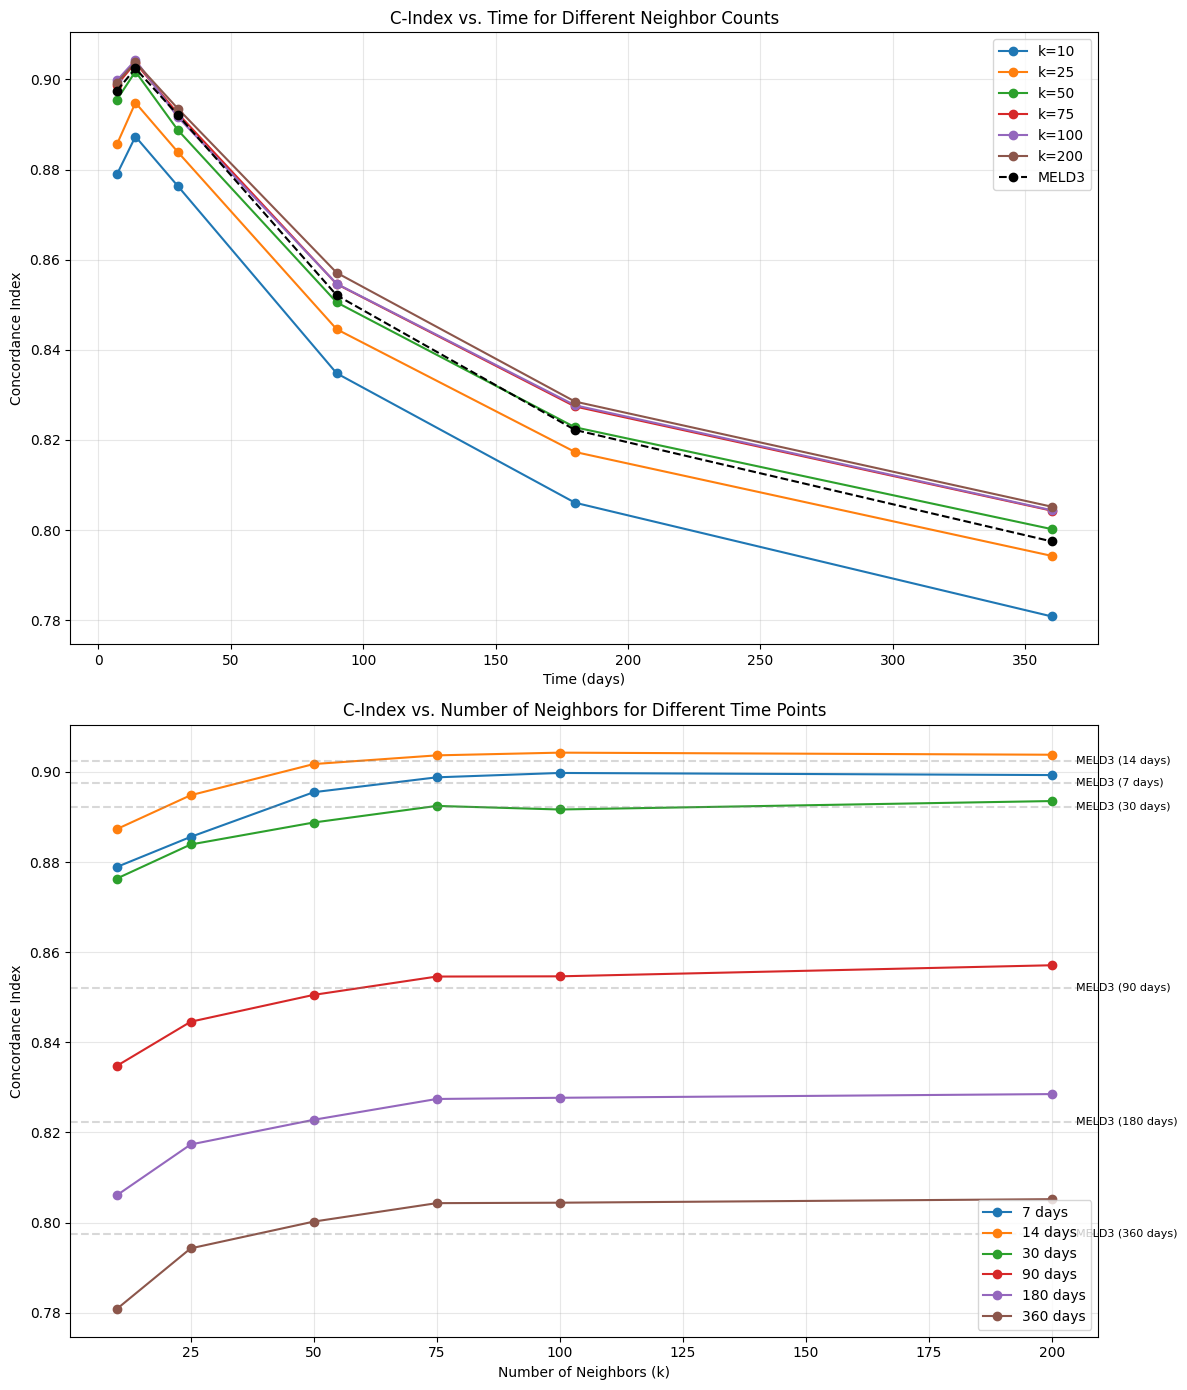

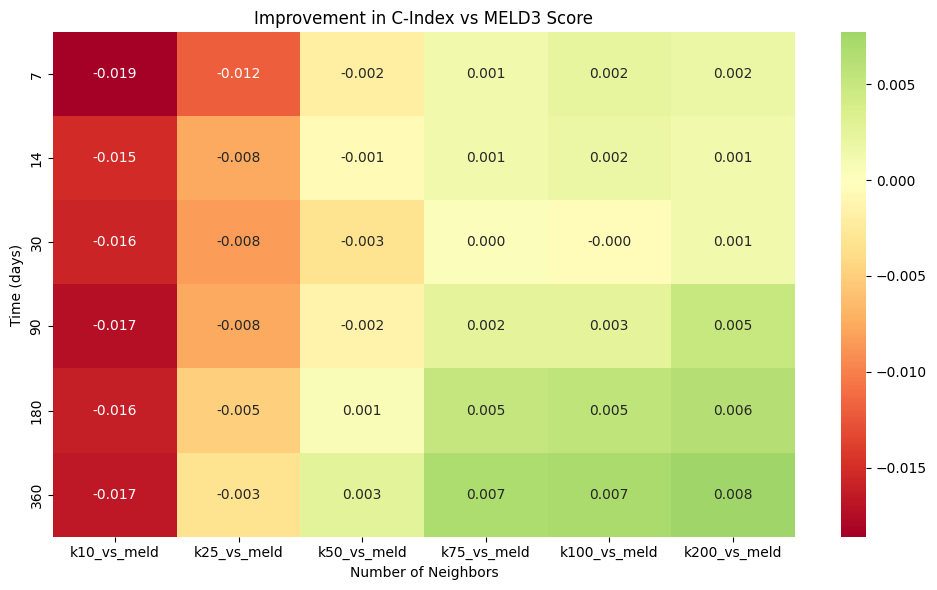


Optimal Number of Neighbors for Each Time Point:
             best_k  best_c_index  meld3_c_index  improvement
Time (days)                                                  
7             100.0         0.900          0.898        0.002
14            100.0         0.904          0.902        0.002
30            200.0         0.894          0.892        0.001
90            200.0         0.857          0.852        0.005
180           200.0         0.829          0.822        0.006
360           200.0         0.805          0.797        0.008


In [45]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Define time points for analysis
time_points = [7, 14, 30, 90, 180, 360]
neighbor_sizes = [10, 25, 50, 75, 100, 200]

# Function to prepare survival data
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.
    """
    analysis_df = df.copy()
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Compare concordance indices for different numbers of neighbors
def compare_neighbor_concordance(real_df):
    # Use 'meld3' directly instead of searching
    meld_col = 'meld3'

    if meld_col not in real_df.columns:
        raise ValueError(f"'{meld_col}' column not found in the dataframe")

    print(f"Using {meld_col} as the MELD score column")

    # Dictionary to store all results
    all_results = {}

    # Run analysis for each time point
    for t in time_points:
        print(f"Analyzing time point: {t} days")
        # Prepare survival data for the current time point
        analysis_df = prepare_survival_data(real_df, max_time=t)

        time_results = {}

        # Get c-index for MELD (baseline)
        cph_meld = CoxPHFitter()
        data_meld = analysis_df[['tte', 'death_event', meld_col]].copy()
        cph_meld.fit(data_meld, duration_col='tte', event_col='death_event', show_progress=False)
        time_results['meld'] = cph_meld.concordance_index_

        # Get c-index for each neighbor size
        for k in neighbor_sizes:
            col_name = f'predicted_death_tte_k{k}'
            if col_name not in analysis_df.columns:
                print(f"Warning: Column {col_name} not found, skipping")
                continue

            # Model using predictions from k neighbors
            cph_k = CoxPHFitter()
            data_k = analysis_df[['tte', 'death_event', col_name]].copy()
            cph_k.fit(data_k, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'k{k}'] = cph_k.concordance_index_

            # Combined model (predictions + MELD)
            cph_combined = CoxPHFitter()
            data_combined = analysis_df[['tte', 'death_event', col_name, meld_col]].copy()
            cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'k{k}+meld'] = cph_combined.concordance_index_

        all_results[t] = time_results

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(all_results).T
    results_df.index.name = 'Time'
    results_df.reset_index(inplace=True)

    return results_df

# Run the comparison and create visualizations
try:
    # Run the comparison analysis
    concordance_results = compare_neighbor_concordance(real_df)

    # Print tabular results
    print("\nConcordance Indices by Time Point and Neighbor Count:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(concordance_results.round(3))

    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # Plot 1: C-index vs time for different neighbor counts
    ax1 = axes[0]
    for k in neighbor_sizes:
        if f'k{k}' in concordance_results.columns:
            ax1.plot(concordance_results['Time'], concordance_results[f'k{k}'], marker='o', label=f'k={k}')
    ax1.plot(concordance_results['Time'], concordance_results['meld'], marker='o', linestyle='--', color='black', label='MELD3')
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Concordance Index')
    ax1.set_title('C-Index vs. Time for Different Neighbor Counts')
    ax1.grid(alpha=0.3)
    ax1.legend()

    # Plot 2: C-index vs neighbor count for different time points
    ax2 = axes[1]
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        k_values = []
        ks = []
        for k in neighbor_sizes:
            if f'k{k}' in row.columns and not pd.isna(row[f'k{k}'].iloc[0]):
                k_values.append(row[f'k{k}'].iloc[0])
                ks.append(k)
        if k_values:
            ax2.plot(ks, k_values, marker='o', label=f'{t} days')

    # Add MELD reference lines
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        meld_value = row['meld'].iloc[0]
        ax2.axhline(y=meld_value, linestyle='--', alpha=0.3, color='gray')
        ax2.text(max(neighbor_sizes) + 5, meld_value, f'MELD3 ({t} days)', fontsize=8, va='center')

    ax2.set_xlabel('Number of Neighbors (k)')
    ax2.set_ylabel('Concordance Index')
    ax2.set_title('C-Index vs. Number of Neighbors for Different Time Points')
    ax2.grid(alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.savefig('c_index_comparison.png', dpi=300)
    plt.show()

    # Create heatmap of improvement over MELD3
    improvement_df = concordance_results.copy()
    for k in neighbor_sizes:
        if f'k{k}' in improvement_df.columns:
            improvement_df[f'k{k}_vs_meld'] = improvement_df[f'k{k}'] - improvement_df['meld']

    # Select improvement columns for heatmap
    heatmap_cols = [f'k{k}_vs_meld' for k in neighbor_sizes if f'k{k}_vs_meld' in improvement_df.columns]
    if heatmap_cols:
        heatmap_data = improvement_df[['Time'] + heatmap_cols]
        heatmap_data = heatmap_data.set_index('Time')

        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, fmt='.3f')
        plt.title('Improvement in C-Index vs MELD3 Score')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Time (days)')
        plt.tight_layout()
        plt.savefig('c_index_improvement_heatmap.png', dpi=300)
        plt.show()

    # Find optimal number of neighbors for each time point
    optimal_neighbors = {}
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        k_values = {}
        for k in neighbor_sizes:
            if f'k{k}' in row.columns and not pd.isna(row[f'k{k}'].iloc[0]):
                k_values[k] = row[f'k{k}'].iloc[0]

        if k_values:
            best_k = max(k_values, key=k_values.get)
            best_c = k_values[best_k]
            meld_c = row['meld'].iloc[0]
            optimal_neighbors[t] = {
                'best_k': best_k,
                'best_c_index': best_c,
                'meld3_c_index': meld_c,
                'improvement': best_c - meld_c
            }

    print("\nOptimal Number of Neighbors for Each Time Point:")
    optimal_df = pd.DataFrame(optimal_neighbors).T
    optimal_df.index.name = 'Time (days)'
    print(optimal_df.round(3))

except Exception as e:
    print(f"Error during analysis: {str(e)}")
    import traceback
    traceback.print_exc()

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

def brier_score_tte_vs_meld3(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k10', 'predicted_death_tte_k25',
              'predicted_death_tte_k50','predicted_death_tte_k75',
              'predicted_death_tte_k100','predicted_death_tte_k200'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    Calculate naive Brier scores at multiple time points for:
      - Each TTE column in tte_cols
      - MELD-3
    Compares 'death by day t' vs. predicted probability.

    Args:
        df (pd.DataFrame): Must contain:
          - outcome_col (0=death, 1=censored/waiting, 2=transplant, etc.)
          - tte_col (time to event)
          - each col in tte_cols for predicted TTE
          - meld_col for MELD-3
        time_points (list): Time horizons for analysis
        tte_cols (list): Column names for predicted TTEs
        meld_col (str): Column name for MELD-3
        outcome_col (str): The outcome column name
        tte_col (str): The time-to-event column name

    Returns:
        pd.DataFrame: Rows=each time t, columns= Brier scores & counts
    """
    # Copy data so we don't mutate
    df_all = df.copy()

    # We'll build a results table
    results = []

    # Precompute min/max for each TTE column (for naive 0..1 transform)
    tte_minmax = {}
    for c in tte_cols:
        valid_vals = df_all[c].dropna()
        if len(valid_vals)==0:
            raise ValueError(f"No valid predictions in {c}")
        tte_min, tte_max = valid_vals.min(), valid_vals.max()
        tte_minmax[c] = (tte_min, tte_max)

    # Also compute min/max for MELD-3
    meld_valid = df_all[meld_col].dropna()
    meld_min, meld_max = meld_valid.min(), meld_valid.max()

    for t in time_points:
        # 1) Subset: at risk => those who haven't died before t or died by t
        at_risk_mask = (
            (df_all[tte_col] >= t)
            | ((df_all[outcome_col] == 0) & (df_all[tte_col] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # 2) event indicator: 1 if death by day t, else 0
        event_indicator = (
            (df_at_risk[outcome_col] == 0) & (df_at_risk[tte_col] <= t)
        ).astype(int)

        # Check if we have both events and nonevents
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            # Brier score undefined if all 0 or all 1
            row = {
                'Time': t,
                'N_at_risk': len(df_at_risk),
                'N_events_by_t': int(event_indicator.sum())
            }
            # fill with None for each TTE col
            for c in tte_cols:
                row[f'Brier_{c}'] = None
            row['Brier_meld3'] = None
            results.append(row)
            continue

        # 3) Build naive prob for MELD3
        meld_vals = df_at_risk[meld_col]
        meld_prob = (meld_vals - meld_min) / (meld_max - meld_min + 1e-12)
        # clamp to [0,1]
        meld_prob = np.clip(meld_prob, 0, 1)

        # Brier for meld
        brier_meld = brier_score_loss(event_indicator, meld_prob)

        # Fill row
        row = {
            'Time': t,
            'N_at_risk': len(df_at_risk),
            'N_events_by_t': int(event_indicator.sum()),
            'Brier_meld3': brier_meld
        }

        # 4) For each TTE col, do naive transform => probability
        for c in tte_cols:
            tte_vals = df_at_risk[c].copy()
            # min/max
            tmin, tmax = tte_minmax[c]
            denom = (tmax - tmin) if (tmax > tmin) else 1e-12

            # Prob = 1 - (tte - tmin)/denom
            # => smaller tte => bigger prob
            prob_vals = 1 - (tte_vals - tmin)/denom
            prob_vals = np.clip(prob_vals, 0, 1)

            # Brier
            brier_val = brier_score_loss(event_indicator, prob_vals)
            row[f'Brier_{c}'] = brier_val

        results.append(row)

    return pd.DataFrame(results)

# Example usage:
df_results = brier_score_tte_vs_meld3(real_df)
print(df_results.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k10  Brier_predicted_death_tte_k25  Brier_predicted_death_tte_k50  Brier_predicted_death_tte_k75  Brier_predicted_death_tte_k100  Brier_predicted_death_tte_k200
0     7      12188            171       0.1053                         0.5912                         0.5653                         0.5730                         0.5701                          0.5723                          0.5729
1    14      10911            318       0.0904                         0.5455                         0.5169                         0.5248                         0.5217                          0.5238                          0.5246
2    30       9653            498       0.0821                         0.4957                         0.4665                         0.4739                         0.4701                          0.4723                          0.4726
3    90       7706            837       0.0886              

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

def brier_scores_with_transforms(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k10','predicted_death_tte_k25',
              'predicted_death_tte_k50','predicted_death_tte_k75',
              'predicted_death_tte_k100','predicted_death_tte_k200'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    Computes Brier scores at multiple time points for:
      - MELD-3 (naive scaling)
      - Each TTE column, *with 3 transforms*:
           (1) Exponential, (2) Sigmoid, (3) Linear
    For 'death=0' vs 'censor/transplant=non-death'.

    Args:
      df (pd.DataFrame): Must contain columns:
        - outcome_col (0=death, 1=censored/waiting, 2=transplant, etc.)
        - tte_col (time to event)
        - each col in tte_cols for predicted TTE
        - meld_col for MELD-3
      time_points (list of ints): Day horizons to check
      tte_cols (list of str): Names of TTE predictions
      meld_col (str): Column name for MELD-3
      outcome_col (str): Outcome column name
      tte_col (str): Time-to-event column name

    Returns:
      pd.DataFrame with rows for each time t, columns for Brier scores.
    """
    # We'll build a list of results, each row is a time t
    results = []

    # Precompute min & max for MELD-3 to do naive [0..1] scaling
    meld_vals = df[meld_col].dropna()
    meld_min, meld_max = meld_vals.min(), meld_vals.max()

    # Constants for transformations
    sigmoid_scale = 30.0  # Adjust if you want a different shape
    # linear uses cutoff=2*t, defined inside loop

    for t in time_points:
        # 1) define at-risk set: those not dead before t, or died by t
        at_risk_mask = (
            (df[tte_col] >= t)
            | ((df[outcome_col] == 0) & (df[tte_col] <= t))
        )
        df_at_risk = df[at_risk_mask].copy()

        # 2) event indicator: 1 if died by day t, else 0
        event_indicator = (
            (df_at_risk[outcome_col] == 0) & (df_at_risk[tte_col] <= t)
        ).astype(int)

        # Check if we have at least 1 event and at least 1 nonevent
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            row = {
                'Time': t,
                'N_at_risk': len(df_at_risk),
                'N_events_by_t': int(event_indicator.sum())
            }
            # Fill placeholders for meld
            row['Brier_meld3'] = None
            # Fill placeholders for each transform of TTE
            for c in tte_cols:
                row[f'Brier_{c}_exp'] = None
                row[f'Brier_{c}_sigmoid'] = None
                row[f'Brier_{c}_linear'] = None
            results.append(row)
            continue

        # 3) Build naive [0..1] prob for MELD
        meld_sub = df_at_risk[meld_col].copy().dropna()
        # If some rows are NaN, we must drop them from event_indicator as well
        common_index = meld_sub.index.intersection(event_indicator.index)
        meld_sub = meld_sub.loc[common_index]
        event_sub = event_indicator.loc[common_index]

        # min-max scale
        denom_meld = (meld_max - meld_min) if (meld_max > meld_min) else 1.0
        meld_prob = (meld_sub - meld_min) / denom_meld
        meld_prob = np.clip(meld_prob, 0, 1)

        brier_meld = brier_score_loss(event_sub, meld_prob)

        row = {
            'Time': t,
            'N_at_risk': len(df_at_risk),
            'N_events_by_t': int(event_indicator.sum()),
            'Brier_meld3': brier_meld
        }

        # 4) For each TTE col, do exponential / sigmoid / linear => Brier
        for c in tte_cols:
            tte_series = df_at_risk[c].copy().dropna()
            common_idx = tte_series.index.intersection(event_indicator.index)
            tte_series = tte_series.loc[common_idx]
            evt = event_indicator.loc[common_idx]

            if len(tte_series)==0:
                row[f'Brier_{c}_exp'] = None
                row[f'Brier_{c}_sigmoid'] = None
                row[f'Brier_{c}_linear'] = None
                continue

            # (a) Exponential
            # prob = exp(-TTE / t)
            prob_exp = np.exp(-tte_series / float(t))
            prob_exp = np.clip(prob_exp, 0, 1)
            brier_exp = brier_score_loss(evt, prob_exp)

            # (b) Sigmoid
            # prob = 1/(1 + exp((TTE - t)/scale))
            prob_sig = 1.0 / (1.0 + np.exp((tte_series - float(t))/sigmoid_scale))
            prob_sig = np.clip(prob_sig, 0, 1)
            brier_sig = brier_score_loss(evt, prob_sig)

            # (c) Linear
            # cutoff=2*t => prob= max(0, 1 - TTE/cutoff)
            cutoff = 2.0 * float(t)
            prob_lin = np.maximum(0, 1 - tte_series/cutoff)
            prob_lin = np.clip(prob_lin, 0, 1)
            brier_lin = brier_score_loss(evt, prob_lin)

            row[f'Brier_{c}_exp'] = brier_exp
            row[f'Brier_{c}_sigmoid'] = brier_sig
            row[f'Brier_{c}_linear'] = brier_lin

        results.append(row)

    return pd.DataFrame(results)


# Example usage:
results_df = brier_scores_with_transforms(real_df)
print(results_df.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k10_exp  Brier_predicted_death_tte_k10_sigmoid  Brier_predicted_death_tte_k10_linear  Brier_predicted_death_tte_k25_exp  Brier_predicted_death_tte_k25_sigmoid  Brier_predicted_death_tte_k25_linear  Brier_predicted_death_tte_k50_exp  Brier_predicted_death_tte_k50_sigmoid  Brier_predicted_death_tte_k50_linear  Brier_predicted_death_tte_k75_exp  Brier_predicted_death_tte_k75_sigmoid  Brier_predicted_death_tte_k75_linear  Brier_predicted_death_tte_k100_exp  Brier_predicted_death_tte_k100_sigmoid  Brier_predicted_death_tte_k100_linear  Brier_predicted_death_tte_k200_exp  Brier_predicted_death_tte_k200_sigmoid  Brier_predicted_death_tte_k200_linear
0     7      12188            171       0.1053                             0.0166                                 0.0347                                0.0207                             0.0141                                 0.0304                                0.0163     

In [48]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss

def isotonic_calibration_brier(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k10','predicted_death_tte_k25',
              'predicted_death_tte_k50','predicted_death_tte_k75',
              'predicted_death_tte_k100','predicted_death_tte_k200'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    For each horizon t, do:
      1) define event=1 if death by t, else 0
      2) subset to at-risk
      3) for each TTE col:
         - invert TTE -> ensure bigger X => bigger risk
         - fit IsotonicRegression on (X, event)
         - transform X -> iso_prob
         - compute Brier
      4) Compare to naive MELD transform (optional)

    NOTE: This fits isotonic on the same data it evaluates,
          which can be over-optimistic.
          Use train/test splits for a realistic measure.
    """
    results = []

    # Precompute min/max for MELD-3 if you want a naive [0..1] transform
    # (You could skip if you only want to do isotonic on TTE.)
    meld_vals = df[meld_col].dropna()
    meld_min, meld_max = meld_vals.min(), meld_vals.max()
    denom_meld = (meld_max - meld_min) if (meld_max>meld_min) else 1.0

    for t in time_points:
        # 1) define at-risk set
        #    keep those who have not died before t, or died by t
        at_risk_mask = (
            (df[tte_col] >= t)
            | ((df[outcome_col] == 0) & (df[tte_col] <= t))
        )
        sub_df = df[at_risk_mask].copy()

        # event=1 if died by day t
        event_indicator = (
            (sub_df[outcome_col] == 0) & (sub_df[tte_col] <= t)
        ).astype(int)

        # if all 1 or all 0 => Brier undefined
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            row = {
                'Time': t,
                'N_at_risk': len(sub_df),
                'N_events_by_t': int(event_indicator.sum())
            }
            # fill TTE columns with None
            for c in tte_cols:
                row[f'Brier_{c}_iso'] = None
            # optional meld
            row['Brier_meld3'] = None
            results.append(row)
            continue

        row = {
            'Time': t,
            'N_at_risk': len(sub_df),
            'N_events_by_t': int(event_indicator.sum())
        }

        # (Optional) compute naive meld brier
        meld_sub = sub_df[meld_col].dropna()
        idx_common = meld_sub.index.intersection(event_indicator.index)
        meld_sub = meld_sub.loc[idx_common]
        event_sub = event_indicator.loc[idx_common]
        meld_prob = (meld_sub - meld_min)/denom_meld
        meld_prob = np.clip(meld_prob,0,1)
        brier_meld = brier_score_loss(event_sub, meld_prob)
        row['Brier_meld3'] = brier_meld

        # 2) for each TTE col => do isotonic
        for c in tte_cols:
            tte_ser = sub_df[c].dropna()
            idx2 = tte_ser.index.intersection(event_indicator.index)
            tte_ser = tte_ser.loc[idx2]
            evt = event_indicator.loc[idx2]

            if len(tte_ser)==0:
                row[f'Brier_{c}_iso'] = None
                continue

            # We want "larger X => higher risk" for isotonic
            # but TTE is "shorter => higher risk"
            # so we can invert TTE by negative or 1/TTE
            # simplest approach: X = - TTE
            X = -tte_ser.values  # bigger => higher risk
            Y = evt.values       # 0 or 1

            # Fit isotonic on (X, Y)
            iso = IsotonicRegression(out_of_bounds='clip')
            iso.fit(X, Y)

            # Transform
            iso_probs = iso.predict(X)

            # Brier
            brier_iso = brier_score_loss(Y, iso_probs)
            row[f'Brier_{c}_iso'] = brier_iso

        results.append(row)

    return pd.DataFrame(results)


# EXAMPLE usage:
iso_results = isotonic_calibration_brier(real_df)
print(iso_results.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k10_iso  Brier_predicted_death_tte_k25_iso  Brier_predicted_death_tte_k50_iso  Brier_predicted_death_tte_k75_iso  Brier_predicted_death_tte_k100_iso  Brier_predicted_death_tte_k200_iso
0     7      12188            171       0.1053                             0.0126                             0.0123                             0.0123                             0.0123                              0.0122                              0.0122
1    14      10911            318       0.0904                             0.0220                             0.0213                             0.0208                             0.0206                              0.0207                              0.0208
2    30       9653            498       0.0821                             0.0325                             0.0307                             0.0300                             0.0297                              0.0297 

In [52]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression

def add_isotonic_90days_k200(df,
                             t=90,
                             tte_col='predicted_death_tte_k200',
                             outcome_col='outcome',
                             event_col_name='risk_k200_iso_90'):
    """
    Adds a new column to df: 'risk_k100_iso_90', which is the isotonic-calibrated
    probability of death by day t=90 for the TTE predictions in 'tte_col' (k=100).

    NOTE: This is an in-sample fit. For real usage, you'd do train/test splits.
    """

    # 1) Work on a copy for the subset to fit isotonic
    df_iso = df.copy()

    # Create event=1 if outcome=0 (death) AND TTE <= 90, else 0
    df_iso['death_event_90'] = ((df_iso[outcome_col] == 0) & (df_iso['tte'] <= t)).astype(int)

    # Censor: If TTE > 90 => set TTE=90 => event=0
    # (So we align with 'death by day 90' labeling)
    mask_censor = df_iso['tte'] > t
    df_iso.loc[mask_censor, 'tte'] = t
    df_iso.loc[mask_censor, 'death_event_90'] = 0

    # We only want rows that have a valid TTE prediction
    # (some might be NaN if no neighbors)
    # But we also want to keep track so we can do iso.predict(...) for them
    valid_mask = df_iso[tte_col].notna()

    # 2) For isotonic, we need "bigger X => bigger risk."
    # TTE is "shorter => bigger risk," so we invert TTE, e.g. X = - TTE.
    # However, we also want to keep the "in-sample" approach consistent:
    # We'll fit iso only on the subset of patients we have event info for.
    df_iso['X'] = -df_iso[tte_col]

    # 3) Fit isotonic on that subset
    # We'll drop rows with missing X, or missing event
    iso_fit_mask = valid_mask & df_iso['X'].notna() & df_iso['death_event_90'].notna()

    fit_X = df_iso.loc[iso_fit_mask, 'X'].values
    fit_Y = df_iso.loc[iso_fit_mask, 'death_event_90'].values

    if len(fit_X) == 0:
        print("No valid data to fit isotonic. Exiting.")
        df[event_col_name] = np.nan
        return df

    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(fit_X, fit_Y)

    # 4) Transform ALL patients with a valid TTE into an iso probability
    # (some might not be in the at-risk subset, but we can still produce a probability)
    # We'll store them in a new column in the original df

    # Initialize column to NaN
    df[event_col_name] = np.nan

    # For those with valid TTE, apply iso
    all_valid_indices = df_iso.index[valid_mask]
    X_all = df_iso.loc[all_valid_indices, 'X'].values  # the -TTE
    iso_probs_all = iso.predict(X_all)

    # Put them back into df
    df.loc[all_valid_indices, event_col_name] = iso_probs_all

    print(f"Added column '{event_col_name}' with isotonic probabilities for 90-day death.")
    return df


In [53]:
real_df = add_isotonic_90days_k200(
    real_df,  # your dataset
    t=90,
    tte_col='predicted_death_tte_k200',
    outcome_col='outcome',
    event_col_name='risk_k200_iso_90'
)

# Now real_df has a new column 'risk_k100_iso_90' which is the
# in-sample isotonic-calibrated probability that the patient dies by day 90.


Added column 'risk_k200_iso_90' with isotonic probabilities for 90-day death.


In [54]:
print(real_df[['predicted_death_tte_k100','risk_k200_iso_90','outcome','tte']].sample(10))


       predicted_death_tte_k100  risk_k200_iso_90  outcome   tte
4326                  16.869288          0.111570        2     3
13452                167.644658          0.062696        2   295
4202                2077.115122          0.013514        1  1923
3591                1093.071809          0.014222        2     4
8451                 293.455571          0.048880        2    45
5013                  29.015957          0.111570        0    36
9774                 276.000813          0.048880        1   886
9330                 591.420380          0.035461        2   164
13392                161.220351          0.070000        2    10
14434                373.415315          0.035794        0   487


In [55]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

def c_index_90_transformed(df,
                           risk_col="risk_k200_iso_90",  # your isotonic or other transform col
                           meld_col="meld3",
                           outcome_col="outcome",
                           tte_col="tte",
                           horizon=90):
    """
    Compare Harrell's C-index at 90 days for:
      1) Transformed risk_col (bigger => higher risk),
      2) MELD-3.

    We create a 90-day subset:
     - Censor those who survive beyond 90 days at day 90
     - Event=1 if outcome=0 & tte <= 90.
    """

    data_90 = df.copy()

    # 1) Mark events (death by day 90)
    data_90['death_event'] = ((data_90[outcome_col]==0) & (data_90[tte_col] <= horizon)).astype(int)

    # 2) Censor if tte > 90
    data_90.loc[data_90[tte_col] > horizon, tte_col] = horizon
    data_90.loc[data_90[tte_col] == horizon, 'death_event'] = 0  # ensure they're censored if they survive to day 90

    # We'll do a small helper for c-index using a Cox model on each predictor:
    cph_risk = CoxPHFitter()
    sub_risk = data_90[[tte_col, 'death_event', risk_col]].dropna()
    cph_risk.fit(sub_risk, duration_col=tte_col, event_col='death_event', show_progress=False)
    c_index_risk = cph_risk.concordance_index_

    cph_meld = CoxPHFitter()
    sub_meld = data_90[[tte_col, 'death_event', meld_col]].dropna()
    cph_meld.fit(sub_meld, duration_col=tte_col, event_col='death_event', show_progress=False)
    c_index_meld = cph_meld.concordance_index_

    print(f"\n--- Harrell’s C-index at {horizon} days ---")
    print(f"{risk_col}: {c_index_risk:.4f}")
    print(f"{meld_col}: {c_index_meld:.4f}")
    print(f"Difference: {(c_index_risk - c_index_meld):.4f}")

    return c_index_risk, c_index_meld
# Suppose you have real_df with columns:
#   - outcome, tte, meld3
#   - risk_k100_iso_90 (the isotonic or other transform for k=100 at 90 days)
c_risk, c_meld = c_index_90_transformed(real_df)



--- Harrell’s C-index at 90 days ---
risk_k200_iso_90: 0.8594
meld3: 0.8527
Difference: 0.0067


In [58]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index

def direct_cindex_at_90(df,
                        risk_col="risk_k200_iso_90",
                        meld_col="meld3",
                        outcome_col="outcome",
                        tte_col="tte",
                        horizon=90):
    """
    Compute c-index at 90 days for 'risk_col' & 'meld_col'
    WITHOUT re-fitting any Cox model. We do direct c-index from lifelines.utils.
    """
    data_90 = df.copy()

    # Label event=1 if death <= 90, else 0
    data_90['event_90'] = ((data_90[outcome_col] == 0) & (data_90[tte_col] <= horizon)).astype(int)
    # times_90 = min(tte, 90)
    data_90['time_90'] = np.minimum(data_90[tte_col], horizon)

    # Drop rows missing risk or meld
    needed_cols = ['time_90','event_90', risk_col, meld_col]
    data_90 = data_90[needed_cols].dropna()
    if data_90.empty:
        raise ValueError("No valid rows after dropping missing data for direct c-index at 90.")

    # c-index for risk_col - FIXED: using negative of risk score
    c_risk = concordance_index(
        data_90['time_90'],
        -data_90[risk_col],  # Negate the risk score
        data_90['event_90']
    )
    # c-index for meld_col - FIXED: using negative of meld score
    c_meld = concordance_index(
        data_90['time_90'],
        -data_90[meld_col],  # Negate the meld score
        data_90['event_90']
    )

    return c_risk, c_meld


def bootstrap_direct_cindex_90(df,
                               risk_col="risk_k200_iso_90",
                               meld_col="meld3",
                               outcome_col="outcome",
                               tte_col="tte",
                               horizon=90,
                               n_bootstraps=500,
                               random_state=42):
    """
    Bootstrap the difference in c-index at day 90 using direct lifelines.utils.concordance_index
    (no repeated CoxPH fits).

    Return distribution of (c_risk, c_meld, diff).
    """
    np.random.seed(random_state)

    # 1) Prepare the main subset
    df_90 = df.copy()
    df_90['event_90'] = ((df_90[outcome_col]==0) & (df_90[tte_col] <= horizon)).astype(int)
    df_90['time_90'] = np.minimum(df_90[tte_col], horizon)
    needed = ['time_90','event_90', risk_col, meld_col]
    df_90 = df_90[needed].dropna()
    if df_90.empty:
        raise ValueError("No valid data after dropping NAs for direct c-index bootstrapping.")

    # 2) Full-sample c-index - FIXED: using negative of risk scores
    c_risk_full = concordance_index(df_90['time_90'], -df_90[risk_col], df_90['event_90'])
    c_meld_full = concordance_index(df_90['time_90'], -df_90[meld_col], df_90['event_90'])
    orig_diff = c_risk_full - c_meld_full

    # 3) Bootstrapping
    n = len(df_90)
    c_risk_boot = []
    c_meld_boot = []
    for _ in range(n_bootstraps):
        sample_idx = np.random.randint(0, n, size=n)
        df_boot = df_90.iloc[sample_idx]

        # c-index for risk - FIXED: using negative of risk score
        c_risk_b = concordance_index(df_boot['time_90'],
                                     -df_boot[risk_col],
                                     df_boot['event_90'])
        # c-index for meld - FIXED: using negative of meld score
        c_meld_b = concordance_index(df_boot['time_90'],
                                     -df_boot[meld_col],
                                     df_boot['event_90'])

        c_risk_boot.append(c_risk_b)
        c_meld_boot.append(c_meld_b)

    c_risk_boot = np.array(c_risk_boot)
    c_meld_boot = np.array(c_meld_boot)
    diff_boot = c_risk_boot - c_meld_boot

    # 4) Confidence intervals
    ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
    ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
    ci_diff = np.percentile(diff_boot, [2.5, 97.5])

    # 5) Two-sided p-value for diff=0
    if orig_diff >= 0:
        p_one_sided = np.mean(diff_boot < 0)
    else:
        p_one_sided = np.mean(diff_boot > 0)
    p_value = min(2 * p_one_sided, 1.0)

    # Return
    return {
        'c_risk_full': c_risk_full,
        'c_meld_full': c_meld_full,
        'orig_diff': orig_diff,
        'c_risk_boot': c_risk_boot,
        'c_meld_boot': c_meld_boot,
        'diff_boot': diff_boot,
        'ci_risk': ci_risk,
        'ci_meld': ci_meld,
        'ci_diff': ci_diff,
        'p_value': p_value
    }


def show_bootstrap_results(res):
    """
    Nicely print the bootstrap results from above function.
    """
    print("\n--- Direct Concordance Index at 90 days (Bootstrap) ---")
    print(f"risk_col c-index: {res['c_risk_full']:.4f}   (95% CI: [{res['ci_risk'][0]:.4f}, {res['ci_risk'][1]:.4f}])")
    print(f"meld_col c-index: {res['c_meld_full']:.4f}   (95% CI: [{res['ci_meld'][0]:.4f}, {res['ci_meld'][1]:.4f}])")
    print(f"Difference:       {res['orig_diff']:.4f}   (95% CI: [{res['ci_diff'][0]:.4f}, {res['ci_diff'][1]:.4f}])")
    print(f"p-value (2-sided): {res['p_value']:.4f}")

In [59]:
# 1) Direct c-index on full data (no bootstrap)
c_risk, c_meld = direct_cindex_at_90(real_df,
                                     risk_col="risk_k200_iso_90",
                                     meld_col="meld3")

print(f"\n*** 90-day c-index ***")
print(f"risk_k200_iso_90: {c_risk:.4f}")
print(f"meld3: {c_meld:.4f}")
print(f"Difference: {c_risk - c_meld:.4f}")

# 2) Bootstrap
res = bootstrap_direct_cindex_90(real_df,
                                 risk_col="risk_k200_iso_90",
                                 meld_col="meld3",
                                 n_bootstraps=1000)

show_bootstrap_results(res)



*** 90-day c-index ***
risk_k200_iso_90: 0.8590
meld3: 0.8521
Difference: 0.0069

--- Direct Concordance Index at 90 days (Bootstrap) ---
risk_col c-index: 0.8590   (95% CI: [0.8456, 0.8706])
meld_col c-index: 0.8521   (95% CI: [0.8387, 0.8637])
Difference:       0.0069   (95% CI: [0.0018, 0.0120])
p-value (2-sided): 0.0060



*** Time-Dependent C-index Results ***
   horizon  c_risk_k200_iso_90   c_meld3  difference  n_patients  n_events
0        7            0.898597  0.897521    0.001076       14632       171
1       14            0.903591  0.902444    0.001148       14632       318
2       30            0.893391  0.892140    0.001251       14632       498
3       90            0.858967  0.852104    0.006863       14632       837
4      180            0.829154  0.822225    0.006928       14632      1139
5      360            0.805377  0.797494    0.007883       14632      1533
Bootstrapping horizon: 7 days
Bootstrapping horizon: 14 days
Bootstrapping horizon: 30 days
Bootstrapping horizon: 90 days
Bootstrapping horizon: 180 days
Bootstrapping horizon: 360 days

=== Time-Dependent Concordance Index (Bootstrap) ===


--- 7.0-day Concordance Index ---
Patients: 14632.0, Events: 171.0 (1.2% event rate)
risk_k200_iso_90 c-index: 0.8986   (95% CI: [0.8796, 0.9158])
meld3 c-index: 0.8975   (95% CI: [0.8757, 0.9

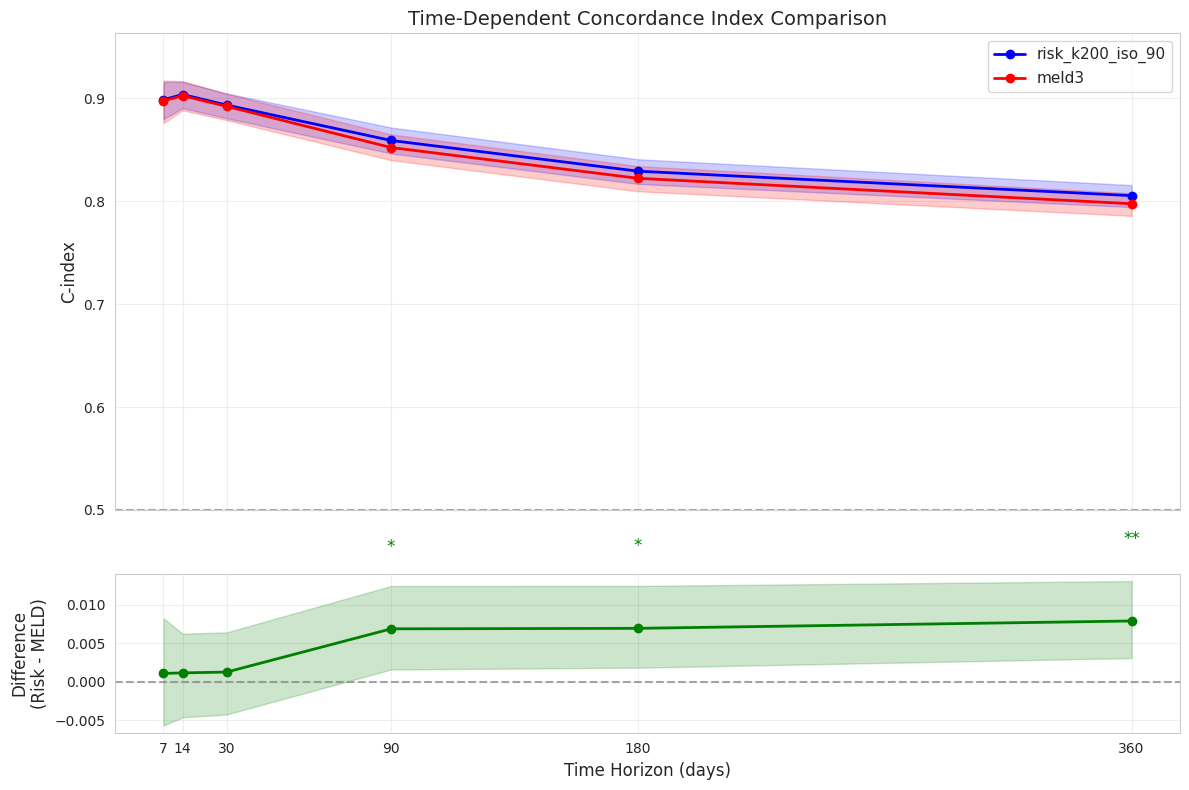

In [71]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

def direct_cindex_at_horizons(df,
                             risk_col="risk_k200_iso_90",
                             meld_col="meld3",
                             outcome_col="outcome",
                             tte_col="tte",
                             horizons=[7, 14, 30, 90, 180, 360]):
    """
    Compute c-index at multiple horizons for 'risk_col' & 'meld_col'
    WITHOUT re-fitting any Cox model. We do direct c-index from lifelines.utils.

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate

    Returns:
        DataFrame with c-index results for each horizon
    """
    results = []

    for horizon in horizons:
        data_t = df.copy()

        # Label event=1 if death <= horizon, else 0
        data_t['event_t'] = ((data_t[outcome_col] == 0) & (data_t[tte_col] <= horizon)).astype(int)
        # times_t = min(tte, horizon)
        data_t['time_t'] = np.minimum(data_t[tte_col], horizon)

        # Drop rows missing risk or meld
        needed_cols = ['time_t', 'event_t', risk_col, meld_col]
        data_t = data_t[needed_cols].dropna()

        if data_t.empty:
            print(f"Warning: No valid rows after dropping missing data for horizon {horizon}.")
            c_risk = c_meld = np.nan
        else:
            # Count events for reporting
            n_patients = len(data_t)
            n_events = data_t['event_t'].sum()

            # c-index for risk_col - using negative of risk score
            c_risk = concordance_index(
                data_t['time_t'],
                -data_t[risk_col],  # Negate the risk score
                data_t['event_t']
            )
            # c-index for meld_col - using negative of meld score
            c_meld = concordance_index(
                data_t['time_t'],
                -data_t[meld_col],  # Negate the meld score
                data_t['event_t']
            )

        results.append({
            'horizon': horizon,
            f'c_{risk_col}': c_risk,
            f'c_{meld_col}': c_meld,
            'difference': c_risk - c_meld if not np.isnan(c_risk) and not np.isnan(c_meld) else np.nan,
            'n_patients': n_patients if 'n_patients' in locals() else 0,
            'n_events': n_events if 'n_events' in locals() else 0
        })

    return pd.DataFrame(results)


def bootstrap_direct_cindex_at_horizons(df,
                                      risk_col="risk_k200_iso_90",
                                      meld_col="meld3",
                                      outcome_col="outcome",
                                      tte_col="tte",
                                      horizons=[7, 14, 30, 90, 180, 360],
                                      n_bootstraps=500,
                                      random_state=42):
    """
    Bootstrap the difference in c-index at multiple horizons using direct
    lifelines.utils.concordance_index (no repeated CoxPH fits).

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate
        n_bootstraps: Number of bootstrap samples
        random_state: Random seed for reproducibility

    Returns:
        DataFrame with bootstrap results for each horizon
    """
    np.random.seed(random_state)
    results = []

    for horizon in horizons:
        print(f"Bootstrapping horizon: {horizon} days")

        # 1) Prepare the main subset
        df_t = df.copy()
        df_t['event_t'] = ((df_t[outcome_col]==0) & (df_t[tte_col] <= horizon)).astype(int)
        df_t['time_t'] = np.minimum(df_t[tte_col], horizon)
        needed = ['time_t', 'event_t', risk_col, meld_col]
        df_t = df_t[needed].dropna()

        if df_t.empty:
            print(f"Warning: No valid data after dropping NAs for horizon {horizon}.")
            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': np.nan,
                f'c_{meld_col}_full': np.nan,
                'orig_diff': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan,
                'n_patients': 0,
                'n_events': 0
            }
        else:
            # 2) Full-sample c-index - using negative of risk scores
            c_risk_full = concordance_index(df_t['time_t'], -df_t[risk_col], df_t['event_t'])
            c_meld_full = concordance_index(df_t['time_t'], -df_t[meld_col], df_t['event_t'])
            orig_diff = c_risk_full - c_meld_full

            # Count patients and events
            n_patients = len(df_t)
            n_events = df_t['event_t'].sum()

            # 3) Bootstrapping
            n = len(df_t)
            c_risk_boot = []
            c_meld_boot = []

            for _ in range(n_bootstraps):
                sample_idx = np.random.randint(0, n, size=n)
                df_boot = df_t.iloc[sample_idx]

                # Skip bootstrap samples with no events or all events
                if df_boot['event_t'].sum() == 0 or df_boot['event_t'].sum() == len(df_boot):
                    continue

                # c-index for risk - using negative of risk score
                c_risk_b = concordance_index(df_boot['time_t'],
                                           -df_boot[risk_col],
                                           df_boot['event_t'])
                # c-index for meld - using negative of meld score
                c_meld_b = concordance_index(df_boot['time_t'],
                                           -df_boot[meld_col],
                                           df_boot['event_t'])

                c_risk_boot.append(c_risk_b)
                c_meld_boot.append(c_meld_b)

            c_risk_boot = np.array(c_risk_boot)
            c_meld_boot = np.array(c_meld_boot)
            diff_boot = c_risk_boot - c_meld_boot

            # 4) Confidence intervals
            ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
            ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
            ci_diff = np.percentile(diff_boot, [2.5, 97.5])

            # 5) Two-sided p-value for diff=0
            if orig_diff >= 0:
                p_one_sided = np.mean(diff_boot < 0)
            else:
                p_one_sided = np.mean(diff_boot > 0)
            p_value = min(2 * p_one_sided, 1.0)

            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': c_risk_full,
                f'c_{meld_col}_full': c_meld_full,
                'orig_diff': orig_diff,
                'ci_risk_lower': ci_risk[0],
                'ci_risk_upper': ci_risk[1],
                'ci_meld_lower': ci_meld[0],
                'ci_meld_upper': ci_meld[1],
                'ci_diff_lower': ci_diff[0],
                'ci_diff_upper': ci_diff[1],
                'p_value': p_value,
                'n_patients': n_patients,
                'n_events': n_events
            }

        results.append(result)

    return pd.DataFrame(results)


def show_bootstrap_results_at_horizons(bootstrap_results, risk_col="risk_k200_iso_90", meld_col="meld3"):
    """
    Nicely print the bootstrap results from all horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
    """
    print("\n=== Time-Dependent Concordance Index (Bootstrap) ===\n")

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']
        print(f"\n--- {horizon}-day Concordance Index ---")
        print(f"Patients: {row['n_patients']}, Events: {row['n_events']} " +
              f"({row['n_events']/row['n_patients']*100:.1f}% event rate)")

        # Risk score c-index
        risk_name = f'c_{risk_col}_full'
        if not pd.isna(row[risk_name]):
            print(f"{risk_col} c-index: {row[risk_name]:.4f}   " +
                  f"(95% CI: [{row['ci_risk_lower']:.4f}, {row['ci_risk_upper']:.4f}])")
        else:
            print(f"{risk_col} c-index: N/A (insufficient data)")

        # MELD score c-index
        meld_name = f'c_{meld_col}_full'
        if not pd.isna(row[meld_name]):
            print(f"{meld_col} c-index: {row[meld_name]:.4f}   " +
                  f"(95% CI: [{row['ci_meld_lower']:.4f}, {row['ci_meld_upper']:.4f}])")
        else:
            print(f"{meld_col} c-index: N/A (insufficient data)")

        # Difference
        if not pd.isna(row['orig_diff']):
            print(f"Difference:       {row['orig_diff']:.4f}   " +
                  f"(95% CI: [{row['ci_diff_lower']:.4f}, {row['ci_diff_upper']:.4f}])")

            # Add significance indicators
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            print(f"p-value (2-sided): {row['p_value']:.4f} {sig}")
        else:
            print("Difference: N/A (insufficient data)")


def plot_cindex_over_time(bootstrap_results, risk_col="risk_k200_iso_90", meld_col="meld3",
                          figsize=(12, 8), save_path=None):
    """
    Plot c-index values and their differences over different time horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
        figsize: Figure size as tuple (width, height)
        save_path: Path to save the figure (optional)
    """
    risk_name = f'c_{risk_col}_full'
    meld_name = f'c_{meld_col}_full'

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True,
                                  gridspec_kw={'height_ratios': [3, 1]})

    # Plot c-indices with confidence intervals
    horizons = bootstrap_results['horizon'].values

    # Risk score
    risk_cindices = bootstrap_results[risk_name].values
    risk_lower = bootstrap_results['ci_risk_lower'].values
    risk_upper = bootstrap_results['ci_risk_upper'].values

    ax1.plot(horizons, risk_cindices, 'o-', label=risk_col, color='blue', linewidth=2)
    ax1.fill_between(horizons, risk_lower, risk_upper, alpha=0.2, color='blue')

    # MELD score
    meld_cindices = bootstrap_results[meld_name].values
    meld_lower = bootstrap_results['ci_meld_lower'].values
    meld_upper = bootstrap_results['ci_meld_upper'].values

    ax1.plot(horizons, meld_cindices, 'o-', label=meld_col, color='red', linewidth=2)
    ax1.fill_between(horizons, meld_lower, meld_upper, alpha=0.2, color='red')

    # Formatting for c-index plot
    ax1.set_ylabel('C-index', fontsize=12)
    ax1.set_title('Time-Dependent Concordance Index Comparison', fontsize=14)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.5, min(1.0, max(bootstrap_results['ci_risk_upper'].max(),
                                 bootstrap_results['ci_meld_upper'].max()) * 1.05))

    # Add reference line for random prediction
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Plot difference with confidence intervals
    diff_values = bootstrap_results['orig_diff'].values
    diff_lower = bootstrap_results['ci_diff_lower'].values
    diff_upper = bootstrap_results['ci_diff_upper'].values

    ax2.plot(horizons, diff_values, 'o-', color='green', linewidth=2)
    ax2.fill_between(horizons, diff_lower, diff_upper, alpha=0.2, color='green')

    # Add reference line at zero
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Add significance markers
    for i, p_value in enumerate(bootstrap_results['p_value']):
        if p_value < 0.05:
            marker = '*'
            if p_value < 0.01:
                marker = '**'
            if p_value < 0.001:
                marker = '***'

            y_pos = diff_values[i] + 0.01 if diff_values[i] > 0 else diff_values[i] - 0.02
            ax2.text(horizons[i], y_pos, marker, ha='center', fontsize=12, color='green')

    # Formatting for difference plot
    ax2.set_xlabel('Time Horizon (days)', fontsize=12)
    ax2.set_ylabel('Difference\n(Risk - MELD)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Set x-ticks to be exactly the time points
    plt.xticks(horizons, labels=horizons)

    # Adjust layout and save if requested
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


def create_cindex_table(bootstrap_results, risk_col="risk_k200_iso_90", meld_col="meld3"):
    """
    Create a formatted table of c-index results suitable for publication.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column

    Returns:
        pandas.DataFrame: Formatted table
    """
    # Prepare table columns
    table_data = []

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']

        # Format values with proper precision
        risk_name = f'c_{risk_col}_full'
        meld_name = f'c_{meld_col}_full'

        if pd.isna(row[risk_name]) or pd.isna(row[meld_name]):
            risk_ci = meld_ci = diff_ci = diff_p = "N/A"
        else:
            # Add significance markers
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            risk_ci = f"{row[risk_name]:.4f} ({row['ci_risk_lower']:.4f}-{row['ci_risk_upper']:.4f})"
            meld_ci = f"{row[meld_name]:.4f} ({row['ci_meld_lower']:.4f}-{row['ci_meld_upper']:.4f})"
            diff_ci = f"{row['orig_diff']:.4f} ({row['ci_diff_lower']:.4f}-{row['ci_diff_upper']:.4f})"
            diff_p = f"{row['p_value']:.4f}{sig}"

        table_data.append({
            'Horizon (days)': horizon,
            'Patients': row['n_patients'],
            'Events': row['n_events'],
            'Event Rate (%)': f"{row['n_events']/row['n_patients']*100:.1f}%" if row['n_patients'] > 0 else "N/A",
            f'{risk_col} C-index (95% CI)': risk_ci,
            f'{meld_col} C-index (95% CI)': meld_ci,
            'Difference (95% CI)': diff_ci,
            'p-value': diff_p
        })

    return pd.DataFrame(table_data)


# Example usage
if __name__ == "__main__":
    # List of time horizons to evaluate
    horizons = [7, 14, 30, 90, 180, 360]

    # 1) Direct c-index on full data (no bootstrap)
    cindex_results = direct_cindex_at_horizons(
        df=real_df,
        risk_col="risk_k200_iso_90",
        meld_col="meld3",
        horizons=horizons
    )
    print("\n*** Time-Dependent C-index Results ***")
    print(cindex_results)

    # 2) Bootstrap
    bootstrap_results = bootstrap_direct_cindex_at_horizons(
        df=real_df,
        risk_col="risk_k200_iso_90",
        meld_col="meld3",
        horizons=horizons,
        n_bootstraps=1000
    )

    # 3) Show results
    show_bootstrap_results_at_horizons(bootstrap_results)

    # 4) Plot results
    plot_cindex_over_time(bootstrap_results, save_path="cindex_over_time.png")

    # 5) Create publication-ready table
    table = create_cindex_table(bootstrap_results)
    print("\n*** Publication-Ready Table ***")
    print(table)
    # Optionally save to CSV
    # table.to_csv("cindex_results_table.csv", index=False)


TIME-DEPENDENT AUC FOR MORTALITY PREDICTION

------------------------------ 7-DAY MORTALITY ------------------------------
Patients: 12188.0, Deaths: 171.0 (1.4%)

meld3               : AUC = 0.9271 (95% CI: 0.9086-0.9440)
risk_k200_iso_90    : AUC = 0.9282 (95% CI: 0.9126-0.9424)

Pairwise Comparisons:
risk_k200_iso_90 > meld3 : Δ = 0.0011, p = 1.0000

------------------------------ 14-DAY MORTALITY ------------------------------
Patients: 10911.0, Deaths: 318.0 (2.9%)

meld3               : AUC = 0.9368 (95% CI: 0.9235-0.9481)
risk_k200_iso_90    : AUC = 0.9384 (95% CI: 0.9255-0.9501)

Pairwise Comparisons:
risk_k200_iso_90 > meld3 : Δ = 0.0016, p = 0.8420

------------------------------ 30-DAY MORTALITY ------------------------------
Patients: 9653.0, Deaths: 498.0 (5.2%)

meld3               : AUC = 0.9293 (95% CI: 0.9169-0.9419)
risk_k200_iso_90    : AUC = 0.9308 (95% CI: 0.9180-0.9434)

Pairwise Comparisons:
risk_k200_iso_90 > meld3 : Δ = 0.0016, p = 0.9120

--------------------

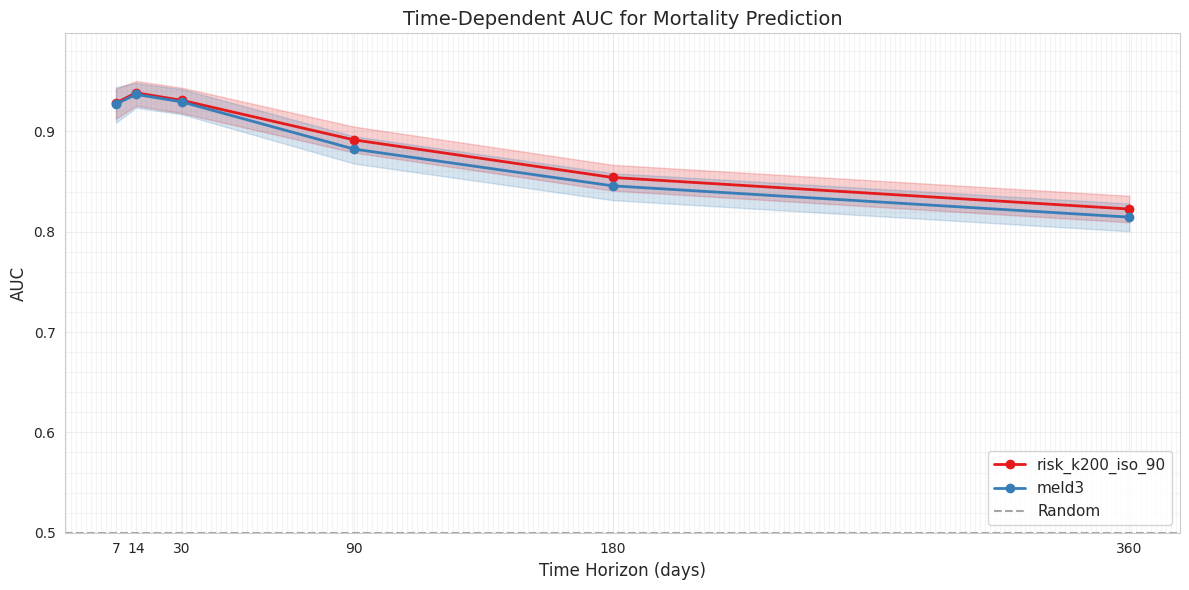

In [67]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import scipy.stats as stats

def time_dependent_auc_comparison(
    df,
    risk_cols=['risk_k200_iso_90', 'meld3'],
    outcome_col='outcome',
    tte_col='tte',
    time_points=[7, 14, 30, 90, 180, 360],
    bootstrap=True,
    n_bootstrap=1000,
    random_state=42
):
    """
    Compute time-dependent AUC for mortality prediction at various horizons,
    censoring for transplant and other non-death outcomes.

    Args:
        df (pd.DataFrame): Must contain:
            - tte_col: Time to event or censor
            - outcome_col: Outcome (0=death, 1=censoring, 2=transplant)
            - risk_cols: Risk score columns (higher => higher risk)
        risk_cols (list): Column names for risk scores
        outcome_col (str): Column name for outcome
        tte_col (str): Column name for time-to-event
        time_points (list): List of integer day horizons
        bootstrap (bool): Whether to perform bootstrap for CIs
        n_bootstrap (int): Number of bootstrap iterations
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: (results_df, p_values_df)
    """
    # Set random seed
    np.random.seed(random_state)

    # Ensure required columns exist
    required_cols = [tte_col, outcome_col] + risk_cols
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in dataframe.")

    results = []
    # Copy data to avoid modifying original
    df_all = df.copy()

    # For each time point
    for t in time_points:
        # 'At-risk' set: those who have sufficient follow-up
        # - If tte >= t => still followed at time t
        # - Or died by time t (outcome=0, tte <= t)
        at_risk_mask = (
            (df_all[tte_col] >= t) |
            ((df_all[outcome_col] == 0) & (df_all[tte_col] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # Define event indicator: 1 if died by time t, 0 otherwise
        event_mask = (
            (df_at_risk[outcome_col] == 0) &
            (df_at_risk[tte_col] <= t)
        )
        df_at_risk['event_indicator'] = event_mask.astype(int)

        # Calculate AUC for each risk model
        model_aucs = {}
        model_bootstrap_aucs = {}

        for risk_col in risk_cols:
            # Drop rows with missing risk scores
            model_data = df_at_risk[['event_indicator', risk_col]].dropna()

            if (model_data['event_indicator'].sum() > 0 and
                model_data['event_indicator'].sum() < len(model_data)):

                # Calculate AUC
                auc = roc_auc_score(model_data['event_indicator'], model_data[risk_col])
                model_aucs[risk_col] = auc

                # Bootstrap confidence intervals if requested
                if bootstrap:
                    bootstrap_aucs = []
                    n_samples = len(model_data)

                    for _ in range(n_bootstrap):
                        # Sample with replacement
                        bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
                        bootstrap_sample = model_data.iloc[bootstrap_indices]

                        # Skip if bootstrap sample has all events or no events
                        if (bootstrap_sample['event_indicator'].sum() == 0 or
                            bootstrap_sample['event_indicator'].sum() == len(bootstrap_sample)):
                            continue

                        bootstrap_auc = roc_auc_score(
                            bootstrap_sample['event_indicator'],
                            bootstrap_sample[risk_col]
                        )
                        bootstrap_aucs.append(bootstrap_auc)

                    model_bootstrap_aucs[risk_col] = bootstrap_aucs

                    # Calculate confidence intervals
                    if bootstrap_aucs:
                        lower_ci, upper_ci = np.percentile(bootstrap_aucs, [2.5, 97.5])
                    else:
                        lower_ci = upper_ci = np.nan
                else:
                    lower_ci = upper_ci = np.nan
            else:
                auc = lower_ci = upper_ci = np.nan
                model_bootstrap_aucs[risk_col] = []

            # Store results
            results.append({
                'time_point': t,
                'model': risk_col,
                'auc': auc,
                'lower_ci': lower_ci,
                'upper_ci': upper_ci,
                'n_patients': len(model_data),
                'n_events': model_data['event_indicator'].sum() if not model_data.empty else 0
            })

        # Calculate p-values for pairwise comparisons at this time point
        if bootstrap and len(risk_cols) > 1:
            for i, model_i in enumerate(risk_cols):
                for j, model_j in enumerate(risk_cols):
                    if i < j:  # Only compare each pair once
                        # Skip if either model has no bootstrap results
                        if not model_bootstrap_aucs[model_i] or not model_bootstrap_aucs[model_j]:
                            continue

                        # Calculate differences in bootstrap samples
                        diffs = np.array(model_bootstrap_aucs[model_i]) - np.array(model_bootstrap_aucs[model_j])

                        # Calculate actual AUC difference
                        actual_diff = model_aucs[model_i] - model_aucs[model_j]

                        # Calculate two-sided p-value
                        if actual_diff >= 0:
                            p_one_sided = np.mean(diffs <= 0)
                        else:
                            p_one_sided = np.mean(diffs >= 0)
                        p_value = min(2 * p_one_sided, 1.0)

                        # Store comparison results
                        results.append({
                            'time_point': t,
                            'model': f"{model_i}_vs_{model_j}",
                            'auc': actual_diff,  # Store the difference
                            'lower_ci': np.percentile(diffs, 2.5) if len(diffs) > 0 else np.nan,
                            'upper_ci': np.percentile(diffs, 97.5) if len(diffs) > 0 else np.nan,
                            'p_value': p_value,
                            'significant': p_value < 0.05
                        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Extract main AUC results and comparison results
    main_results = results_df[~results_df['model'].str.contains('_vs_')].copy()
    comparison_results = results_df[results_df['model'].str.contains('_vs_')].copy()

    return main_results, comparison_results


def plot_time_dependent_auc(results_df, models=None, figsize=(12, 6), save_path=None):
    """
    Plot time-dependent AUC with confidence intervals.

    Args:
        results_df (pd.DataFrame): Results from time_dependent_auc_comparison
        models (list, optional): Models to include (default: all)
        figsize (tuple): Figure size
        save_path (str, optional): Path to save the figure

    Returns:
        matplotlib.pyplot.Figure: The figure object
    """
    if models is None:
        models = results_df['model'].unique()

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    # Color palette
    colors = sns.color_palette("Set1", len(models))

    for i, model in enumerate(models):
        model_data = results_df[results_df['model'] == model]

        # Skip if empty
        if model_data.empty:
            continue

        # Sort by time point
        model_data = model_data.sort_values('time_point')

        # Plot AUC line
        plt.plot(model_data['time_point'], model_data['auc'],
                marker='o', linewidth=2, label=model, color=colors[i])

        # Add confidence intervals
        if not model_data['lower_ci'].isna().all():
            plt.fill_between(
                model_data['time_point'],
                model_data['lower_ci'],
                model_data['upper_ci'],
                alpha=0.2,
                color=colors[i]
            )

    # Add reference line for random classifier
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Customize plot
    plt.xlabel('Time Horizon (days)', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.title('Time-Dependent AUC for Mortality Prediction', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, min(1.0, results_df['upper_ci'].max() * 1.05))

    # Set x-ticks to be exactly the time points
    time_points = sorted(results_df['time_point'].unique())
    plt.xticks(time_points, labels=time_points)

    # Add minor gridlines
    plt.grid(True, which='minor', alpha=0.2)
    plt.minorticks_on()

    # Tight layout
    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return plt.gcf()


def print_auc_report(main_results, comparison_results):
    """
    Print a formatted report of time-dependent AUC results.

    Args:
        main_results (pd.DataFrame): Main AUC results
        comparison_results (pd.DataFrame): Comparison results
    """
    # Get unique time points and models
    time_points = sorted(main_results['time_point'].unique())
    models = sorted(main_results['model'].unique())

    print("\n" + "="*70)
    print("TIME-DEPENDENT AUC FOR MORTALITY PREDICTION")
    print("="*70)

    for t in time_points:
        print(f"\n{'-'*30} {t}-DAY MORTALITY {'-'*30}")

        # Get results for this time point
        time_results = main_results[main_results['time_point'] == t]

        # Print sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()
        print(f"Patients: {n_patients}, Deaths: {n_events} ({n_events/n_patients*100:.1f}%)\n")

        # Print AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    print(f"{model:20s}: AUC = {auc:.4f} (95% CI: {lower_ci:.4f}-{upper_ci:.4f})")
                else:
                    print(f"{model:20s}: AUC = {auc:.4f}")
            else:
                print(f"{model:20s}: AUC = N/A (insufficient data)")

        # Print comparisons
        comparisons = comparison_results[comparison_results['time_point'] == t]

        if not comparisons.empty:
            print("\nPairwise Comparisons:")
            for _, row in comparisons.iterrows():
                model_pair = row['model']
                model_i, model_j = model_pair.split('_vs_')

                diff = row['auc']
                p_value = row['p_value'] if 'p_value' in row else np.nan

                if not pd.isna(diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = " ***"
                    elif p_value < 0.01:
                        sig = " **"
                    elif p_value < 0.05:
                        sig = " *"

                    if diff > 0:
                        comparison_text = f"{model_i} > {model_j}"
                    elif diff < 0:
                        comparison_text = f"{model_i} < {model_j}"
                    else:
                        comparison_text = f"{model_i} = {model_j}"

                    print(f"{comparison_text:25s}: Δ = {diff:.4f}, p = {p_value:.4f}{sig}")


def create_auc_table(main_results, comparison_results=None):
    """
    Create a formatted table of time-dependent AUC results.

    Args:
        main_results (pd.DataFrame): Main AUC results
        comparison_results (pd.DataFrame, optional): Comparison results

    Returns:
        pd.DataFrame: Formatted results table
    """
    # Get unique time points and models
    time_points = sorted(main_results['time_point'].unique())
    models = sorted(main_results['model'].unique())

    # Create table structure
    table_data = []

    for t in time_points:
        time_results = main_results[main_results['time_point'] == t]

        # Get sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()

        row = {
            'Time Point (days)': t,
            'N Patients': n_patients,
            'N Deaths': n_events,
            '% Deaths': f"{n_events/n_patients*100:.1f}%"
        }

        # Add AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    row[f'{model} AUC (95% CI)'] = f"{auc:.4f} ({lower_ci:.4f}-{upper_ci:.4f})"
                else:
                    row[f'{model} AUC'] = f"{auc:.4f}"
            else:
                row[f'{model} AUC'] = "N/A"

        # Add comparison results if provided
        if comparison_results is not None:
            comparisons = comparison_results[comparison_results['time_point'] == t]

            for _, comp_row in comparisons.iterrows():
                model_pair = comp_row['model']
                diff = comp_row['auc']
                p_value = comp_row['p_value'] if 'p_value' in comp_row else np.nan

                if not pd.isna(diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = "***"
                    elif p_value < 0.01:
                        sig = "**"
                    elif p_value < 0.05:
                        sig = "*"

                    row[f'Δ {model_pair} (p-value)'] = f"{diff:.4f} ({p_value:.4f}){sig}"
                else:
                    row[f'Δ {model_pair} (p-value)'] = "N/A"

        table_data.append(row)

    return pd.DataFrame(table_data)


# Example usage
if __name__ == "__main__":
    # Example dataframe (replace with your actual data)
    # Assuming:
    # - 'tte': Time to event in days
    # - 'outcome': 0=death, 1=censored, 2=transplant
    # - 'risk_k200_iso_90': Your isotonic risk score
    # - 'meld3': MELD-3 score

    main_results, comparison_results = time_dependent_auc_comparison(
        df=real_df,
        risk_cols=['risk_k200_iso_90', 'meld3'],
        outcome_col='outcome',
        tte_col='tte',
        time_points=[7, 14, 30, 90, 180, 360],
        bootstrap=True,
        n_bootstrap=1000
    )

    # # Create visualization
    plot_time_dependent_auc(main_results, save_path='time_dependent_auc.png')

    # # Print detailed report
    print_auc_report(main_results, comparison_results)

    # # Create formatted table
    results_table = create_auc_table(main_results, comparison_results)
    results_table.to_csv('time_dependent_auc_results.csv', index=False)
    print("\nResults saved to 'time_dependent_auc_results.csv'")

In [70]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def delong_test(y_true, y_pred1, y_pred2):
    """
    Implementation of DeLong's test for comparing two AUCs.

    Parameters:
    -----------
    y_true : array-like
        Binary ground truth (0/1)
    y_pred1 : array-like
        Predictions from first model
    y_pred2 : array-like
        Predictions from second model

    Returns:
    --------
    auc1 : float
        AUC of first model
    auc2 : float
        AUC of second model
    p_value : float
        Two-sided p-value from DeLong's test
    """
    # Calculate AUCs
    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)

    # Get positive and negative indices
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]

    # Get predictions for positives and negatives
    pos_pred1 = y_pred1[pos_idx]
    neg_pred1 = y_pred1[neg_idx]
    pos_pred2 = y_pred2[pos_idx]
    neg_pred2 = y_pred2[neg_idx]

    # Calculate V10 and V01 (components of variance)
    n_pos = len(pos_idx)
    n_neg = len(neg_idx)

    # Calculate psi matrix
    psi1_pos = np.zeros(n_pos)
    psi1_neg = np.zeros(n_neg)
    psi2_pos = np.zeros(n_pos)
    psi2_neg = np.zeros(n_neg)

    # For each positive example
    for i in range(n_pos):
        psi1_pos[i] = (np.sum(neg_pred1 < pos_pred1[i]) + 0.5 * np.sum(neg_pred1 == pos_pred1[i])) / n_neg
        psi2_pos[i] = (np.sum(neg_pred2 < pos_pred2[i]) + 0.5 * np.sum(neg_pred2 == pos_pred2[i])) / n_neg

    # For each negative example
    for i in range(n_neg):
        psi1_neg[i] = (np.sum(pos_pred1 > neg_pred1[i]) + 0.5 * np.sum(pos_pred1 == neg_pred1[i])) / n_pos
        psi2_neg[i] = (np.sum(pos_pred2 > neg_pred2[i]) + 0.5 * np.sum(pos_pred2 == neg_pred2[i])) / n_pos

    # Calculate variances
    var_pos = np.var(psi1_pos - psi2_pos, ddof=1) / n_pos
    var_neg = np.var(psi1_neg - psi2_neg, ddof=1) / n_neg
    var = var_pos + var_neg

    # Calculate z-score and p-value
    if var == 0:
        return auc1, auc2, 1.0  # No difference or insufficient data

    z = (auc1 - auc2) / np.sqrt(var)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-sided p-value

    return auc1, auc2, p_value


def time_dependent_auc_with_delong(
    df,
    risk_cols=['risk_k200_iso_90', 'meld3'],
    outcome_col='outcome',
    tte_col='tte',
    time_points=[7, 14, 30, 90, 180, 360],
    bootstrap=True,
    n_bootstrap=1000,
    random_state=42
):
    """
    Compute time-dependent AUC for mortality prediction at various horizons,
    with DeLong's test for comparing AUCs.

    Args:
        df (pd.DataFrame): Must contain:
            - tte_col: Time to event or censor
            - outcome_col: Outcome (0=death, 1=censoring, 2=transplant)
            - risk_cols: Risk score columns (higher => higher risk)
        risk_cols (list): Column names for risk scores
        outcome_col (str): Column name for outcome
        tte_col (str): Column name for time-to-event
        time_points (list): List of integer day horizons
        bootstrap (bool): Whether to perform bootstrap for CIs
        n_bootstrap (int): Number of bootstrap iterations
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: (results_df, comparison_df)
    """
    # Set random seed
    np.random.seed(random_state)

    # Ensure required columns exist
    required_cols = [tte_col, outcome_col] + risk_cols
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in dataframe.")

    results = []
    comparisons = []

    # Copy data to avoid modifying original
    df_all = df.copy()

    # For each time point
    for t in time_points:
        print(f"Processing time point: {t} days...")

        # 'At-risk' set: those who have sufficient follow-up
        at_risk_mask = (
            (df_all[tte_col] >= t) |
            ((df_all[outcome_col] == 0) & (df_all[tte_col] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # Define event indicator: 1 if died by time t, 0 otherwise
        event_mask = (
            (df_at_risk[outcome_col] == 0) &
            (df_at_risk[tte_col] <= t)
        )
        df_at_risk['event_indicator'] = event_mask.astype(int)

        # Store relevant data for each model
        model_data = {}
        model_aucs = {}

        # Calculate AUC for each risk model and store data for DeLong test
        for risk_col in risk_cols:
            # Drop rows with missing risk scores
            valid_data = df_at_risk[['event_indicator', risk_col]].dropna()

            if (valid_data['event_indicator'].sum() > 0 and
                valid_data['event_indicator'].sum() < len(valid_data)):

                # Store data for DeLong test
                model_data[risk_col] = valid_data

                # Calculate AUC
                auc = roc_auc_score(valid_data['event_indicator'], valid_data[risk_col])
                model_aucs[risk_col] = auc

                # Bootstrap confidence intervals if requested
                if bootstrap:
                    bootstrap_aucs = []

                    for _ in range(n_bootstrap):
                        # Sample with replacement
                        bootstrap_sample = valid_data.sample(n=len(valid_data), replace=True)

                        # Skip if bootstrap sample has all events or no events
                        if (bootstrap_sample['event_indicator'].sum() == 0 or
                            bootstrap_sample['event_indicator'].sum() == len(bootstrap_sample)):
                            continue

                        bootstrap_auc = roc_auc_score(
                            bootstrap_sample['event_indicator'],
                            bootstrap_sample[risk_col]
                        )
                        bootstrap_aucs.append(bootstrap_auc)

                    # Calculate confidence intervals
                    if bootstrap_aucs:
                        lower_ci, upper_ci = np.percentile(bootstrap_aucs, [2.5, 97.5])
                    else:
                        lower_ci = upper_ci = np.nan
                else:
                    lower_ci = upper_ci = np.nan
            else:
                auc = lower_ci = upper_ci = np.nan

            # Store results
            results.append({
                'time_point': t,
                'model': risk_col,
                'auc': auc,
                'lower_ci': lower_ci,
                'upper_ci': upper_ci,
                'n_patients': len(valid_data) if 'valid_data' in locals() else 0,
                'n_events': valid_data['event_indicator'].sum() if 'valid_data' in locals() and not valid_data.empty else 0
            })

        # Perform DeLong's test for pairwise comparisons
        if len(risk_cols) > 1:
            for i, model_i in enumerate(risk_cols):
                for j, model_j in enumerate(risk_cols):
                    if i < j:  # Only compare each pair once
                        # Get the intersection of patients with valid scores for both models
                        if model_i in model_data and model_j in model_data:
                            common_indices = model_data[model_i].index.intersection(model_data[model_j].index)

                            if len(common_indices) == 0:
                                continue

                            # Extract data for common patients
                            y_true = df_at_risk.loc[common_indices, 'event_indicator'].values
                            y_pred1 = df_at_risk.loc[common_indices, model_i].values
                            y_pred2 = df_at_risk.loc[common_indices, model_j].values

                            # Check if we have both positive and negative cases
                            if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):
                                # Perform DeLong's test
                                auc1, auc2, p_value = delong_test(y_true, y_pred1, y_pred2)

                                # Store comparison results
                                comparisons.append({
                                    'time_point': t,
                                    'model_i': model_i,
                                    'model_j': model_j,
                                    'auc_i': auc1,
                                    'auc_j': auc2,
                                    'auc_diff': auc1 - auc2,
                                    'p_value': p_value,
                                    'significant': p_value < 0.05,
                                    'test': 'DeLong'
                                })

    # Convert to DataFrames
    results_df = pd.DataFrame(results)
    comparison_df = pd.DataFrame(comparisons)

    return results_df, comparison_df


def plot_time_dependent_auc(results_df, models=None, figsize=(12, 6), save_path=None):
    """
    Plot time-dependent AUC with confidence intervals.

    Args:
        results_df (pd.DataFrame): Results from time_dependent_auc_with_delong
        models (list, optional): Models to include (default: all)
        figsize (tuple): Figure size
        save_path (str, optional): Path to save the figure

    Returns:
        matplotlib.pyplot.Figure: The figure object
    """
    if models is None:
        models = results_df['model'].unique()

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    # Color palette
    colors = sns.color_palette("Set1", len(models))

    for i, model in enumerate(models):
        model_data = results_df[results_df['model'] == model]

        # Skip if empty
        if model_data.empty:
            continue

        # Sort by time point
        model_data = model_data.sort_values('time_point')

        # Plot AUC line
        plt.plot(model_data['time_point'], model_data['auc'],
                marker='o', linewidth=2, label=model, color=colors[i])

        # Add confidence intervals
        if not model_data['lower_ci'].isna().all():
            plt.fill_between(
                model_data['time_point'],
                model_data['lower_ci'],
                model_data['upper_ci'],
                alpha=0.2,
                color=colors[i]
            )

    # Add reference line for random classifier
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Customize plot
    plt.xlabel('Time Horizon (days)', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.title('Time-Dependent AUC for Mortality Prediction', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, min(1.0, results_df['upper_ci'].max() * 1.05))

    # Set x-ticks to be exactly the time points
    time_points = sorted(results_df['time_point'].unique())
    plt.xticks(time_points, labels=time_points)

    # Add minor gridlines
    plt.grid(True, which='minor', alpha=0.2)
    plt.minorticks_on()

    # Tight layout
    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return plt.gcf()


def print_auc_report(results_df, comparison_df):
    """
    Print a formatted report of time-dependent AUC results with DeLong test.

    Args:
        results_df (pd.DataFrame): Results DataFrame
        comparison_df (pd.DataFrame): Comparison DataFrame with DeLong test results
    """
    # Get unique time points and models
    time_points = sorted(results_df['time_point'].unique())
    models = sorted(results_df['model'].unique())

    print("\n" + "="*70)
    print("TIME-DEPENDENT AUC FOR MORTALITY PREDICTION")
    print("="*70)

    for t in time_points:
        print(f"\n{'-'*30} {t}-DAY MORTALITY {'-'*30}")

        # Get results for this time point
        time_results = results_df[results_df['time_point'] == t]

        # Print sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()
        print(f"Patients: {n_patients}, Deaths: {n_events} ({n_events/n_patients*100:.1f}%)\n")

        # Print AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    print(f"{model:20s}: AUC = {auc:.4f} (95% CI: {lower_ci:.4f}-{upper_ci:.4f})")
                else:
                    print(f"{model:20s}: AUC = {auc:.4f}")
            else:
                print(f"{model:20s}: AUC = N/A (insufficient data)")

        # Print DeLong test comparisons
        time_comparisons = comparison_df[comparison_df['time_point'] == t]

        if not time_comparisons.empty:
            print("\nDeLong Test Comparisons:")
            for _, row in time_comparisons.iterrows():
                model_i = row['model_i']
                model_j = row['model_j']
                auc_diff = row['auc_diff']
                p_value = row['p_value']

                if not pd.isna(auc_diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = " ***"
                    elif p_value < 0.01:
                        sig = " **"
                    elif p_value < 0.05:
                        sig = " *"

                    if auc_diff > 0:
                        comparison_text = f"{model_i} > {model_j}"
                    elif auc_diff < 0:
                        comparison_text = f"{model_i} < {model_j}"
                    else:
                        comparison_text = f"{model_i} = {model_j}"

                    print(f"{comparison_text:25s}: Δ = {auc_diff:.4f}, p = {p_value:.4f}{sig}")


def create_auc_table(results_df, comparison_df=None):
    """
    Create a formatted table of time-dependent AUC results with DeLong test.

    Args:
        results_df (pd.DataFrame): Results DataFrame
        comparison_df (pd.DataFrame, optional): Comparison DataFrame with DeLong test results

    Returns:
        pd.DataFrame: Formatted results table
    """
    # Get unique time points and models
    time_points = sorted(results_df['time_point'].unique())
    models = sorted(results_df['model'].unique())

    # Create table structure
    table_data = []

    for t in time_points:
        time_results = results_df[results_df['time_point'] == t]

        # Get sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()

        row = {
            'Time Point (days)': t,
            'N Patients': n_patients,
            'N Deaths': n_events,
            '% Deaths': f"{n_events/n_patients*100:.1f}%"
        }

        # Add AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    row[f'{model} AUC (95% CI)'] = f"{auc:.4f} ({lower_ci:.4f}-{upper_ci:.4f})"
                else:
                    row[f'{model} AUC'] = f"{auc:.4f}"
            else:
                row[f'{model} AUC'] = "N/A"

        # Add comparison results if provided
        if comparison_df is not None:
            time_comparisons = comparison_df[comparison_df['time_point'] == t]

            for _, comp_row in time_comparisons.iterrows():
                model_i = comp_row['model_i']
                model_j = comp_row['model_j']
                auc_diff = comp_row['auc_diff']
                p_value = comp_row['p_value']

                if not pd.isna(auc_diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = "***"
                    elif p_value < 0.01:
                        sig = "**"
                    elif p_value < 0.05:
                        sig = "*"

                    row[f'{model_i} vs {model_j} (p-value)'] = f"{auc_diff:.4f} ({p_value:.4f}){sig}"
                else:
                    row[f'{model_i} vs {model_j} (p-value)'] = "N/A"

        table_data.append(row)

    return pd.DataFrame(table_data)


# Example usage
if __name__ == "__main__":
    # Example dataframe (replace with your actual data)
    # Assuming:
    # - 'tte': Time to event in days
    # - 'outcome': 0=death, 1=censored, 2=transplant
    # - 'risk_k200_iso_90': Your isotonic risk score
    # - 'meld3': MELD-3 score

    results_df, comparison_df = time_dependent_auc_with_delong(
        df=real_df,
        risk_cols=['risk_k200_iso_90', 'meld3'],
        outcome_col='outcome',
        tte_col='tte',
        time_points=[7, 14, 30, 90, 180, 360],
        bootstrap=True,
        n_bootstrap=1000
    )

    # # Create visualization
    plot_time_dependent_auc(results_df, save_path='time_dependent_auc.png')

    # # Print detailed report
    print_auc_report(results_df, comparison_df)

    # # Create formatted table
    results_table = create_auc_table(results_df, comparison_df)
    results_table.to_csv('time_dependent_auc_results.csv', index=False)
    print("\nResults saved to 'time_dependent_auc_results.csv'")

Processing time point: 7 days...
Processing time point: 14 days...
Processing time point: 30 days...
Processing time point: 90 days...
Processing time point: 180 days...
Processing time point: 360 days...


TypeError: plot_time_dependent_auc() got an unexpected keyword argument 'dpi'

In [23]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Set up nearest neighbor search using synthetic embeddings
n_neighbors = 200
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 2. Define a fast custom function to compute the Kaplan–Meier median from a small sample
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time
    if median_time is None:
        median_time = times[-1]
    return median_time

# 3. Define a function to compute predictions based on the majority outcome
def compute_majority_outcome_tte(idx):
    """
    For a real patient i:
    1. Get the neighbors from syn_df_processed
    2. Determine the majority outcome (most frequent among 0, 1, 2)
    3. If the majority outcome is death (0):
       - Calculate KM-based TTE on just those neighbors
    4. Otherwise:
       - Return the median TTE for the majority outcome group
    """
    # Get neighbor indices
    neighbor_idxs = indices_all[idx]

    # Get outcomes for these neighbors
    neighbor_outcomes = syn_df_processed.loc[neighbor_idxs, 'outcome'].values

    # Count outcomes and find the majority
    outcome_counts = np.bincount(neighbor_outcomes.astype(int), minlength=3)
    majority_outcome = np.argmax(outcome_counts)

    # Filter neighbors to only include the majority outcome
    majority_mask = neighbor_outcomes == majority_outcome
    majority_idxs = neighbor_idxs[majority_mask]

    # If no neighbors with majority outcome, return NaN
    if len(majority_idxs) == 0:
        return np.nan, majority_outcome, 0

    # Get TTE for the majority outcome neighbors
    majority_tte = syn_df_processed.loc[majority_idxs, 'tte'].values

    # For death outcome (0), calculate KM-based median
    if majority_outcome == 0:
        # Create death_event (always 1 since we filtered to death)
        death_events = np.ones(len(majority_tte))
        predicted_tte = fast_km_median(majority_tte, death_events)
    else:
        # For other outcomes, use simple median
        predicted_tte = np.median(majority_tte)

    return predicted_tte, majority_outcome, len(majority_idxs)

# 4. Compute the predictions for each real patient using joblib with the threading backend
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing majority-based predictions", total=n_real)) as progress_bar:
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_majority_outcome_tte)(i) for i in range(n_real)
    )

# 5. Unpack the results
predicted_ttes, majority_outcomes, majority_counts = zip(*results)

# 6. Add the predictions to real_df
real_df['predicted_majority_tte'] = predicted_ttes
real_df['majority_outcome'] = majority_outcomes
real_df['majority_count'] = majority_counts

# 7. Display a sample of the predictions
print(real_df[['predicted_majority_tte', 'majority_outcome', 'majority_count']].head())

# 8. Print outcome distribution
outcome_dist = pd.Series(majority_outcomes).value_counts(normalize=True) * 100
print("\nMajority outcome distribution among real patients:")
for outcome, percentage in outcome_dist.items():
    outcome_name = {0: "Death", 1: "Censored", 2: "Transplant"}.get(outcome, "Unknown")
    print(f"{outcome_name} (Code {outcome}): {percentage:.2f}%")

/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing majority-based predictions:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

   predicted_majority_tte  majority_outcome  majority_count
0              291.449731                 0             135
1                7.488670                 0             192
2               40.183213                 0             179
3              177.469043                 0             147
4             1579.361108                 1             129

Majority outcome distribution among real patients:
Death (Code 0): 82.52%
Censored (Code 1): 17.48%


In [26]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Define the neighbor sizes to experiment with
neighbor_sizes = [25, 50, 75, 100, 200]

# Function to compute Kaplan-Meier median survival from a small sample
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    """
    # Sort times and events by times
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n

    # Loop over each unique time
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1

    # If survival never drops below 0.5, fallback to max observed time
    if median_time is None:
        median_time = times[-1]

    return median_time

# Function to compute majority-based predictions with variable k
def compute_majority_based_prediction(idx, k, indices, syn_df):
    """
    For a given k:
    1. Get the k nearest neighbors
    2. Determine the majority outcome (most frequent among 0, 1, 2)
    3. Filter to majority outcome neighbors
    4. For death outcome (0): calculate KM-based TTE
       For other outcomes: use median TTE
    """
    # Use only the first k neighbors
    neighbor_idxs = indices[idx, :k]

    # Get outcomes for these neighbors
    neighbor_outcomes = syn_df.loc[neighbor_idxs, 'outcome'].values

    # Count outcomes and find the majority
    outcome_counts = np.bincount(neighbor_outcomes.astype(int), minlength=3)
    majority_outcome = np.argmax(outcome_counts)

    # Filter neighbors to only include the majority outcome
    majority_mask = neighbor_outcomes == majority_outcome
    majority_idxs = neighbor_idxs[majority_mask]

    # If no neighbors with majority outcome (unlikely but possible), return NaN
    if len(majority_idxs) == 0:
        return np.nan

    # Get TTE for the majority outcome neighbors
    majority_tte = syn_df.loc[majority_idxs, 'tte'].values

    # For death outcome (0), calculate KM-based median
    if majority_outcome == 0:
        # Create death_event (always 1 since we filtered to death)
        death_events = np.ones(len(majority_tte))
        predicted_tte = fast_km_median(majority_tte, death_events)
    else:
        # For other outcomes, use simple median
        predicted_tte = np.median(majority_tte)

    return predicted_tte

# Generate predictions for different neighbor counts using majority-based approach
def generate_majority_predictions(real_df, indices_all, syn_df_processed):
    """
    Generate majority-based predictions using different numbers of neighbors
    """
    n_real = len(real_df)

    # Process synthetic data once
    syn_df = syn_df_processed.copy()

    print(f"Generating majority-based predictions for {len(neighbor_sizes)} different neighbor counts")

    # Generate predictions for each neighbor size
    for k in neighbor_sizes:
        print(f"\nComputing majority-based predictions with k={k} neighbors")

        # Use parallel processing with progress bar
        with tqdm_joblib(tqdm(desc=f"Processing with k={k}", total=n_real)) as progress_bar:
            predictions = Parallel(n_jobs=-1, backend="threading")(
                delayed(compute_majority_based_prediction)(i, k, indices_all, syn_df)
                for i in range(n_real)
            )

        # Add predictions to real_df
        column_name = f'predicted_majority_tte_k{k}'
        real_df[column_name] = np.array(predictions)

        # Print basic stats about predictions
        predictions_np = np.array(predictions)
        valid_preds = predictions_np[~np.isnan(predictions_np)]

        print(f"  Valid predictions: {len(valid_preds)}/{n_real} ({len(valid_preds)/n_real*100:.1f}%)")
        print(f"  Mean prediction: {np.mean(valid_preds):.2f} days")
        print(f"  Median prediction: {np.median(valid_preds):.2f} days")
        print(f"  Range: {np.min(valid_preds):.2f} to {np.max(valid_preds):.2f} days")

    return real_df

# Run the function to generate majority-based predictions
try:
    print("Starting generation of majority-based predictions with different neighbor counts")
    real_df = generate_majority_predictions(real_df, indices_all, syn_df_processed)
    print("\nFinished generating majority-based predictions")
    print("New columns added:", [f'predicted_majority_tte_k{k}' for k in neighbor_sizes])
except Exception as e:
    print(f"Error generating predictions: {str(e)}")

Starting generation of majority-based predictions with different neighbor counts
Generating majority-based predictions for 5 different neighbor counts

Computing majority-based predictions with k=25 neighbors



Processing with k=25:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 438.04 days
  Median prediction: 195.39 days
  Range: 3.00 to 2441.42 days

Computing majority-based predictions with k=50 neighbors




Processing with k=50:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 423.45 days
  Median prediction: 205.35 days
  Range: 3.00 to 2188.57 days

Computing majority-based predictions with k=75 neighbors





Processing with k=75:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 424.55 days
  Median prediction: 207.01 days
  Range: 3.00 to 2167.12 days

Computing majority-based predictions with k=100 neighbors






Processing with k=100:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 416.68 days
  Median prediction: 207.23 days
  Range: 3.00 to 2141.11 days

Computing majority-based predictions with k=200 neighbors








Processing with k=200:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

Processing with k=100:   0%|          | 0/14632 [00:12<?, ?it/s]


  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 412.76 days
  Median prediction: 208.43 days
  Range: 3.13 to 2101.99 days

Finished generating majority-based predictions
New columns added: ['predicted_majority_tte_k25', 'predicted_majority_tte_k50', 'predicted_majority_tte_k75', 'predicted_majority_tte_k100', 'predicted_majority_tte_k200']


In [27]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

# Define time points for analysis
time_points = [7, 14, 30, 90, 180, 360]
neighbor_sizes = [25, 50, 75, 100, 200]

# Function to prepare survival data
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring transplant and waiting)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

In [33]:
# Check if meld3 column exists
if 'meld3' in real_df.columns:
    # Check for values above 40
    above_40_count = (real_df['meld3'] > 40).sum()

    # Cap the meld3 values at 40
    real_df['meld3'] = real_df['meld3'].apply(lambda x: min(x, 40))

    print(f"Capped meld3 values at 40 (adjusted {above_40_count} values)")

    # Verify the cap worked
    max_meld = real_df['meld3'].max()
    print(f"Maximum meld3 value after capping: {max_meld}")
else:
    print("meld3 column not found in the dataframe")

Capped meld3 values at 40 (adjusted 780 values)
Maximum meld3 value after capping: 40


In [34]:
# Compare majority-based predictions with MELD
def compare_majority_predictions(real_df):
    # Check for MELD column
    meld_col = None
    for col in ['meld3']:
        if col in real_df.columns:
            meld_col = col
            break

    if meld_col is None:
        raise ValueError("No MELD column found in the dataframe")

    print(f"Using {meld_col} as the MELD score column")

    # Dictionary to store all results
    all_results = {}

    # Run analysis for each time point
    for t in time_points:
        print(f"Analyzing time point: {t} days")
        # Prepare survival data for the current time point
        analysis_df = prepare_survival_data(real_df, max_time=t)

        time_results = {}

        # Get c-index for MELD (baseline)
        cph_meld = CoxPHFitter()
        data_meld = analysis_df[['tte', 'death_event', meld_col]].copy()
        cph_meld.fit(data_meld, duration_col='tte', event_col='death_event', show_progress=False)
        time_results['meld'] = cph_meld.concordance_index_

        # Get c-index for each majority-based neighbor size
        for k in neighbor_sizes:
            maj_col_name = f'predicted_majority_tte_k{k}'
            if maj_col_name not in analysis_df.columns:
                print(f"Warning: Column {maj_col_name} not found, skipping")
                continue

            # Model using majority-based predictions
            cph_maj = CoxPHFitter()
            data_maj = analysis_df[['tte', 'death_event', maj_col_name]].copy()

            # Handle any NaN values in the prediction column
            if data_maj[maj_col_name].isna().any():
                print(f"Warning: {data_maj[maj_col_name].isna().sum()} NaN values in {maj_col_name}")
                # Drop NaN values
                data_maj = data_maj.dropna(subset=[maj_col_name])

            # Fit the model
            cph_maj.fit(data_maj, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'majority_k{k}'] = cph_maj.concordance_index_

            # Combined model (majority predictions + MELD)
            cph_combined = CoxPHFitter()
            data_combined = analysis_df[['tte', 'death_event', maj_col_name, meld_col]].copy()

            # Handle any NaN values
            if data_combined[maj_col_name].isna().any():
                data_combined = data_combined.dropna(subset=[maj_col_name])

            cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'majority_k{k}+meld'] = cph_combined.concordance_index_

        all_results[t] = time_results

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(all_results).T
    results_df.index.name = 'Time'
    results_df.reset_index(inplace=True)

    return results_df

# Run the comparison analysis
concordance_results = compare_majority_predictions(real_df)

# Print tabular results for Cox PH
print("\nConcordance Indices by Time Point and Neighbor Count (Cox PH):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(concordance_results.round(3))

# Find optimal number of neighbors for each time point
optimal_neighbors = {}
for t in time_points:
    row = concordance_results[concordance_results['Time'] == t]
    k_values = {}
    for k in neighbor_sizes:
        col_name = f'majority_k{k}'
        if col_name in row.columns and not pd.isna(row[col_name].iloc[0]):
            k_values[k] = row[col_name].iloc[0]

    if k_values:
        best_k = max(k_values, key=k_values.get)
        best_c = k_values[best_k]
        meld_c = row['meld'].iloc[0]
        optimal_neighbors[t] = {
            'best_k': best_k,
            'best_c_index': best_c,
            'meld_c_index': meld_c,
            'improvement': best_c - meld_c
        }

print("\nOptimal Number of Neighbors for Each Time Point:")
optimal_df = pd.DataFrame(optimal_neighbors).T
optimal_df.index.name = 'Time (days)'
print(optimal_df.round(3))

# Harrell's C-index calculation (90-day mortality)
print("\nCalculating Harrell's C-index for 90-day mortality (without bootstrapping):")

# Define analysis_df_90 here - it wasn't defined before
analysis_df_90 = prepare_survival_data(real_df, max_time=90)

# Verify columns explicitly
meld_col = 'meld3'
if meld_col not in analysis_df_90.columns:
    raise ValueError(f"{meld_col} not found. Available: {analysis_df_90.columns.tolist()}")

harrell_c_meld = concordance_index(
    analysis_df_90['tte'],
    analysis_df_90[meld_col],  # Higher MELD = higher risk, correct as-is
    analysis_df_90['death_event']
)

print(f"MELD-3 Harrell's C-index: {harrell_c_meld:.3f}")

for k in neighbor_sizes:
    maj_col_name = f'predicted_majority_tte_k{k}'
    if maj_col_name in analysis_df_90.columns:
        valid_data = analysis_df_90.dropna(subset=[maj_col_name])

        if valid_data.empty:
            print(f"No valid data for {maj_col_name}. Skipping...")
            continue

        harrell_c_maj = concordance_index(
            valid_data['tte'],
            -valid_data[maj_col_name],  # Correct: shorter TTE = higher risk
            valid_data['death_event']
        )

        diff_from_meld = harrell_c_maj - harrell_c_meld
        print(f"Majority k={k} Harrell's C-index: {harrell_c_maj:.3f} (diff from MELD: {diff_from_meld:.3f})")
    else:
        print(f"Column {maj_col_name} not found in analysis_df_90.")

Using meld3 as the MELD score column
Analyzing time point: 7 days
Analyzing time point: 14 days
Analyzing time point: 30 days
Analyzing time point: 90 days
Analyzing time point: 180 days
Analyzing time point: 360 days

Concordance Indices by Time Point and Neighbor Count (Cox PH):
   Time   meld  majority_k25  majority_k25+meld  majority_k50  majority_k50+meld  majority_k75  majority_k75+meld  majority_k100  majority_k100+meld  majority_k200  majority_k200+meld
0     7  0.895         0.891              0.899         0.893              0.899         0.894              0.899          0.894               0.899          0.892               0.899
1    14  0.901         0.895              0.904         0.898              0.903         0.898              0.903          0.899               0.904          0.897               0.903
2    30  0.891         0.886              0.894         0.889              0.895         0.889              0.894          0.890               0.894          0.888   


Evaluating predictions for 7-day mortality:
Actual 7-day mortality rate: 0.012 (171 events)
MELD Brier score: 0.3213
k=25 Brier score: 0.7116 (diff from MELD: -0.3903)


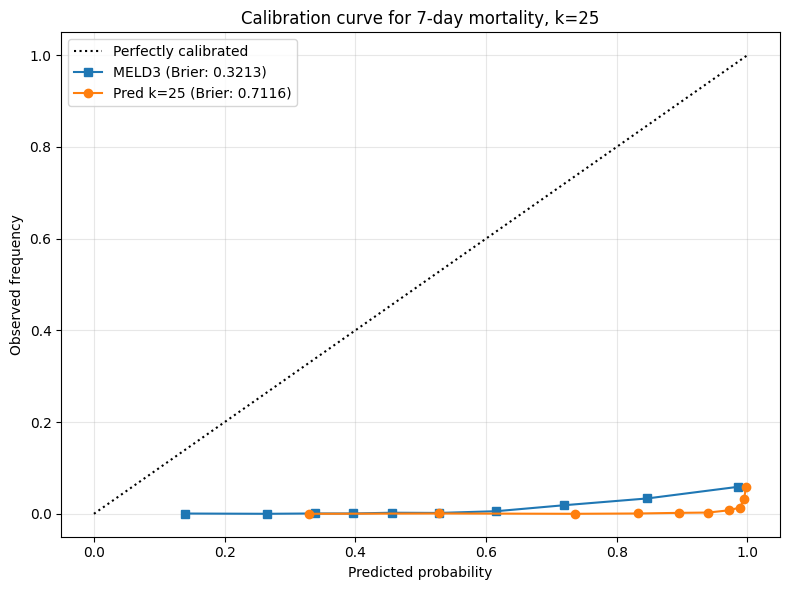

k=50 Brier score: 0.6952 (diff from MELD: -0.3739)


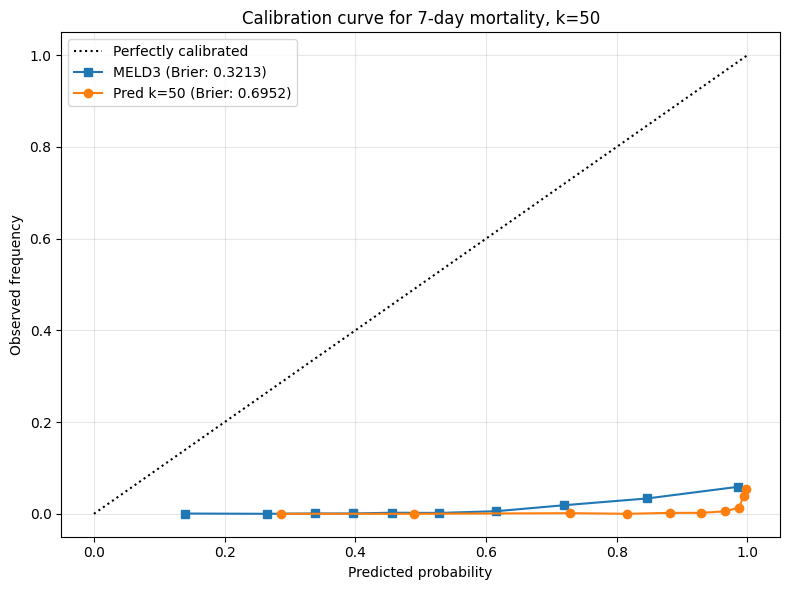

k=75 Brier score: 0.6926 (diff from MELD: -0.3714)


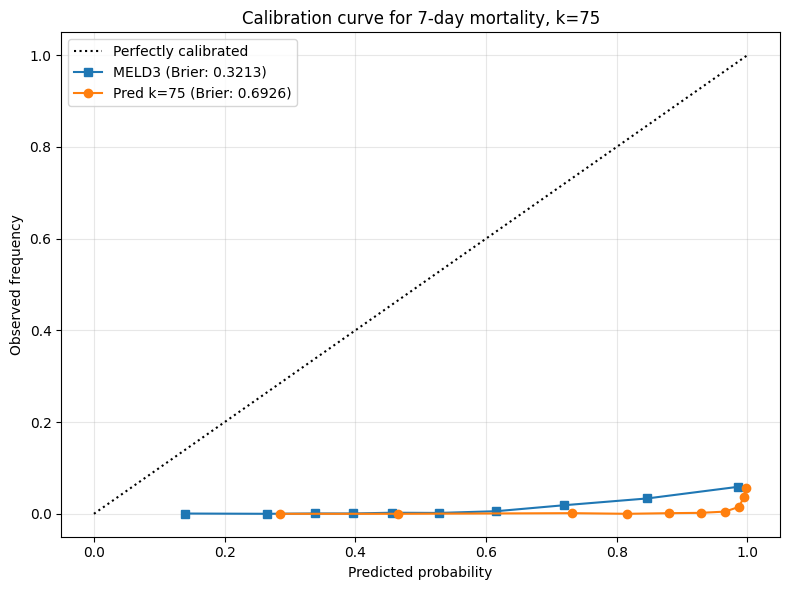

k=100 Brier score: 0.6941 (diff from MELD: -0.3729)


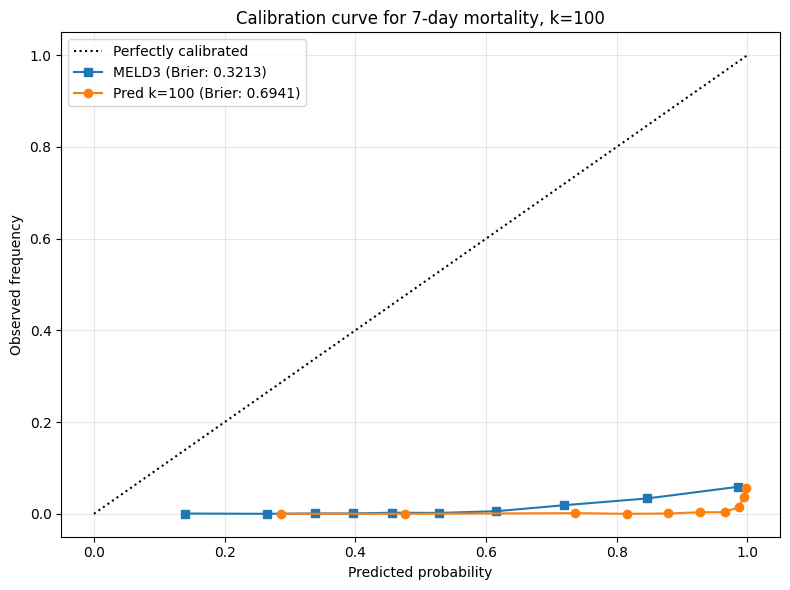

k=200 Brier score: 0.6922 (diff from MELD: -0.3710)


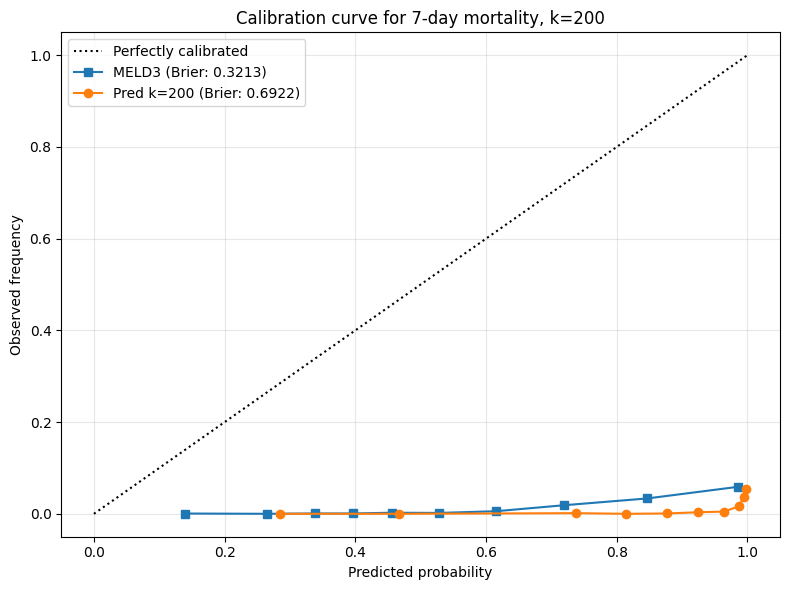


Evaluating predictions for 14-day mortality:
Actual 14-day mortality rate: 0.022 (318 events)
MELD Brier score: 0.3150
k=25 Brier score: 0.7019 (diff from MELD: -0.3869)


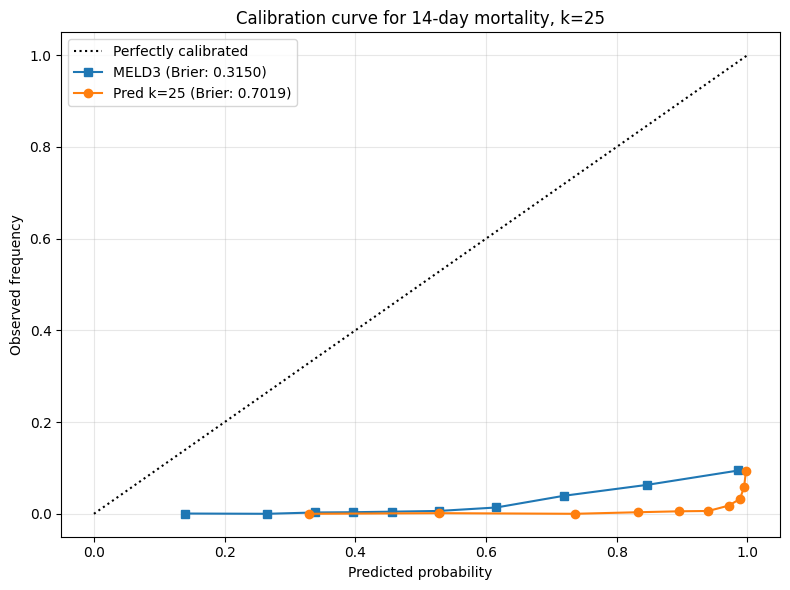

k=50 Brier score: 0.6856 (diff from MELD: -0.3705)


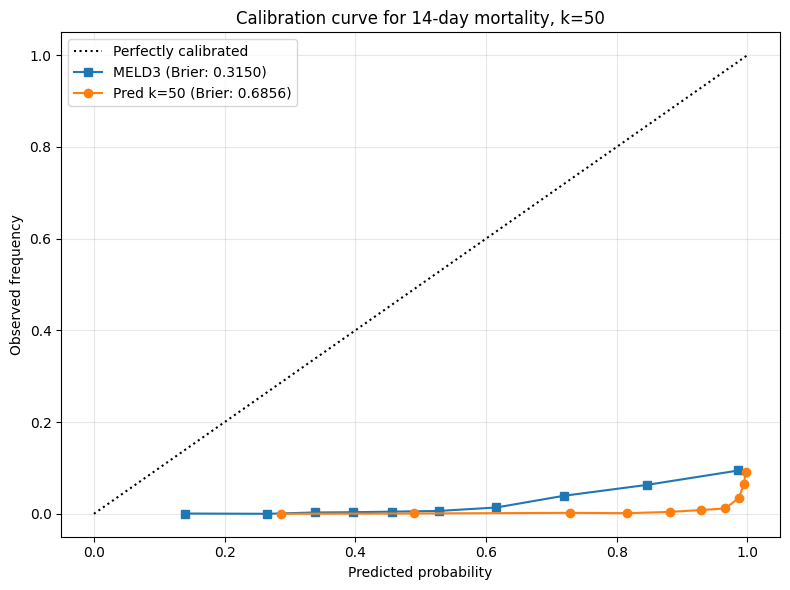

Processing with k=200:   0%|          | 0/14632 [10:05<?, ?it/s]

k=75 Brier score: 0.6830 (diff from MELD: -0.3680)


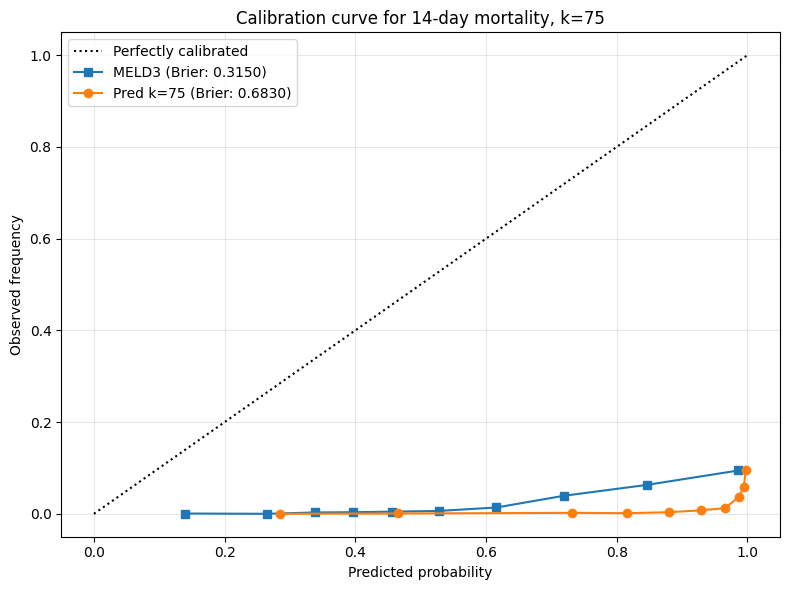

k=100 Brier score: 0.6845 (diff from MELD: -0.3695)


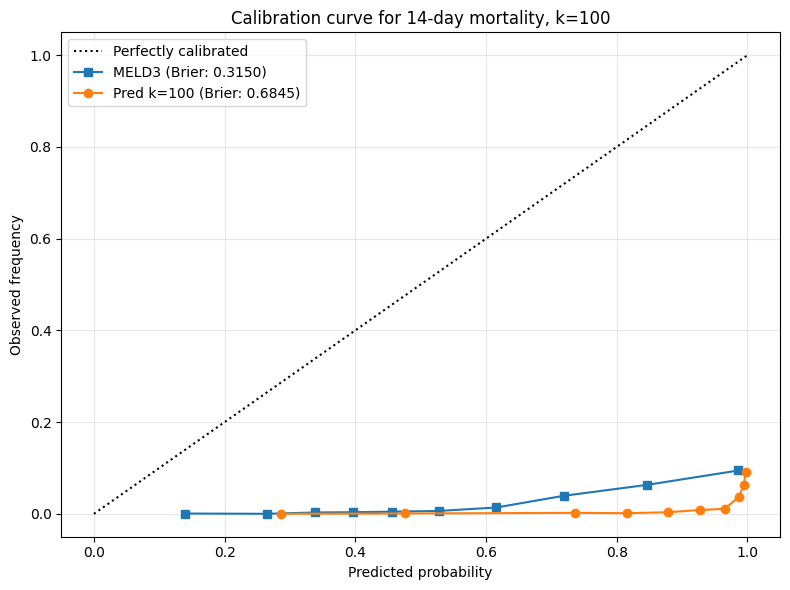

k=200 Brier score: 0.6827 (diff from MELD: -0.3676)


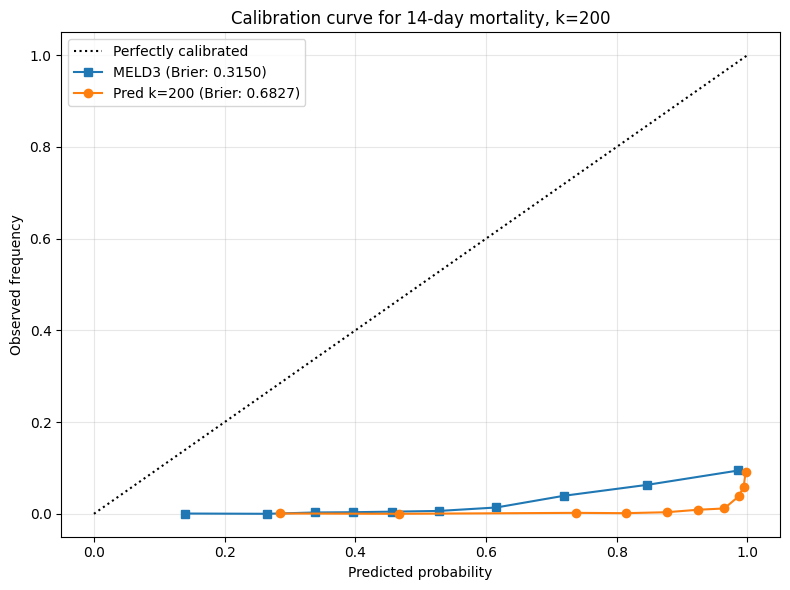


Evaluating predictions for 30-day mortality:
Actual 30-day mortality rate: 0.034 (498 events)
MELD Brier score: 0.3098
k=25 Brier score: 0.6906 (diff from MELD: -0.3808)


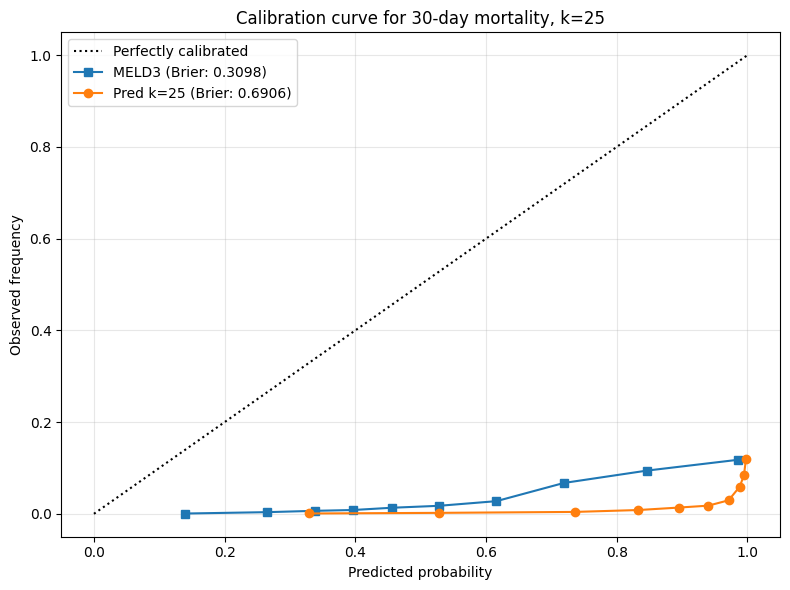

k=50 Brier score: 0.6743 (diff from MELD: -0.3645)


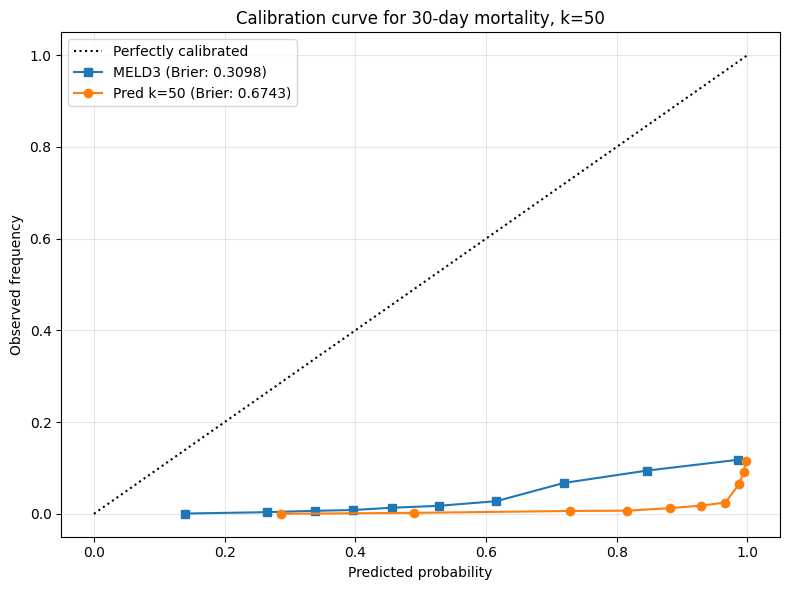

k=75 Brier score: 0.6719 (diff from MELD: -0.3621)


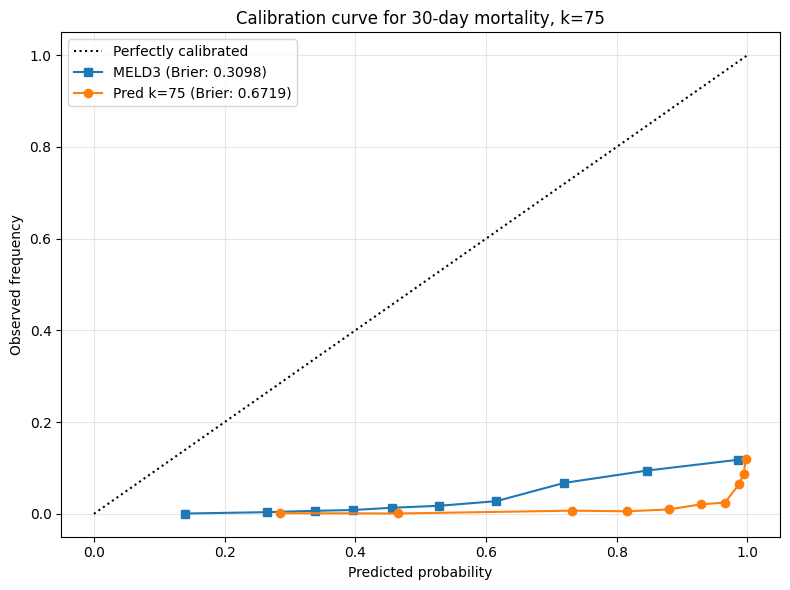

k=100 Brier score: 0.6733 (diff from MELD: -0.3635)


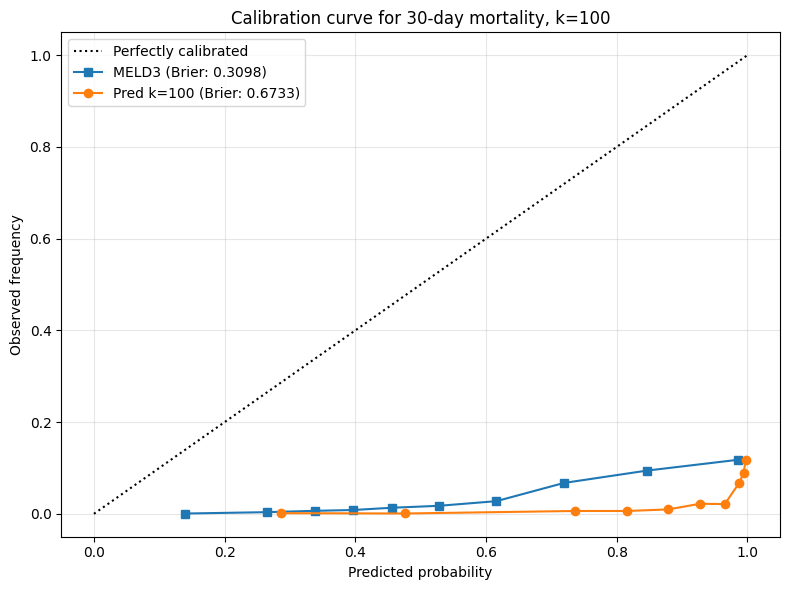

k=200 Brier score: 0.6715 (diff from MELD: -0.3617)


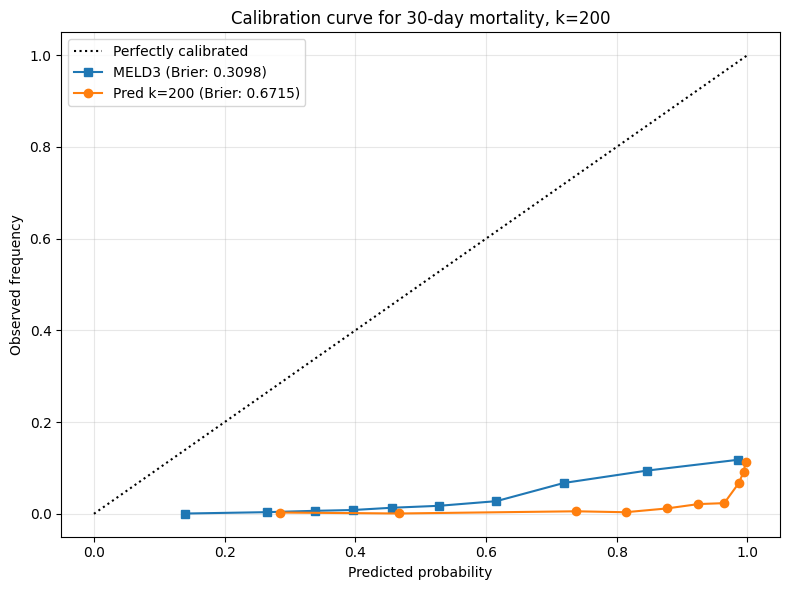


Evaluating predictions for 90-day mortality:
Actual 90-day mortality rate: 0.057 (837 events)
MELD Brier score: 0.3075
k=25 Brier score: 0.6728 (diff from MELD: -0.3653)


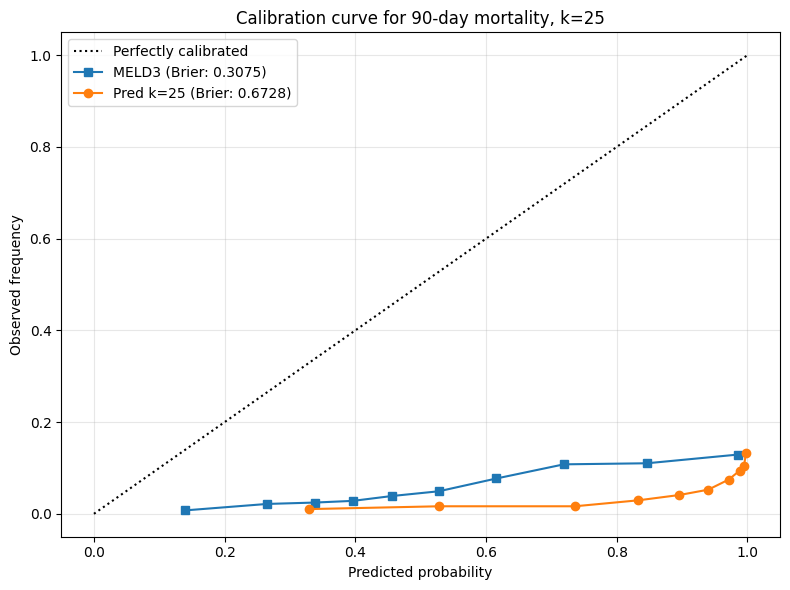

k=50 Brier score: 0.6569 (diff from MELD: -0.3494)


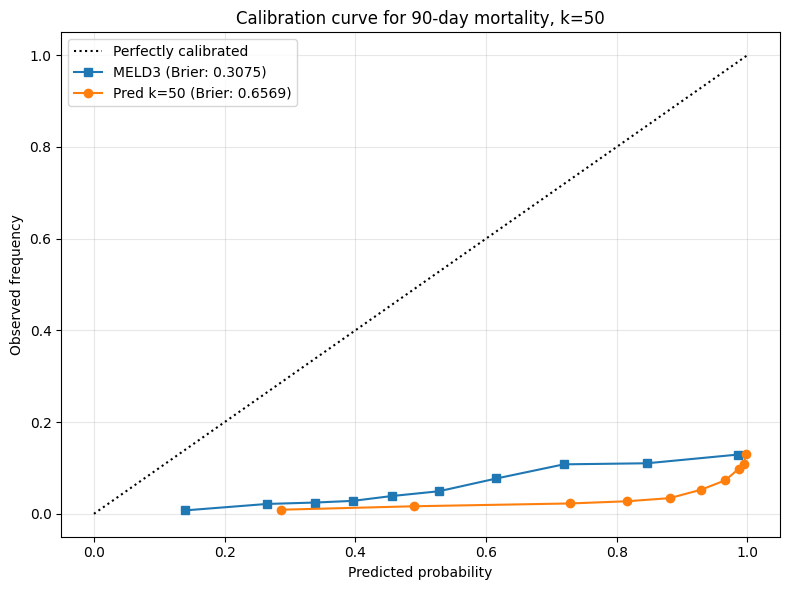

k=75 Brier score: 0.6545 (diff from MELD: -0.3470)


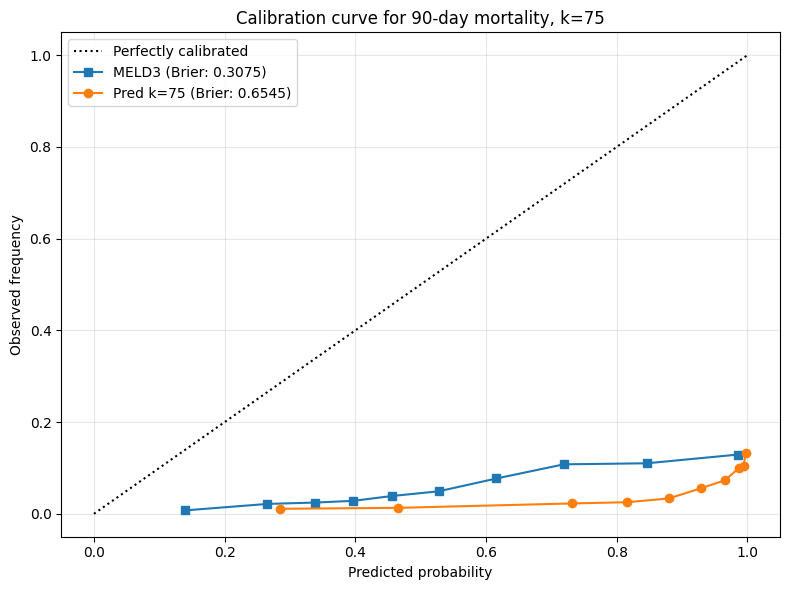

k=100 Brier score: 0.6558 (diff from MELD: -0.3483)


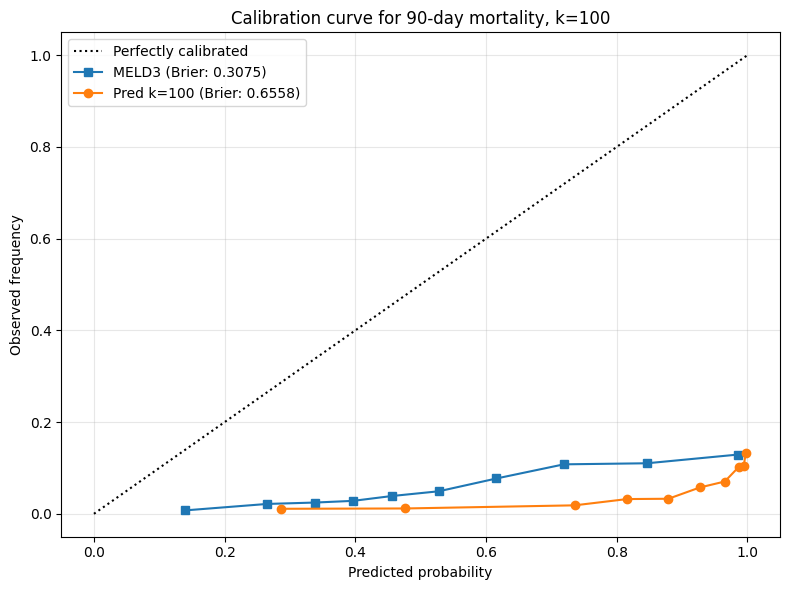

k=200 Brier score: 0.6541 (diff from MELD: -0.3465)


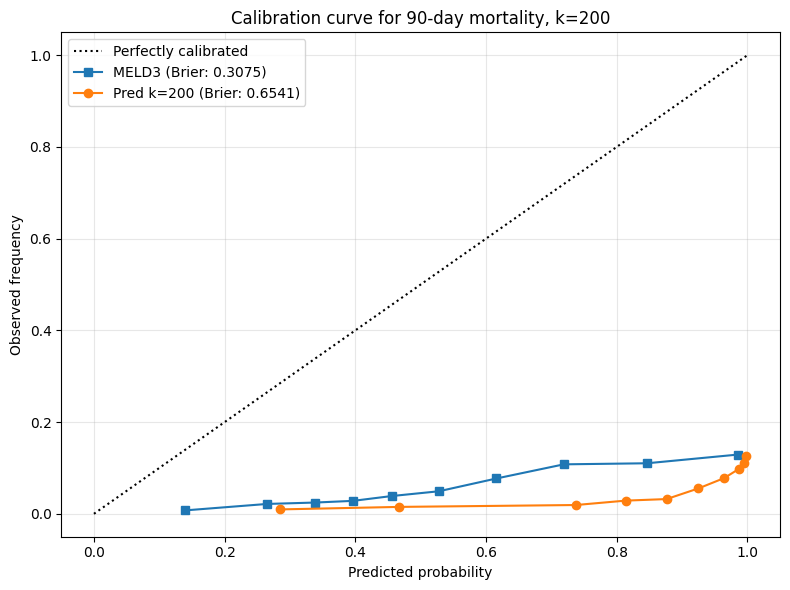


Evaluating predictions for 180-day mortality:
Actual 180-day mortality rate: 0.078 (1139 events)
MELD Brier score: 0.3098
k=25 Brier score: 0.6594 (diff from MELD: -0.3496)


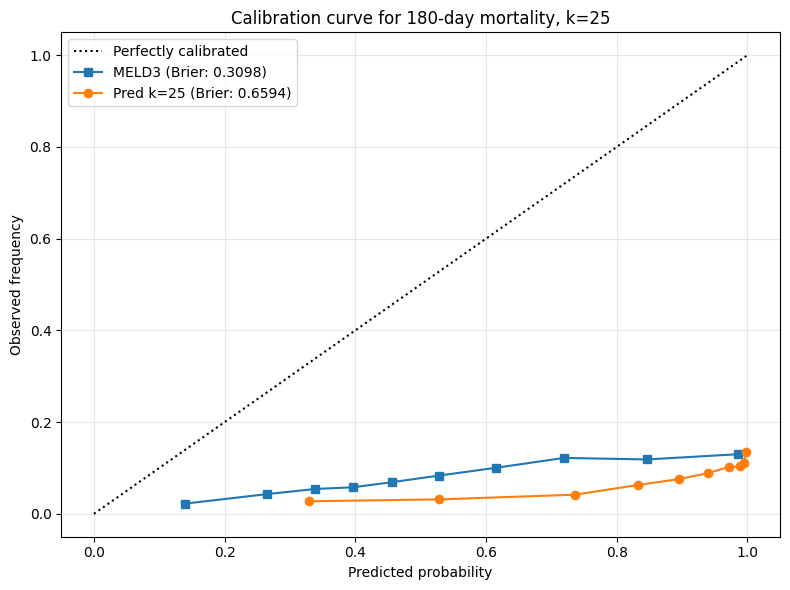

k=50 Brier score: 0.6438 (diff from MELD: -0.3340)


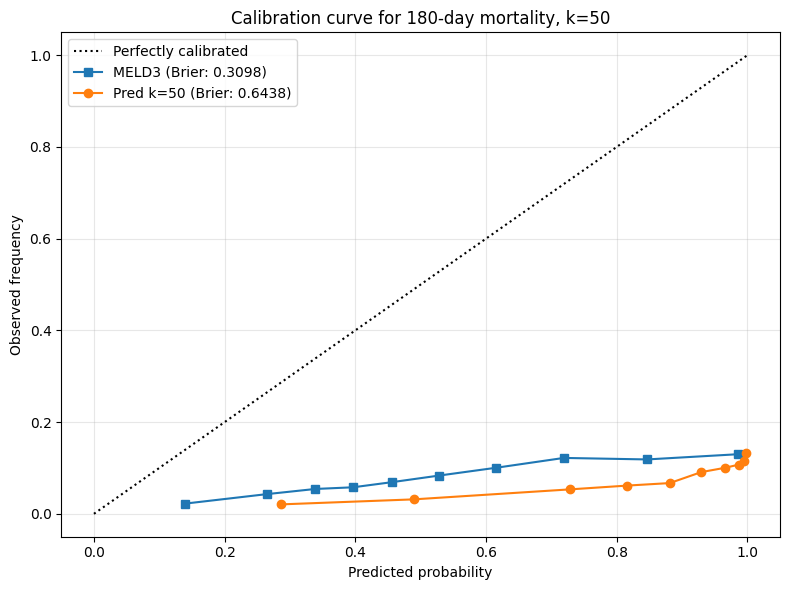

k=75 Brier score: 0.6415 (diff from MELD: -0.3317)


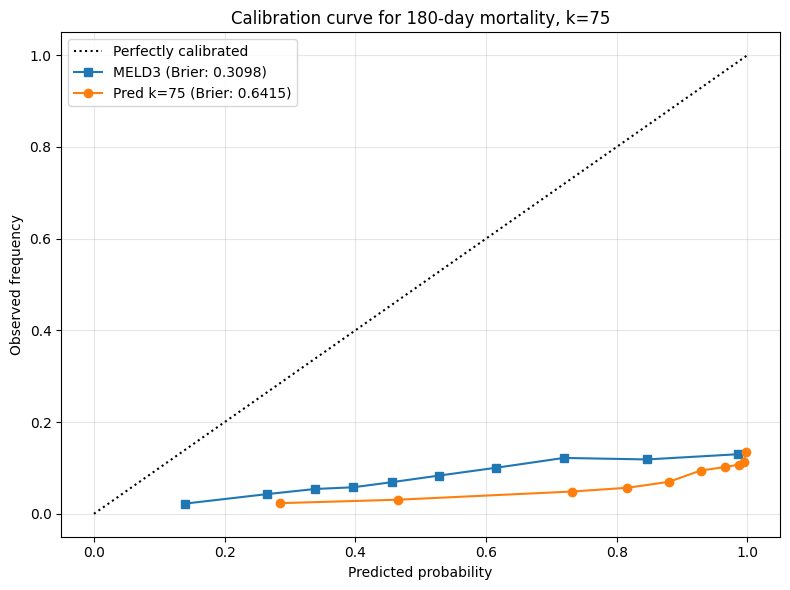

k=100 Brier score: 0.6430 (diff from MELD: -0.3331)


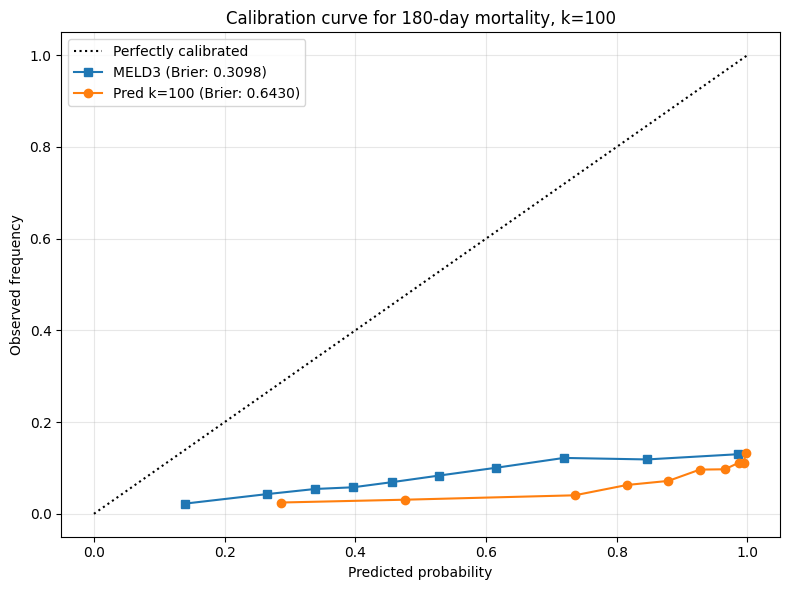

k=200 Brier score: 0.6414 (diff from MELD: -0.3316)


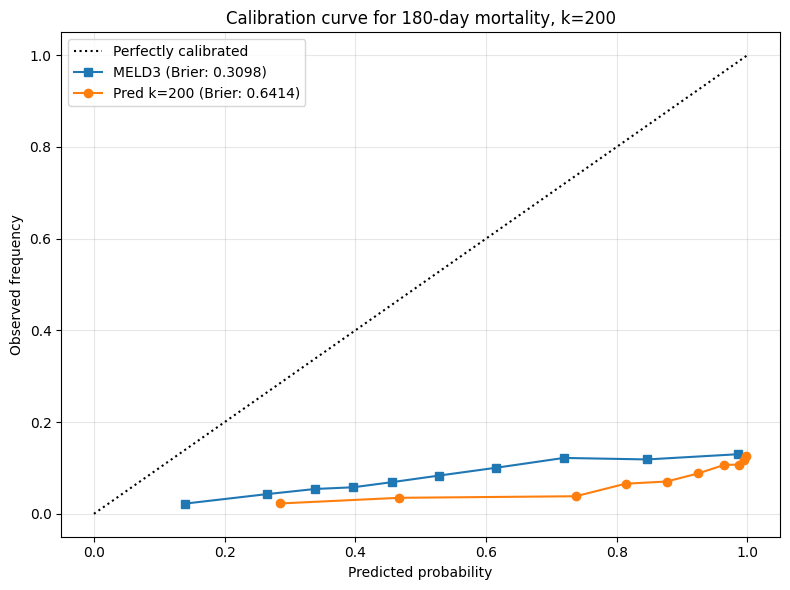


Evaluating predictions for 360-day mortality:
Actual 360-day mortality rate: 0.105 (1533 events)
MELD Brier score: 0.3153
k=25 Brier score: 0.6444 (diff from MELD: -0.3291)


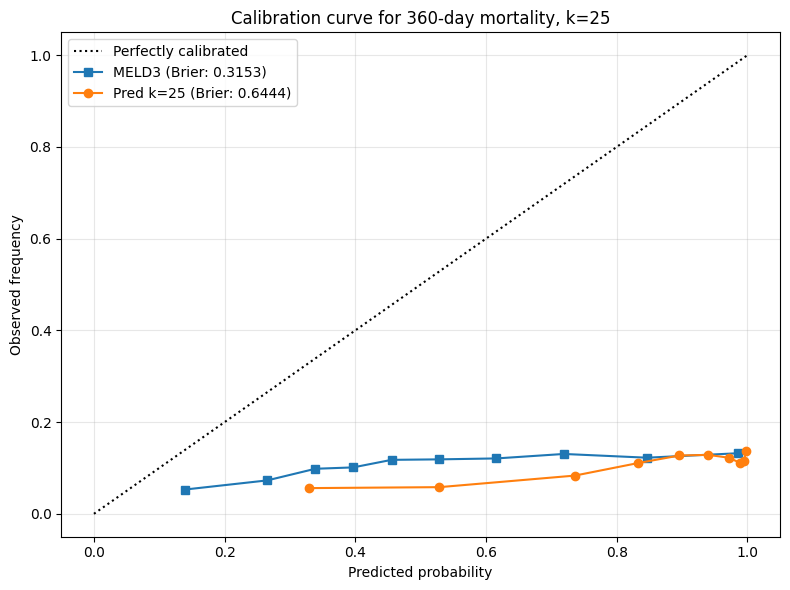

k=50 Brier score: 0.6294 (diff from MELD: -0.3141)


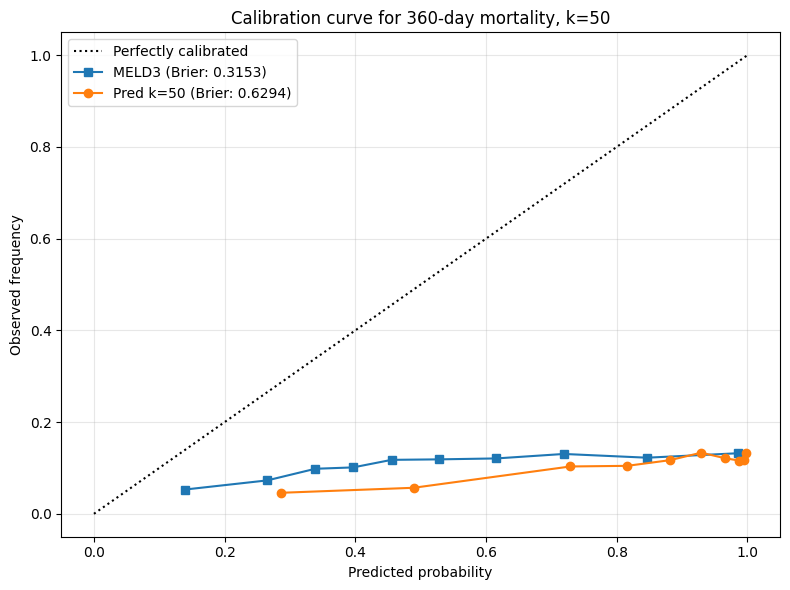

k=75 Brier score: 0.6277 (diff from MELD: -0.3124)


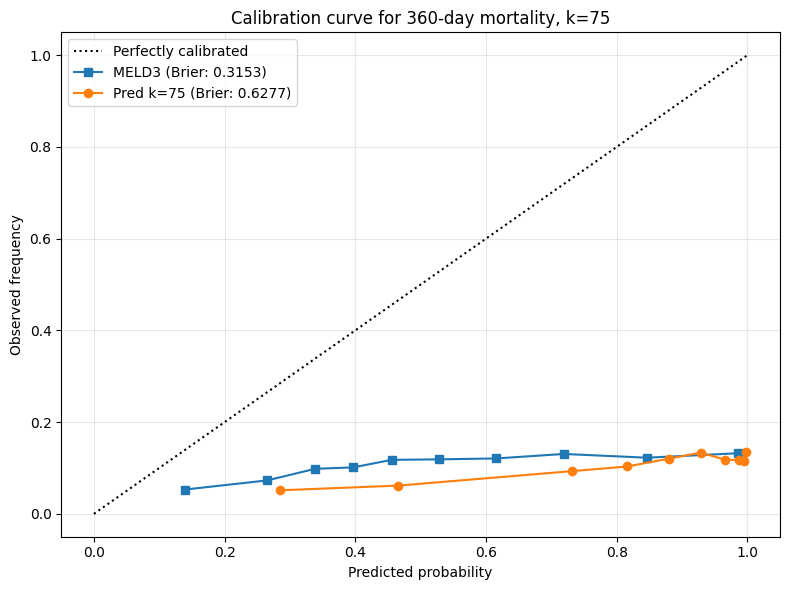

k=100 Brier score: 0.6290 (diff from MELD: -0.3137)


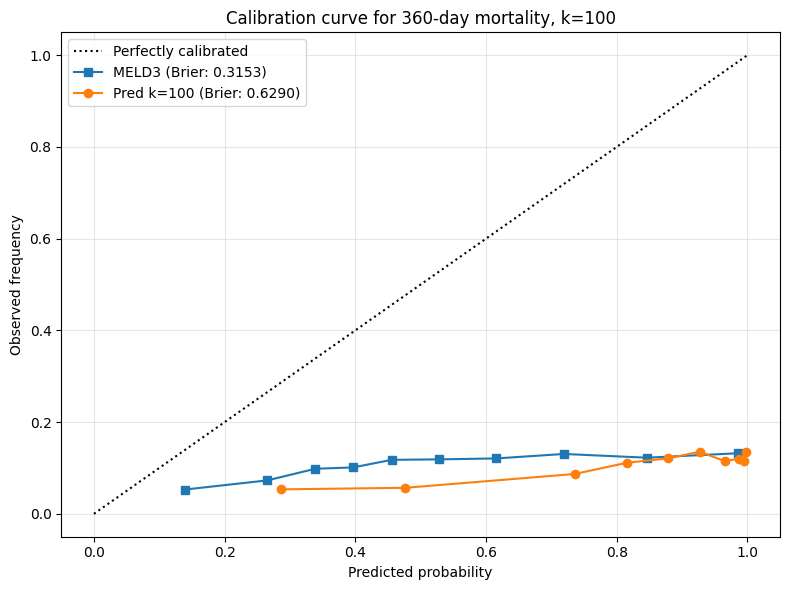

k=200 Brier score: 0.6272 (diff from MELD: -0.3119)


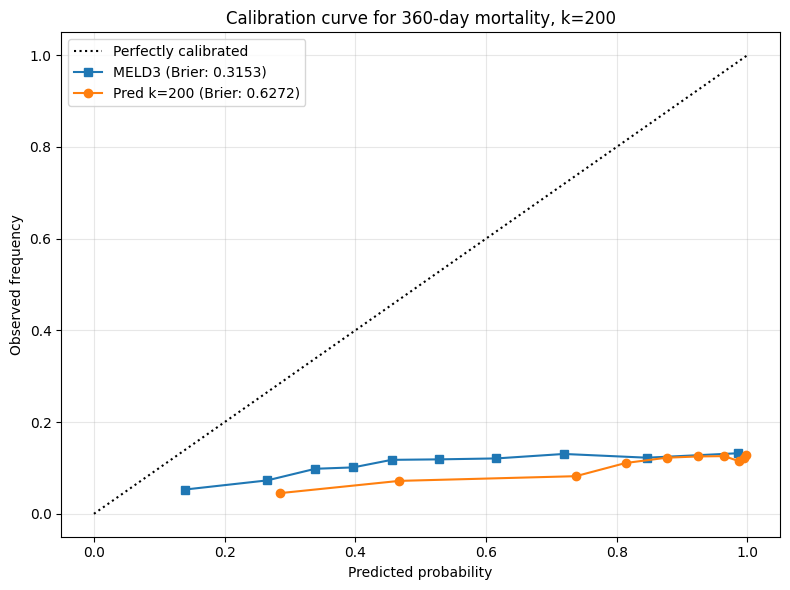


Summary of Brier Scores:
     brier_improvement                                 meld_brier                                 pred_brier                                
k                  25      50      75      100     200        25      50      75      100     200        25      50      75      100     200
time                                                                                                                                        
7              -0.3903 -0.3739 -0.3714 -0.3729 -0.3710     0.3213  0.3213  0.3213  0.3213  0.3213     0.7116  0.6952  0.6926  0.6941  0.6922
14             -0.3869 -0.3705 -0.3680 -0.3695 -0.3676     0.3150  0.3150  0.3150  0.3150  0.3150     0.7019  0.6856  0.6830  0.6845  0.6827
30             -0.3808 -0.3645 -0.3621 -0.3635 -0.3617     0.3098  0.3098  0.3098  0.3098  0.3098     0.6906  0.6743  0.6719  0.6733  0.6715
90             -0.3653 -0.3494 -0.3470 -0.3483 -0.3465     0.3075  0.3075  0.3075  0.3075  0.3075     0.6728  0.6569  0.6545  0.

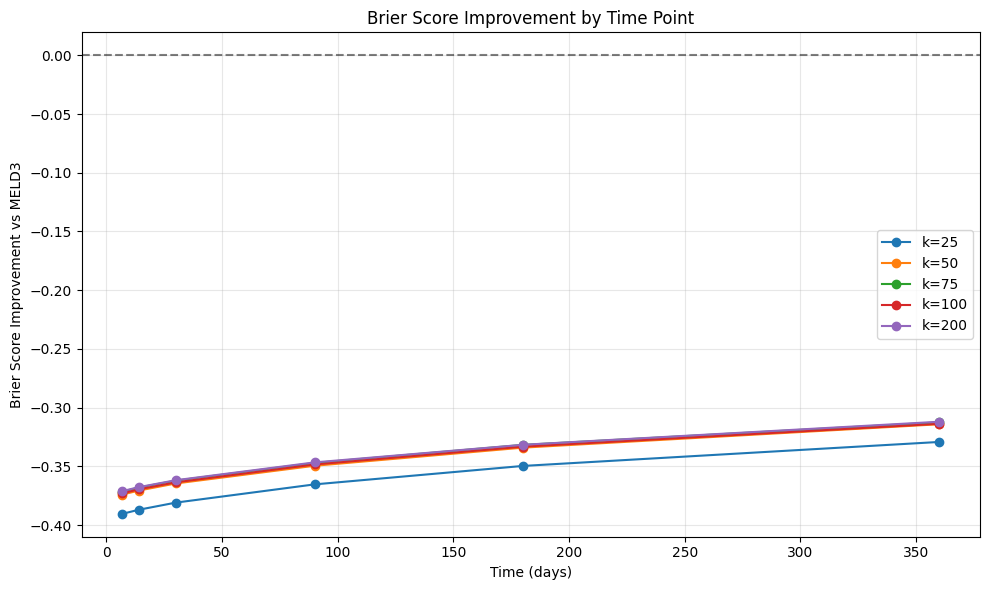

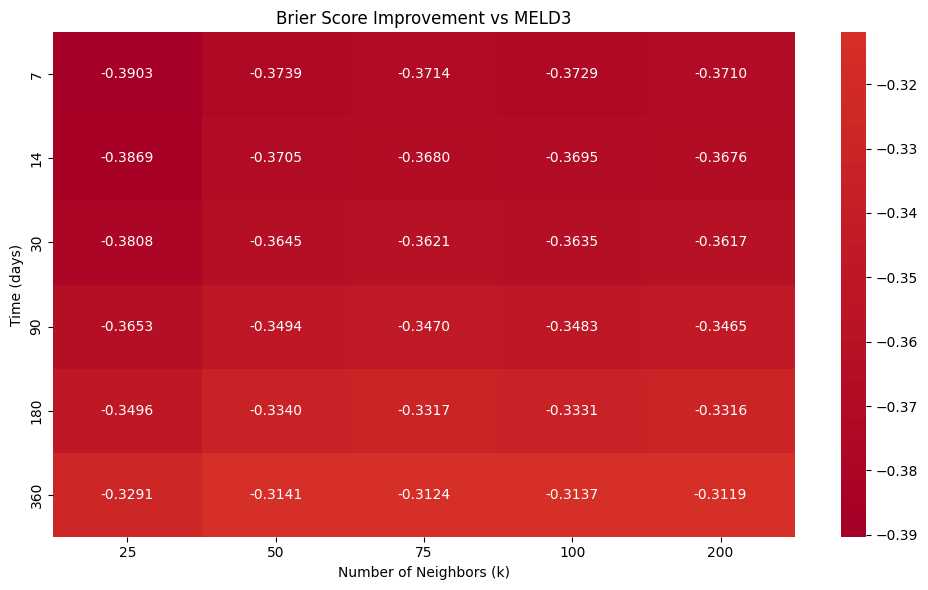

In [36]:
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def evaluate_calibration_and_brier(real_df, time_points=[7, 14, 30, 90, 180, 360], neighbor_sizes=[25, 50, 75, 100, 200]):
    """
    Evaluate calibration and Brier scores for survival predictions.

    Args:
        real_df: DataFrame with actual outcomes and predictions
        time_points: List of time points to evaluate (in days)
        neighbor_sizes: List of neighborhood sizes to evaluate
    """
    meld_col = 'meld3'
    results = []

    for t in time_points:
        print(f"\nEvaluating predictions for {t}-day mortality:")

        # Create binary outcome: 1 if died within t days, 0 otherwise
        y_true = ((real_df['outcome'] == 0) & (real_df['tte'] <= t)).astype(int)

        # Calculate event rate (actual probability of event)
        event_rate = y_true.mean()
        print(f"Actual {t}-day mortality rate: {event_rate:.3f} ({y_true.sum()} events)")

        # Evaluate MELD scores (need to normalize to [0,1] range for calibration)
        meld_scores = real_df[meld_col].copy()
        meld_min, meld_max = meld_scores.min(), meld_scores.max()
        meld_prob = (meld_scores - meld_min) / (meld_max - meld_min)  # Scale to [0,1]

        # Calculate Brier score for MELD
        try:
            meld_brier = brier_score_loss(y_true, meld_prob)
            print(f"MELD Brier score: {meld_brier:.4f}")

            # Calculate calibration curve for MELD
            meld_fraction_pos, meld_mean_pred_proba = calibration_curve(
                y_true, meld_prob, n_bins=10, strategy='quantile'
            )
        except Exception as e:
            print(f"Error calculating MELD calibration: {e}")
            meld_brier = np.nan
            meld_fraction_pos, meld_mean_pred_proba = [], []

        # Evaluate predictions for each k
        for k in neighbor_sizes:
            pred_col = f'predicted_majority_tte_k{k}'
            if pred_col not in real_df.columns:
                continue

            # Get valid predictions (non-NaN)
            valid_mask = ~real_df[pred_col].isna()
            valid_df = real_df[valid_mask].copy()
            valid_y_true = y_true[valid_mask]

            # Convert TTE predictions to probability of event
            # For TTE predictions, lower = higher risk, so we use 1 - normalized value
            pred_tte = valid_df[pred_col]
            pred_tte_min, pred_tte_max = pred_tte.min(), pred_tte.max()

            # Normalize and invert (so higher value = higher probability of event)
            pred_prob = 1 - ((pred_tte - pred_tte_min) / (pred_tte_max - pred_tte_min))

            # Calculate Brier score
            try:
                pred_brier = brier_score_loss(valid_y_true, pred_prob)
                brier_diff = meld_brier - pred_brier  # Positive = better than MELD

                # Calculate calibration curve
                pred_fraction_pos, pred_mean_pred_proba = calibration_curve(
                    valid_y_true, pred_prob, n_bins=10, strategy='quantile'
                )

                print(f"k={k} Brier score: {pred_brier:.4f} (diff from MELD: {brier_diff:.4f})")

                # Store results
                results.append({
                    'time': t,
                    'k': k,
                    'n_patients': len(valid_df),
                    'event_rate': event_rate,
                    'meld_brier': meld_brier,
                    'pred_brier': pred_brier,
                    'brier_improvement': brier_diff,
                    'meld_cal_observed': meld_fraction_pos,
                    'meld_cal_expected': meld_mean_pred_proba,
                    'pred_cal_observed': pred_fraction_pos,
                    'pred_cal_expected': pred_mean_pred_proba
                })

                # Plot calibration curve
                plt.figure(figsize=(8, 6))
                plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
                plt.plot(meld_mean_pred_proba, meld_fraction_pos, "s-", label=f"MELD3 (Brier: {meld_brier:.4f})")
                plt.plot(pred_mean_pred_proba, pred_fraction_pos, "o-", label=f"Pred k={k} (Brier: {pred_brier:.4f})")
                plt.xlabel("Predicted probability")
                plt.ylabel("Observed frequency")
                plt.title(f"Calibration curve for {t}-day mortality, k={k}")
                plt.legend(loc="best")
                plt.grid(alpha=0.3)
                plt.tight_layout()
                plt.savefig(f"calibration_t{t}_k{k}.png", dpi=300)
                plt.show()

            except Exception as e:
                print(f"Error for k={k}: {e}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run evaluation
calibration_results = evaluate_calibration_and_brier(real_df)

# Print summary
print("\nSummary of Brier Scores:")
pd.set_option('display.precision', 4)
summary = calibration_results.pivot_table(
    index='time',
    columns='k',
    values=['pred_brier', 'meld_brier', 'brier_improvement']
)
print(summary)

# Visualize Brier score improvements
plt.figure(figsize=(10, 6))
for k in neighbor_sizes:
    # Filter for this k
    k_data = calibration_results[calibration_results['k'] == k]
    if not k_data.empty:
        plt.plot(k_data['time'], k_data['brier_improvement'], marker='o', label=f'k={k}')

plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time (days)')
plt.ylabel('Brier Score Improvement vs MELD3')
plt.title('Brier Score Improvement by Time Point')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("brier_improvement.png", dpi=300)
plt.show()

# Create heatmap of Brier score improvements
if 'k' in calibration_results.columns and 'time' in calibration_results.columns:
    heatmap_data = calibration_results.pivot_table(
        index='time',
        columns='k',
        values='brier_improvement'
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, fmt='.4f')
    plt.title('Brier Score Improvement vs MELD3')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Time (days)')
    plt.tight_layout()
    plt.savefig('brier_improvement_heatmap.png', dpi=300)
    plt.show()

Event rate for 90-day mortality: 0.057
MELD3 Brier score: 0.3075

Results for k=25:
Exponential transform: Brier=0.2240, Improvement=0.0835
Sigmoid transform: Brier=0.2797, Improvement=0.0278
Linear transform: Brier=0.2709, Improvement=0.0366
Isotonic calibration: Brier=0.0522, Improvement=0.2553


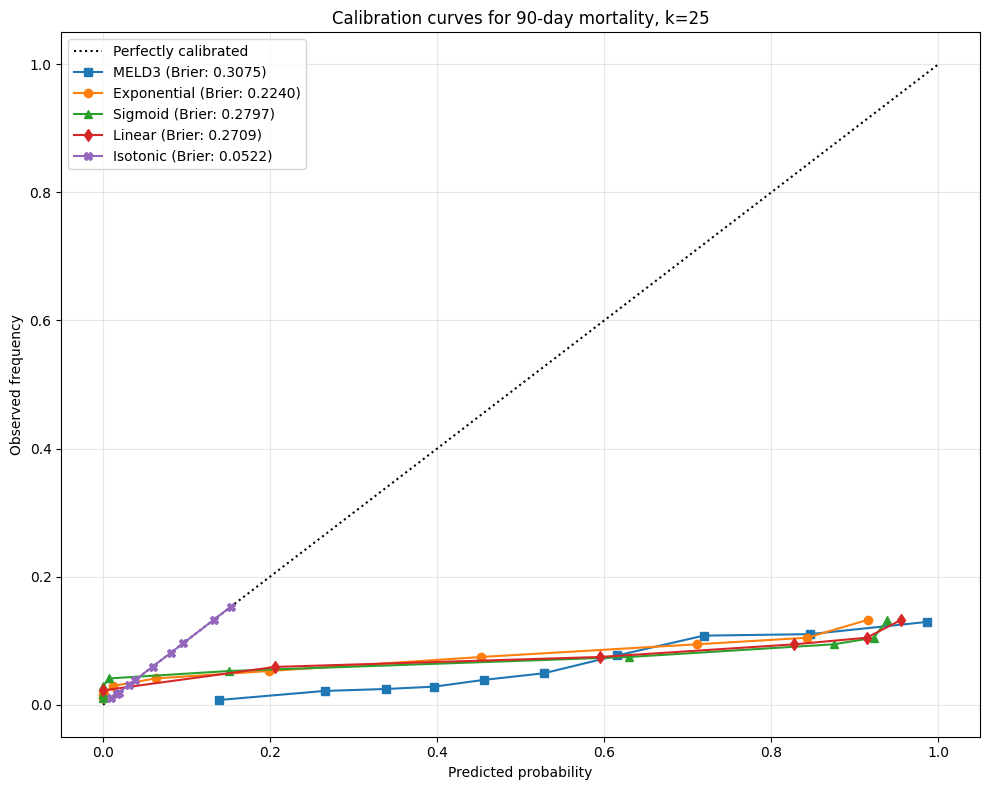


Results for k=50:
Exponential transform: Brier=0.2218, Improvement=0.0857
Sigmoid transform: Brier=0.2755, Improvement=0.0320
Linear transform: Brier=0.2673, Improvement=0.0402
Isotonic calibration: Brier=0.0521, Improvement=0.2554


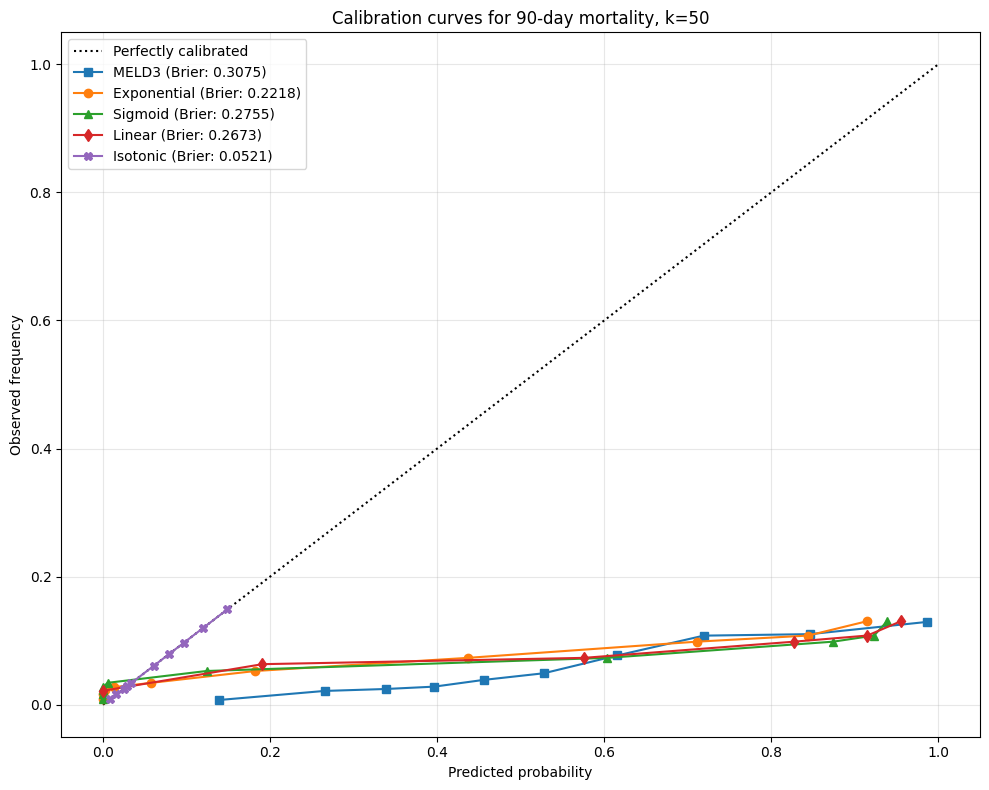


Results for k=75:
Exponential transform: Brier=0.2218, Improvement=0.0857
Sigmoid transform: Brier=0.2751, Improvement=0.0324
Linear transform: Brier=0.2672, Improvement=0.0404
Isotonic calibration: Brier=0.0521, Improvement=0.2554


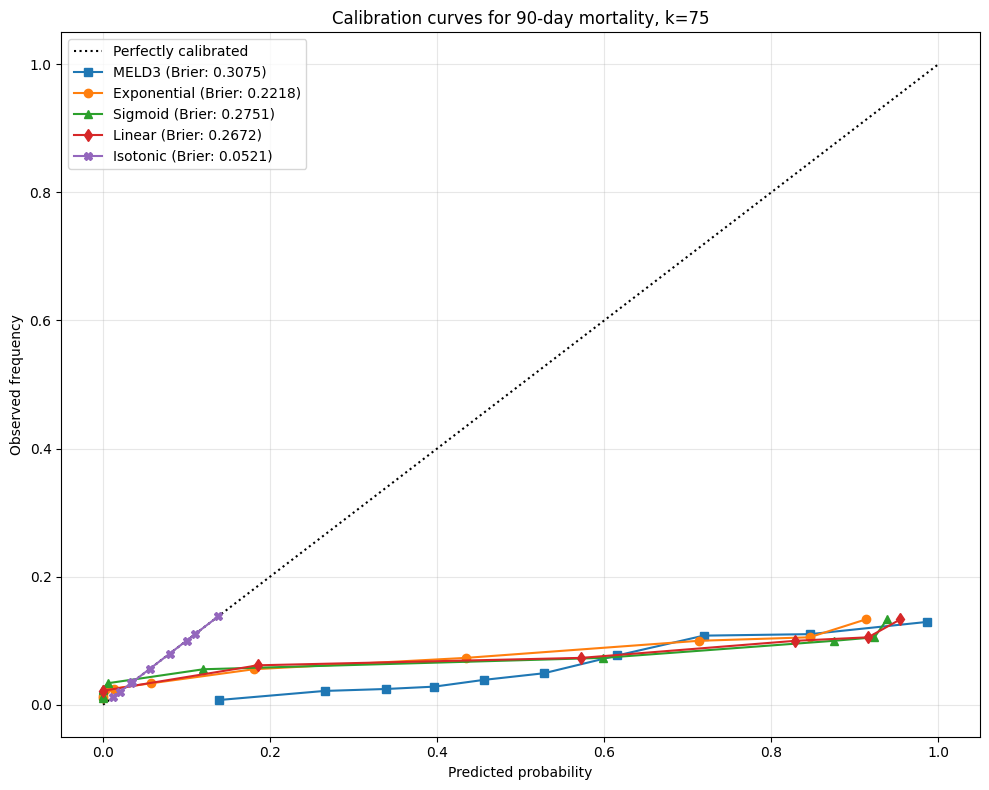


Results for k=100:
Exponential transform: Brier=0.2219, Improvement=0.0856
Sigmoid transform: Brier=0.2752, Improvement=0.0323
Linear transform: Brier=0.2672, Improvement=0.0403
Isotonic calibration: Brier=0.0521, Improvement=0.2554


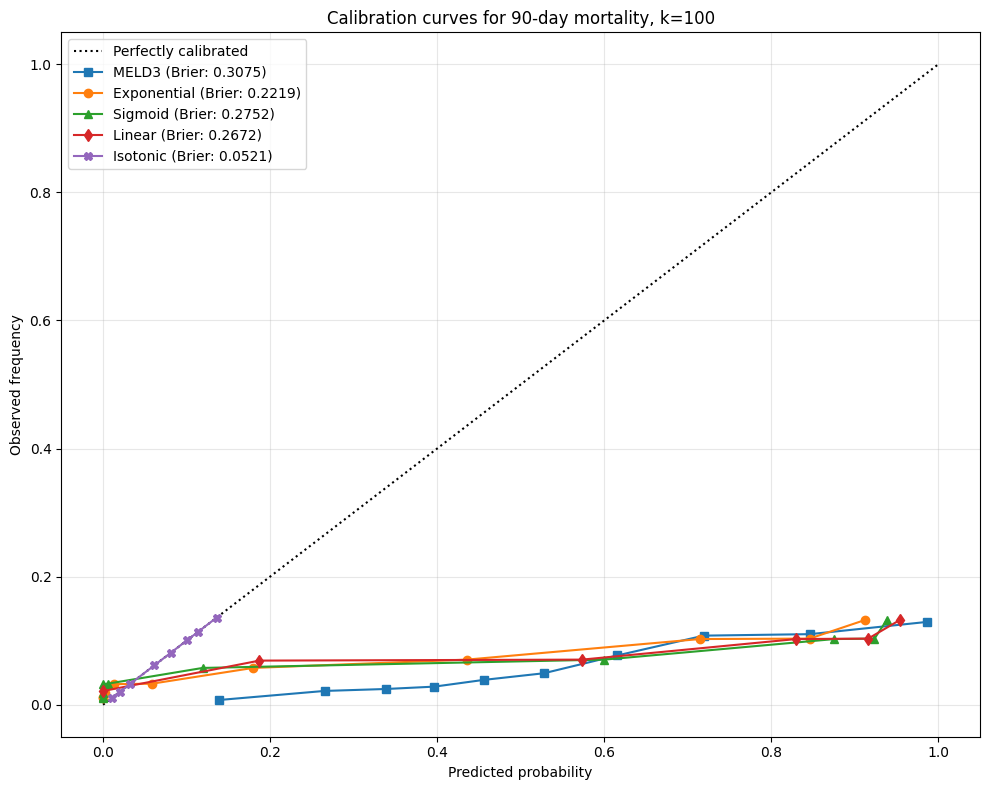


Results for k=200:
Exponential transform: Brier=0.2219, Improvement=0.0856
Sigmoid transform: Brier=0.2749, Improvement=0.0326
Linear transform: Brier=0.2670, Improvement=0.0405
Isotonic calibration: Brier=0.0521, Improvement=0.2554


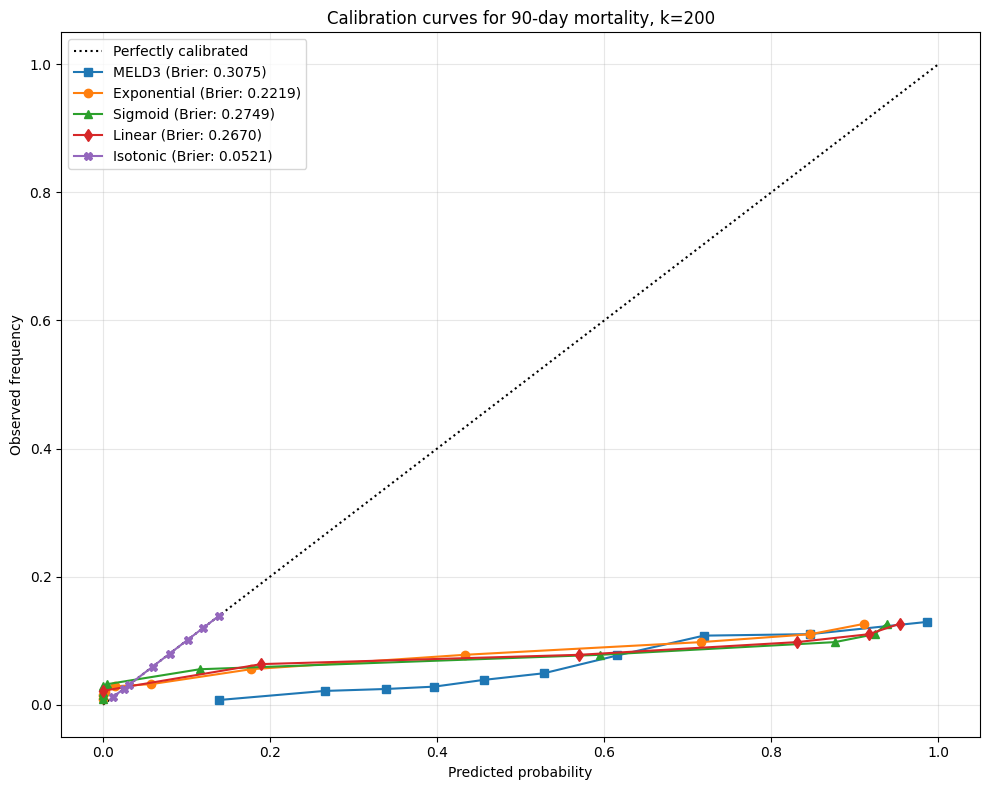


Summary of Brier Score Improvements:


exp_improvement  sigmoid_improvement  linear_improvement  iso_improvement
k                                                                             
25            0.0835               0.0278              0.0366           0.2553
50            0.0857               0.0320              0.0402           0.2554
75            0.0857               0.0324              0.0404           0.2554
100           0.0856               0.0323              0.0403           0.2554
200           0.0856               0.0326              0.0405           0.2554

In [37]:
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt

def transform_tte_predictions(real_df, timepoint=90, neighbor_sizes=[25, 50, 75, 100, 200]):
    """
    Apply different transformations to TTE predictions to improve calibration
    """
    # Create binary outcome: 1 if died within timepoint days, 0 otherwise
    y_true = ((real_df['outcome'] == 0) & (real_df['tte'] <= timepoint)).astype(int)
    event_rate = y_true.mean()
    print(f"Event rate for {timepoint}-day mortality: {event_rate:.3f}")

    # Get MELD3 scores as baseline
    meld_col = 'meld3'
    meld_scores = real_df[meld_col].copy()
    meld_min, meld_max = meld_scores.min(), meld_scores.max()
    meld_prob = (meld_scores - meld_min) / (meld_max - meld_min)  # Scale to [0,1]
    meld_brier = brier_score_loss(y_true, meld_prob)
    print(f"MELD3 Brier score: {meld_brier:.4f}")

    results = []

    for k in neighbor_sizes:
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in real_df.columns:
            continue

        # Get valid predictions (non-NaN)
        valid_mask = ~real_df[pred_col].isna()
        valid_df = real_df[valid_mask].copy()
        valid_y_true = y_true[valid_mask]

        # Get raw predictions
        pred_tte = valid_df[pred_col]

        # Try different transformations:

        # 1. Simple negative exponential: P(death) = exp(-tte/timepoint)
        # This creates higher probabilities for shorter TTEs
        exp_transform = np.exp(-pred_tte/timepoint)
        exp_brier = brier_score_loss(valid_y_true, exp_transform)

        # 2. Sigmoid transform: P(death) = 1/(1+exp((tte-timepoint)/scale))
        # This creates an S-curve centered at the timepoint
        sigmoid_transform = 1/(1+np.exp((pred_tte-timepoint)/30))
        sigmoid_brier = brier_score_loss(valid_y_true, sigmoid_transform)

        # 3. Linear transform with cutoff: P(death) = max(0, 1-tte/cutoff)
        # This creates a linear decrease up to the cutoff
        cutoff = 2*timepoint
        linear_transform = np.maximum(0, 1-pred_tte/cutoff)
        linear_brier = brier_score_loss(valid_y_true, linear_transform)

        # 4. Isotonic regression (automatically calibrates)
        try:
            # First normalize TTE predictions (lower = higher risk)
            pred_tte_norm = 1 - ((pred_tte - pred_tte.min()) / (pred_tte.max() - pred_tte.min()))

            # Fit isotonic regression
            ir = IsotonicRegression(out_of_bounds='clip')
            ir.fit(pred_tte_norm, valid_y_true)

            # Apply calibration
            iso_transform = ir.predict(pred_tte_norm)
            iso_brier = brier_score_loss(valid_y_true, iso_transform)
        except Exception as e:
            print(f"Error with isotonic regression for k={k}: {e}")
            iso_transform = None
            iso_brier = np.nan

        print(f"\nResults for k={k}:")
        print(f"Exponential transform: Brier={exp_brier:.4f}, Improvement={meld_brier-exp_brier:.4f}")
        print(f"Sigmoid transform: Brier={sigmoid_brier:.4f}, Improvement={meld_brier-sigmoid_brier:.4f}")
        print(f"Linear transform: Brier={linear_brier:.4f}, Improvement={meld_brier-linear_brier:.4f}")
        print(f"Isotonic calibration: Brier={iso_brier:.4f}, Improvement={meld_brier-iso_brier:.4f}")

        results.append({
            'k': k,
            'meld_brier': meld_brier,
            'exp_brier': exp_brier,
            'sigmoid_brier': sigmoid_brier,
            'linear_brier': linear_brier,
            'iso_brier': iso_brier,
            'exp_improvement': meld_brier - exp_brier,
            'sigmoid_improvement': meld_brier - sigmoid_brier,
            'linear_improvement': meld_brier - linear_brier,
            'iso_improvement': meld_brier - iso_brier,
        })

        # Plot calibration curves for each transformation
        plt.figure(figsize=(10, 8))
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

        # Plot MELD
        meld_fraction_pos, meld_mean_pred_proba = calibration_curve(
            valid_y_true, meld_prob[valid_mask], n_bins=10, strategy='quantile'
        )
        plt.plot(meld_mean_pred_proba, meld_fraction_pos, "s-",
                 label=f"MELD3 (Brier: {meld_brier:.4f})")

        # Plot exponential transform
        exp_fraction_pos, exp_mean_pred_proba = calibration_curve(
            valid_y_true, exp_transform, n_bins=10, strategy='quantile'
        )
        plt.plot(exp_mean_pred_proba, exp_fraction_pos, "o-",
                 label=f"Exponential (Brier: {exp_brier:.4f})")

        # Plot sigmoid transform
        sigmoid_fraction_pos, sigmoid_mean_pred_proba = calibration_curve(
            valid_y_true, sigmoid_transform, n_bins=10, strategy='quantile'
        )
        plt.plot(sigmoid_mean_pred_proba, sigmoid_fraction_pos, "^-",
                 label=f"Sigmoid (Brier: {sigmoid_brier:.4f})")

        # Plot linear transform
        linear_fraction_pos, linear_mean_pred_proba = calibration_curve(
            valid_y_true, linear_transform, n_bins=10, strategy='quantile'
        )
        plt.plot(linear_mean_pred_proba, linear_fraction_pos, "d-",
                 label=f"Linear (Brier: {linear_brier:.4f})")

        # Plot isotonic transform if available
        if iso_transform is not None:
            iso_fraction_pos, iso_mean_pred_proba = calibration_curve(
                valid_y_true, iso_transform, n_bins=10, strategy='quantile'
            )
            plt.plot(iso_mean_pred_proba, iso_fraction_pos, "X-",
                     label=f"Isotonic (Brier: {iso_brier:.4f})")

        plt.xlabel("Predicted probability")
        plt.ylabel("Observed frequency")
        plt.title(f"Calibration curves for {timepoint}-day mortality, k={k}")
        plt.legend(loc="best")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"calibration_transforms_t{timepoint}_k{k}.png", dpi=300)
        plt.show()

    return pd.DataFrame(results)

# Run for 90-day mortality
transform_results = transform_tte_predictions(real_df, timepoint=90)

# Print summary
print("\nSummary of Brier Score Improvements:")
transform_results.set_index('k')[['exp_improvement', 'sigmoid_improvement', 'linear_improvement', 'iso_improvement']].round(4)

In [38]:
from sklearn.isotonic import IsotonicRegression

# Create a function to apply isotonic calibration
def apply_isotonic_calibration(real_df, timepoint=90):
    """Apply isotonic calibration to create calibrated probability columns"""

    # Create binary outcome for the given timepoint
    y_true = ((real_df['outcome'] == 0) & (real_df['tte'] <= timepoint)).astype(int)

    for k in [25, 50, 75, 100, 200]:
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in real_df.columns:
            continue

        # Get valid predictions (non-NaN)
        valid_mask = ~real_df[pred_col].isna()
        valid_indices = valid_mask[valid_mask].index

        if len(valid_indices) > 0:
            # Get predictions and normalize (lower TTE = higher risk)
            pred_tte = real_df.loc[valid_mask, pred_col]
            pred_tte_norm = 1 - ((pred_tte - pred_tte.min()) / (pred_tte.max() - pred_tte.min()))

            # Fit isotonic regression
            ir = IsotonicRegression(out_of_bounds='clip')
            ir.fit(pred_tte_norm, y_true[valid_mask])

            # Create a new column for all rows (initialize with NaN)
            cal_col = f'calibrated_prob_k{k}_t{timepoint}'
            real_df[cal_col] = np.nan

            # Apply calibration to valid rows
            # First normalize TTE for all valid predictions
            all_valid_mask = ~real_df[pred_col].isna()
            all_pred_tte = real_df.loc[all_valid_mask, pred_col]
            all_pred_norm = 1 - ((all_pred_tte - pred_tte.min()) / (pred_tte.max() - pred_tte.min()))

            # Then apply the calibration model
            real_df.loc[all_valid_mask, cal_col] = ir.predict(all_pred_norm)

            print(f"Created calibrated probability column: {cal_col}")

    return real_df

# Apply calibration for multiple timepoints
for t in [30, 90, 180, 360]:
    real_df = apply_isotonic_calibration(real_df, timepoint=t)

# Verify the new columns
calibration_cols = [col for col in real_df.columns if 'calibrated_prob' in col]
print(f"\nCreated {len(calibration_cols)} calibrated probability columns")

Created calibrated probability column: calibrated_prob_k25_t30
Created calibrated probability column: calibrated_prob_k50_t30
Created calibrated probability column: calibrated_prob_k75_t30
Created calibrated probability column: calibrated_prob_k100_t30
Created calibrated probability column: calibrated_prob_k200_t30
Created calibrated probability column: calibrated_prob_k25_t90
Created calibrated probability column: calibrated_prob_k50_t90
Created calibrated probability column: calibrated_prob_k75_t90
Created calibrated probability column: calibrated_prob_k100_t90
Created calibrated probability column: calibrated_prob_k200_t90
Created calibrated probability column: calibrated_prob_k25_t180
Created calibrated probability column: calibrated_prob_k50_t180
Created calibrated probability column: calibrated_prob_k75_t180
Created calibrated probability column: calibrated_prob_k100_t180
Created calibrated probability column: calibrated_prob_k200_t180
Created calibrated probability column: calib

In [43]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis by capping tte at max_time
    and marking death_event accordingly.
    """
    out = df.copy()
    # Mark death (outcome == 0) as 1, else 0
    out['death_event'] = (out['outcome'] == 0).astype(int)
    if max_time is not None:
        # Censor patients who survive beyond max_time
        mask = out['tte'] > max_time
        out.loc[mask, 'tte'] = max_time
        out.loc[mask, 'death_event'] = 0
    return out

def compare_iso_calibrated_vs_meld3(
    real_df,
    iso_col="calibrated_prob_k100_t90",  # <--- Replace with your isotonic column
    meld_col="meld3",
    time_points=[7, 14, 30, 90, 180, 360]
):
    """
    Compare CoxPH models using the isotonic-calibrated probability
    vs. MELD-3 across multiple time points, returning a DataFrame
    of concordance indices.
    """
    # Verify columns
    for col in [iso_col, meld_col]:
        if col not in real_df.columns:
            raise ValueError(f"Column '{col}' not found in real_df")

    results = []

    for t in time_points:
        # 1) Prepare data
        analysis_df = prepare_survival_data(real_df, max_time=t)
        # We'll fit separate models for iso-only, meld-only, combined

        # 2) Isotonic alone
        #    Because higher probability => higher risk, we can use it directly
        cph_iso = CoxPHFitter()
        iso_data = analysis_df[['tte', 'death_event', iso_col]].dropna()
        cph_iso.fit(iso_data, duration_col='tte', event_col='death_event', show_progress=False)
        c_index_iso = cph_iso.concordance_index_

        # 3) MELD-3 alone
        cph_meld = CoxPHFitter()
        meld_data = analysis_df[['tte', 'death_event', meld_col]].dropna()
        cph_meld.fit(meld_data, duration_col='tte', event_col='death_event', show_progress=False)
        c_index_meld = cph_meld.concordance_index_

        # 4) Combined
        cph_comb = CoxPHFitter()
        comb_cols = ['tte', 'death_event', iso_col, meld_col]
        comb_data = analysis_df[comb_cols].dropna()
        cph_comb.fit(comb_data, duration_col='tte', event_col='death_event', show_progress=False)
        c_index_comb = cph_comb.concordance_index_

        results.append({
            'Time': t,
            'C-Index (Isotonic)': c_index_iso,
            'C-Index (MELD3)': c_index_meld,
            'C-Index (Combined)': c_index_comb
        })

    results_df = pd.DataFrame(results)
    return results_df

# Example usage:
iso_results_df = compare_iso_calibrated_vs_meld3(real_df,
                                                 iso_col="calibrated_prob_k100_t90",
                                                 meld_col="meld3",
                                                 time_points=[7, 14, 30, 90, 180, 360])

print(iso_results_df.round(3))


   Time  C-Index (Isotonic)  C-Index (MELD3)  C-Index (Combined)
0     7               0.891            0.895               0.898
1    14               0.897            0.901               0.904
2    30               0.889            0.891               0.895
3    90               0.853            0.851               0.856
4   180               0.822            0.822               0.826
5   360               0.796            0.797               0.801


In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def time_dependent_auc_iso_vs_meld3(
    df,
    iso_col='calibrated_prob_k100_t90',  # <-- your isotonic probability column
    meld_col='meld3',
    time_points=[7, 14, 30, 90, 180, 360]
):
    """
    Compute time-dependent AUC for death=0 at various horizons, censoring outcome=1 or 2.

    Args:
        df (pd.DataFrame): Must contain columns:
            - 'tte': Time to event or censor.
            - 'outcome': 0=death, 1=waiting, 2=transplant
            - iso_col: Isotonic probability (higher => higher risk)
            - meld_col: MELD3 risk score (higher => higher risk)
        iso_col (str): Column name for isotonic-calibrated predictions.
        meld_col (str): Column name for MELD-3 scores.
        time_points (list): List of integer day horizons.

    Returns:
        pd.DataFrame: A table of AUC results at each horizon.
    """
    # Ensure columns exist
    required_cols = ['tte', 'outcome', iso_col, meld_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in dataframe.")

    results = []
    # Copy data so we don't modify original
    df_all = df.copy()

    # 1. We define event=0 (death) and censor outcomes=1 (waiting) or =2 (transplant)
    #    for each horizon t.
    for t in time_points:
        # 2. 'At-risk' set: those who have not died before t.
        #    - If tte >= t => still followed
        #    - Or died exactly by t (outcome=0, tte <= t)
        #    (We effectively ignore transplants or waiting if they occur < t)
        at_risk_mask = (
            (df_all['tte'] >= t) |
            ((df_all['outcome'] == 0) & (df_all['tte'] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # 3. Among at-risk patients, define event indicator:
        #    1 if died by time t, 0 otherwise
        event_mask = (
            (df_at_risk['outcome'] == 0) &
            (df_at_risk['tte'] <= t)
        )
        event_indicator = event_mask.astype(int)

        # 4. Extract risk scores
        #    - iso_col is a direct "probability of death" => higher => higher risk
        #    - meld_col is also higher => higher risk
        iso_risk = df_at_risk[iso_col]
        meld_risk = df_at_risk[meld_col]

        # 5. Check that we have at least 1 event and at least 1 non-event
        if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
            auc_iso = roc_auc_score(event_indicator, iso_risk)
            auc_meld = roc_auc_score(event_indicator, meld_risk)
        else:
            auc_iso = None
            auc_meld = None

        results.append({
            'Time': t,
            'N_at_risk': len(df_at_risk),
            'N_events_by_t': int(event_indicator.sum()),
            f'AUC_{iso_col}': auc_iso,
            f'AUC_{meld_col}': auc_meld
        })

    return pd.DataFrame(results)

# -------------------------------------------------------------------
# EXAMPLE USAGE
# -------------------------------------------------------------------
# Suppose your real_df has:
#   - real_df['tte']
#   - real_df['outcome']  (0=death, 1=waiting, 2=transplant)
#   - real_df['calibrated_prob_k100_t90'] (the isotonic probability)
#   - real_df['meld3']    (the MELD-3 score)
#
# Then you can do:

time_points = [7, 14, 30, 90, 180, 360]
auc_results = time_dependent_auc_iso_vs_meld3(
    real_df,
    iso_col='calibrated_prob_k100_t90',  # your actual isotonic col name
    meld_col='meld3',
    time_points=time_points
)

print(auc_results)


   Time  N_at_risk  N_events_by_t  AUC_calibrated_prob_k100_t90  AUC_meld3
0     7      12188            171                        0.9217     0.9259
1    14      10911            318                        0.9328     0.9363
2    30       9653            498                        0.9289     0.9292
3    90       7706            837                        0.8867     0.8822
4   180       6432           1139                        0.8469     0.8457
5   360       5398           1533                        0.8117     0.8144


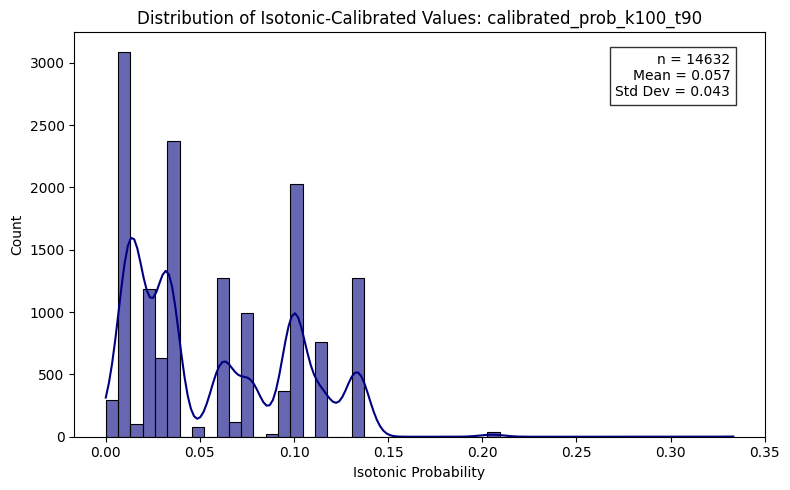

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_isotonic_distribution(df, iso_col='calibrated_prob_k50_t90'):
    """
    Plot a histogram + kernel density estimate (KDE) of the isotonic-calibrated values.

    Args:
        df (pd.DataFrame): DataFrame containing at least one isotonic col.
        iso_col (str): Column name of the isotonic-calibrated probabilities.
    """
    # Filter out NaN
    valid_series = df[iso_col].dropna()

    plt.figure(figsize=(8, 5))
    sns.histplot(valid_series, kde=True, color='navy', alpha=0.6)
    plt.title(f"Distribution of Isotonic-Calibrated Values: {iso_col}")
    plt.xlabel("Isotonic Probability")
    plt.ylabel("Count")

    # Optionally add some text with basic stats
    mean_val = valid_series.mean()
    std_val = valid_series.std()
    text_str = (f"n = {len(valid_series)}\n"
                f"Mean = {mean_val:.3f}\n"
                f"Std Dev = {std_val:.3f}")
    # Position text in upper-right corner
    plt.text(0.95, 0.95, text_str,
             transform=plt.gca().transAxes,
             horizontalalignment='right',
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_isotonic_distribution(real_df, iso_col='calibrated_prob_k100_t90')


In [51]:
real_df.columns

Index(['Age', 'Gender', 'ABO', 'BMI', 'Na', 'Cr', 'Dialysis', 'INR', 'Bili', 'Albumin', 'MELD', 'outcome', 'tte', 'Etiology', 'Ethnicity', 'diab_group_labeled', 'Encephalopathy_Status', 'Ascites_Status', 'meld3', 'predicted_death_tte', 'predicted_death_tte_k10', 'predicted_death_tte_k25', 'predicted_death_tte_k50', 'predicted_death_tte_k75', 'predicted_death_tte_k100', 'predicted_death_tte_k200', 'predicted_majority_tte_k25', 'predicted_majority_tte_k50', 'predicted_majority_tte_k75', 'predicted_majority_tte_k100', 'predicted_majority_tte_k200', 'calibrated_prob_k25_t30', 'calibrated_prob_k50_t30', 'calibrated_prob_k75_t30', 'calibrated_prob_k100_t30', 'calibrated_prob_k200_t30', 'calibrated_prob_k25_t90', 'calibrated_prob_k50_t90', 'calibrated_prob_k75_t90', 'calibrated_prob_k100_t90', 'calibrated_prob_k200_t90', 'calibrated_prob_k25_t180', 'calibrated_prob_k50_t180', 'calibrated_prob_k75_t180', 'calibrated_prob_k100_t180', 'calibrated_prob_k200_t180', 'calibrated_prob_k25_t360',
    

In [52]:
import pandas as pd

def show_patient_examples(
    df,
    iso_col='calibrated_prob_k100_t30',
    meld_col='meld3',
    extra_cols=None,
    top_n=5
):
    """
    Display a few patient examples comparing MELD-3 vs. isotonic risk (k=100 at t=90).

    Args:
        df (pd.DataFrame): Dataset containing at least meld_col and iso_col columns.
        iso_col (str): Column name for the isotonic-calibrated probabilities (higher = higher risk).
        meld_col (str): Column name for MELD-3 scores (higher = higher risk).
        extra_cols (list or None): Additional columns to display, e.g. ['tte','outcome'].
        top_n (int): How many examples to show for each group.
    """
    # Make sure columns exist
    needed = [iso_col, meld_col]
    if extra_cols is not None:
        needed += extra_cols
    for col in needed:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Create a working copy, drop missing
    working = df[needed].dropna(subset=[iso_col, meld_col]).copy()

    # 1) Highest isotonic risk
    highest_iso = working.nlargest(top_n, iso_col)

    # 2) Lowest isotonic risk
    lowest_iso = working.nsmallest(top_n, iso_col)

    # 3) Highest MELD-3
    highest_meld = working.nlargest(top_n, meld_col)

    # 4) Lowest MELD-3
    lowest_meld = working.nsmallest(top_n, meld_col)

    print(f"\n*** Top {top_n} patients by {iso_col} (highest isotonic risk) ***")
    display(highest_iso)

    print(f"\n*** Bottom {top_n} patients by {iso_col} (lowest isotonic risk) ***")
    display(lowest_iso)

    print(f"\n*** Top {top_n} patients by {meld_col} (highest MELD-3) ***")
    display(highest_meld)

    print(f"\n*** Bottom {top_n} patients by {meld_col} (lowest MELD-3) ***")
    display(lowest_meld)


# EXAMPLE USAGE:
show_patient_examples(real_df,
                     iso_col='calibrated_prob_k100_t30',
                     meld_col='meld3',
                     extra_cols=['tte','outcome'],
                     top_n=5)



*** Top 5 patients by calibrated_prob_k100_t30 (highest isotonic risk) ***


calibrated_prob_k100_t30  meld3  tte  outcome
598                     0.3333     40    1        0
988                     0.3333     40    5        2
4536                    0.3333     40    5        2
52                      0.2051     40    3        2
335                     0.2051     40    4        2


*** Bottom 5 patients by calibrated_prob_k100_t30 (lowest isotonic risk) ***


calibrated_prob_k100_t30  meld3   tte  outcome
10                        0.0      6   878        1
24                        0.0     15     1        2
97                        0.0      6   206        2
118                       0.0      7   915        2
134                       0.0     15  1550        1


*** Top 5 patients by meld3 (highest MELD-3) ***


calibrated_prob_k100_t30  meld3  tte  outcome
1                     0.0989     40   11        2
12                    0.1266     40   10        2
52                    0.2051     40    3        2
61                    0.1266     40    7        2
84                    0.1266     40    3        2


*** Bottom 5 patients by meld3 (lowest MELD-3) ***


calibrated_prob_k100_t30  meld3   tte  outcome
10                      0.0000      6   878        1
97                      0.0000      6   206        2
850                     0.0012      6   969        1
1009                    0.0000      6  2166        1
1373                    0.0000      6  1473        1

In [30]:
# Create heatmap of improvement over MELD
# Select improvement columns for heatmap
heatmap_cols = [f'majority_k{k}_vs_meld' for k in neighbor_sizes if f'majority_k{k}_vs_meld' in improvement_df.columns]
if heatmap_cols:
    heatmap_data = improvement_df[['Time'] + heatmap_cols]
    heatmap_data = heatmap_data.set_index('Time')

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, fmt='.3f')
    plt.title('Improvement in C-Index vs MELD Score (Majority-Based Approach)')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Time (days)')
    plt.tight_layout()
    plt.savefig('majority_c_index_improvement_heatmap.png', dpi=300)
    plt.show()

In [51]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Define the neighbor sizes to experiment with
neighbor_sizes = [25, 50, 75, 100, 200]

# Function to compute a weighted median based on distances
def weighted_median(data, weights):
    sorted_idx = np.argsort(data)
    data_sorted = data[sorted_idx]
    weights_sorted = weights[sorted_idx]
    cumulative_weight = np.cumsum(weights_sorted)
    midpoint = 0.5 * np.sum(weights_sorted)
    return data_sorted[np.searchsorted(cumulative_weight, midpoint)]

# Function to compute majority-based predictions with variable k and distance-weighted median
def compute_majority_based_prediction(idx, k, indices, distances, syn_df):
    neighbor_idxs = indices[idx, :k]
    neighbor_distances = distances[idx, :k]

    neighbor_outcomes = syn_df.loc[neighbor_idxs, 'outcome'].values

    outcome_counts = np.bincount(neighbor_outcomes.astype(int), minlength=3)
    majority_outcome = np.argmax(outcome_counts)

    majority_mask = neighbor_outcomes == majority_outcome
    majority_idxs = neighbor_idxs[majority_mask]
    majority_distances = neighbor_distances[majority_mask]

    if len(majority_idxs) == 0:
        return np.nan

    majority_tte = syn_df.loc[majority_idxs, 'tte'].values

    # Convert distances to similarity (inverse distance) weights, avoid division by zero
    weights = 1 / (majority_distances + 1e-6)

    predicted_tte = weighted_median(majority_tte, weights)

    return predicted_tte

# Generate predictions for different neighbor counts using majority-based approach
def generate_majority_predictions(real_df, indices_all, distances_all, syn_df_processed):
    n_real = len(real_df)

    syn_df = syn_df_processed.copy()

    print(f"Generating majority-based predictions for {len(neighbor_sizes)} different neighbor counts")

    for k in neighbor_sizes:
        print(f"\nComputing majority-based predictions with k={k} neighbors")

        with tqdm_joblib(tqdm(desc=f"Processing with k={k}", total=n_real)):
            predictions = Parallel(n_jobs=-1, backend="threading")(
                delayed(compute_majority_based_prediction)(i, k, indices_all, distances_all, syn_df)
                for i in range(n_real)
            )

        column_name = f'predicted_majority_tte_k{k}'
        real_df[column_name] = np.array(predictions)

        predictions_np = np.array(predictions)
        valid_preds = predictions_np[~np.isnan(predictions_np)]

        print(f"  Valid predictions: {len(valid_preds)}/{n_real} ({len(valid_preds)/n_real*100:.1f}%)")
        print(f"  Mean prediction: {np.mean(valid_preds):.2f} days")
        print(f"  Median prediction: {np.median(valid_preds):.2f} days")
        print(f"  Range: {np.min(valid_preds):.2f} to {np.max(valid_preds):.2f} days")

    return real_df

# Run the function to generate majority-based predictions
try:
    print("Starting generation of majority-based predictions with different neighbor counts")
    real_df = generate_majority_predictions(real_df, indices_all, distances_all, syn_df_processed)
    print("\nFinished generating majority-based predictions")
    print("New columns added:", [f'predicted_majority_tte_k{k}' for k in neighbor_sizes])
except Exception as e:
    print(f"Error generating predictions: {str(e)}")

Starting generation of majority-based predictions with different neighbor counts
Generating majority-based predictions for 5 different neighbor counts

Computing majority-based predictions with k=25 neighbors


Processing with k=25:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 457.04 days
  Median prediction: 196.48 days
  Range: 2.83 to 2917.44 days

Computing majority-based predictions with k=50 neighbors





Processing with k=50:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 431.99 days
  Median prediction: 196.22 days
  Range: 3.00 to 2915.97 days

Computing majority-based predictions with k=75 neighbors






Processing with k=75:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 434.50 days
  Median prediction: 198.43 days
  Range: 3.00 to 2915.97 days

Computing majority-based predictions with k=100 neighbors







Processing with k=100:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 426.99 days
  Median prediction: 197.53 days
  Range: 3.00 to 2915.97 days

Computing majority-based predictions with k=200 neighbors








Processing with k=200:   0%|          | 0/14632 [00:00<?, ?it/s]

  0%|          | 0/14632 [00:00<?, ?it/s]

  Valid predictions: 14632/14632 (100.0%)
  Mean prediction: 423.77 days
  Median prediction: 199.64 days
  Range: 3.04 to 2915.97 days

Finished generating majority-based predictions
New columns added: ['predicted_majority_tte_k25', 'predicted_majority_tte_k50', 'predicted_majority_tte_k75', 'predicted_majority_tte_k100', 'predicted_majority_tte_k200']


In [53]:
# Compare weighted majority-based predictions with MELD
def compare_majority_predictions(real_df, neighbor_sizes, time_points):
    # Check for MELD column
    meld_col = None
    for col in ['meld3']:
        if col in real_df.columns:
            meld_col = col
            break

    if meld_col is None:
        raise ValueError("No MELD column found in the dataframe")

    print(f"Using {meld_col} as the MELD score column")

    # Dictionary to store all results
    all_results = {}

    # Run analysis for each time point
    for t in time_points:
        print(f"Analyzing time point: {t} days")
        # Prepare survival data for the current time point
        analysis_df = prepare_survival_data(real_df, max_time=t)

        time_results = {}

        # Get c-index for MELD (baseline)
        cph_meld = CoxPHFitter()
        data_meld = analysis_df[['tte', 'death_event', meld_col]].copy()
        cph_meld.fit(data_meld, duration_col='tte', event_col='death_event', show_progress=False)
        time_results['meld'] = cph_meld.concordance_index_

        # Get c-index for each weighted majority-based neighbor size
        for k in neighbor_sizes:
            maj_col_name = f'predicted_majority_tte_k{k}'
            if maj_col_name not in analysis_df.columns:
                print(f"Warning: Column {maj_col_name} not found, skipping")
                continue

            # Model using weighted majority-based predictions
            cph_maj = CoxPHFitter()
            data_maj = analysis_df[['tte', 'death_event', maj_col_name]].copy()

            # Handle NaN values in the prediction column
            if data_maj[maj_col_name].isna().any():
                print(f"Warning: {data_maj[maj_col_name].isna().sum()} NaN values in {maj_col_name}, dropping them.")
                data_maj = data_maj.dropna(subset=[maj_col_name])

            # Fit the model
            cph_maj.fit(data_maj, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'weighted_majority_k{k}'] = cph_maj.concordance_index_

            # Combined model (weighted majority predictions + MELD)
            cph_combined = CoxPHFitter()
            data_combined = analysis_df[['tte', 'death_event', maj_col_name, meld_col]].copy()

            # Handle NaN values
            if data_combined[maj_col_name].isna().any():
                data_combined = data_combined.dropna(subset=[maj_col_name])

            cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'weighted_majority_k{k}+meld'] = cph_combined.concordance_index_

        all_results[t] = time_results

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(all_results).T
    results_df.index.name = 'Time'
    results_df.reset_index(inplace=True)

    return results_df

# Run the comparison analysis
concordance_results = compare_majority_predictions(real_df, neighbor_sizes, time_points)

# Print tabular results for Cox PH
print("\nConcordance Indices by Time Point and Neighbor Count (Cox PH):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(concordance_results.round(3))


Using meld3 as the MELD score column
Analyzing time point: 7 days
Analyzing time point: 14 days
Analyzing time point: 30 days
Analyzing time point: 90 days
Analyzing time point: 180 days
Analyzing time point: 360 days

Concordance Indices by Time Point and Neighbor Count (Cox PH):
   Time   meld  weighted_majority_k25  weighted_majority_k25+meld  weighted_majority_k50  weighted_majority_k50+meld  weighted_majority_k75  weighted_majority_k75+meld  weighted_majority_k100  weighted_majority_k100+meld  weighted_majority_k200  weighted_majority_k200+meld
0     7  0.898                  0.888                       0.898                  0.892                       0.899                  0.892                       0.899                   0.891                        0.898                   0.889                        0.898
1    14  0.902                  0.893                       0.903                  0.894                       0.903                  0.894                       0.903   

In [54]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Define evaluation time points
time_points = [7, 14, 30, 90, 180, 360]
results = []

# Include all patients
df_all = real_df.copy()

print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # At-risk patients: those who died or survived past time t
    at_risk_mask = (
        (df_all['outcome'] == 0) |  # died
        ((df_all['outcome'].isin([1, 2])) & (df_all['tte'] >= t))  # survived or transplanted after t
    )

    df_at_risk = df_all[at_risk_mask].copy()

    # Death event indicator within time t
    event_indicator = ((df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)).astype(int)

    # Debug information at first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Deaths within {t} days: {event_indicator.sum()}")
        print(f"Survivors past {t} days: {len(event_indicator) - event_indicator.sum()}")

    # MELD3 as risk (higher = higher risk)
    risk_meld3 = df_at_risk['meld3']

    auc_results = {
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_within_t': int(event_indicator.sum())
    }

    # Compute AUC for weighted majority predictions
    for k in neighbor_sizes:
        maj_col_name = f'predicted_majority_tte_k{k}'
        if maj_col_name not in df_at_risk.columns:
            auc_results[f'AUC_weighted_majority_k{k}'] = None
            continue

        # Negative TTE as risk (shorter survival = higher risk)
        risk_weighted_majority = -df_at_risk[maj_col_name]

        if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
            auc_score = roc_auc_score(event_indicator, risk_weighted_majority)
        else:
            auc_score = None

        auc_results[f'AUC_weighted_majority_k{k}'] = auc_score

    # Compute AUC for MELD3
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_meld3 = None

    auc_results['AUC_meld3'] = auc_meld3

    results.append(auc_results)

# Compile and format results DataFrame
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_within_t'] = results_df['N_deaths_within_t'].astype(int)

# Display formatted results
print("\nTime-Dependent AUC (Risk of Death within T days, Including All Patients):")
print("\nTime  N at risk  N deaths  AUC MELD-3", end="")
for k in neighbor_sizes:
    print(f"  AUC k={k}", end="")
print("\n" + "-" * 80)

for _, row in results_df.iterrows():
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_within_t']):8d}  {auc_meld3_str:10s}", end="")
    for k in neighbor_sizes:
        auc_col = f'AUC_weighted_majority_k{k}'
        auc_val = row[auc_col]
        auc_str = f"{auc_val:.3f}" if pd.notnull(auc_val) else "N/A"
        print(f"  {auc_str:8s}", end="")
    print()


Total patients in dataset: 14632
Outcome distribution:
outcome
2    10307
0     2662
1     1663
Name: count, dtype: int64

At time 7:
Patients at risk: 12188
Deaths within 7 days: 171
Survivors past 7 days: 12017

Time-Dependent AUC (Risk of Death within T days, Including All Patients):

Time  N at risk  N deaths  AUC MELD-3  AUC k=25  AUC k=50  AUC k=75  AUC k=100  AUC k=200
--------------------------------------------------------------------------------
   7     12188       171  0.927       0.917     0.921     0.921     0.920     0.919   
  14     10911       318  0.937       0.928     0.929     0.929     0.929     0.929   
  30      9653       498  0.929       0.921     0.923     0.923     0.924     0.923   
  90      7706       837  0.882       0.875     0.877     0.877     0.880     0.881   
 180      6432      1139  0.846       0.838     0.843     0.843     0.843     0.845   
 360      5398      1533  0.814       0.804     0.811     0.811     0.810     0.814   


Number of patients who died: 2662

--- Error Metrics for Patients who Died ---
Mean Absolute Error: 571.07 days
Root Mean Squared Error: 860.03 days
R-squared: -1.3001
Pearson Correlation: 0.4377 (p-value: 5.2649e-125)
Spearman Correlation: 0.6525 (p-value: 7.9051e-323)

--- Error Distribution ---
Mean error: 373.58 days
Median error: 160.98 days
Mean absolute error: 571.07 days
Median absolute error: 323.63 days
Mean percentage error: inf%


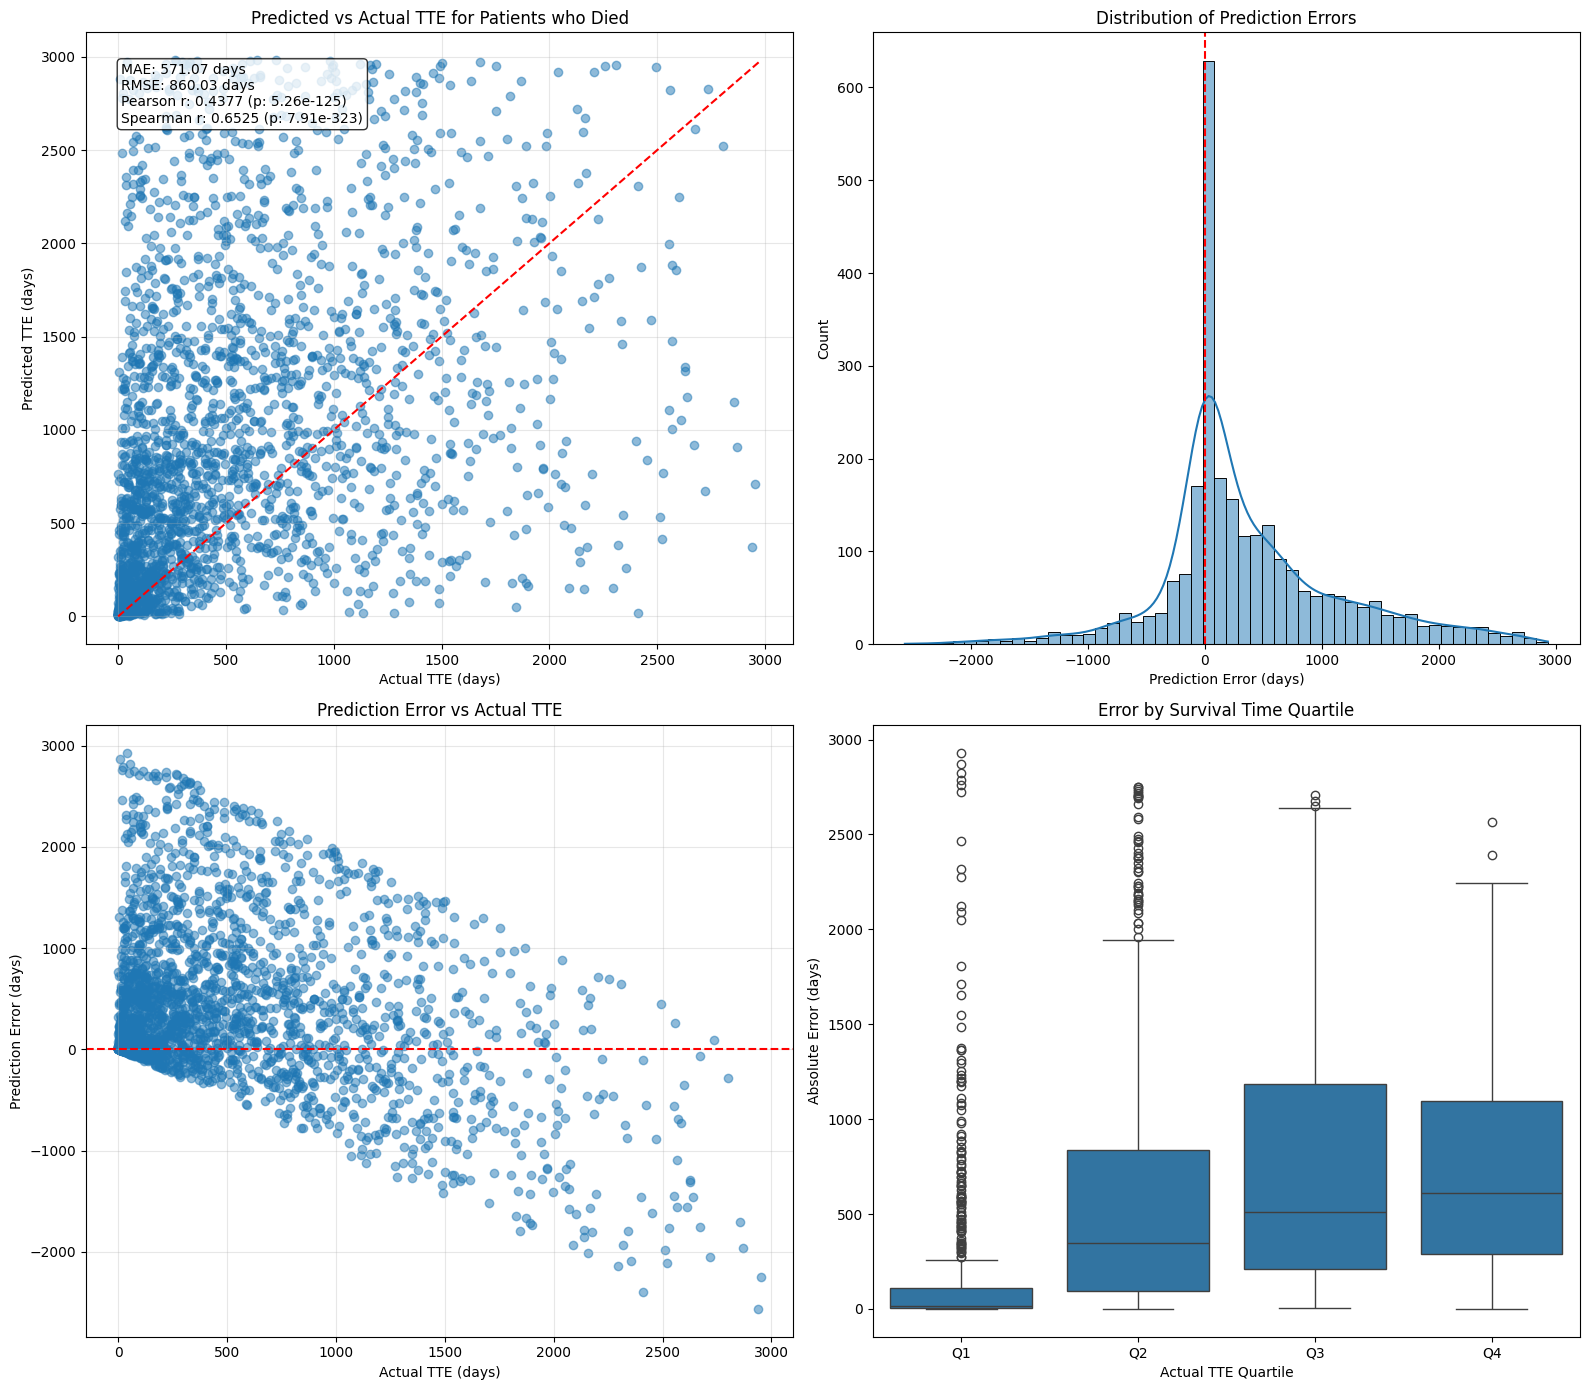


--- Error Analysis by TTE Quartile ---
                      tte         predicted_death_tte_k100                    error               abs_error            
                     mean  median                     mean       median        mean      median        mean      median
tte_quartile                                                                                                           
Q1              19.642750    16.0               193.200912    28.649028  173.558161   13.636415  177.843248   17.821267
Q2             142.158133   133.5               721.304255   526.043878  579.146123  348.493125  602.879915  348.493125
Q3             460.846154   444.0              1158.915866   938.180332  698.069712  507.743104  771.841565  511.246047
Q4            1316.211712  1193.5              1362.757117  1264.236981   46.545406    7.765733  734.490581  609.854663


<ipython-input-32-0a45d2cd0dba>:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_analysis = died_df.groupby('tte_quartile').agg({


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Assuming real_df already contains both actual TTE ('tte') and
# predicted TTE using 100 neighbors ('predicted_death_tte_k100')

def compare_predicted_vs_actual_tte(df, prediction_col='predicted_death_tte_k100',
                                   actual_col='tte', outcome_col='outcome'):
    """
    Compare predicted TTE vs actual TTE for patients in the real dataset

    Args:
        df: DataFrame containing real patient data
        prediction_col: Column name with predicted TTE
        actual_col: Column name with actual TTE
        outcome_col: Column name with outcome (where 0 = death)
    """
    # Make a copy to avoid modifying the original dataframe
    analysis_df = df.copy()

    # Check if columns exist
    required_cols = [prediction_col, actual_col, outcome_col]
    for col in required_cols:
        if col not in analysis_df.columns:
            raise ValueError(f"Column '{col}' not found in the dataframe")

    # Create a subset of patients who died (outcome=0) for direct comparison
    died_df = analysis_df[analysis_df[outcome_col] == 0].copy()
    print(f"Number of patients who died: {len(died_df)}")

    # Calculate error metrics for patients who died
    mae = mean_absolute_error(died_df[actual_col], died_df[prediction_col])
    rmse = np.sqrt(mean_squared_error(died_df[actual_col], died_df[prediction_col]))
    r2 = r2_score(died_df[actual_col], died_df[prediction_col])
    pearson_corr, pearson_p = pearsonr(died_df[actual_col], died_df[prediction_col])
    spearman_corr, spearman_p = spearmanr(died_df[actual_col], died_df[prediction_col])

    print("\n--- Error Metrics for Patients who Died ---")
    print(f"Mean Absolute Error: {mae:.2f} days")
    print(f"Root Mean Squared Error: {rmse:.2f} days")
    print(f"R-squared: {r2:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
    print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")

    # Calculate prediction error
    died_df['error'] = died_df[prediction_col] - died_df[actual_col]
    died_df['abs_error'] = np.abs(died_df['error'])
    died_df['pct_error'] = died_df['error'] / died_df[actual_col] * 100

    # Summary statistics on errors
    print("\n--- Error Distribution ---")
    print(f"Mean error: {died_df['error'].mean():.2f} days")
    print(f"Median error: {died_df['error'].median():.2f} days")
    print(f"Mean absolute error: {died_df['abs_error'].mean():.2f} days")
    print(f"Median absolute error: {died_df['abs_error'].median():.2f} days")
    print(f"Mean percentage error: {died_df['pct_error'].mean():.2f}%")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Scatter plot with diagonal line
    ax = axes[0, 0]
    ax.scatter(died_df[actual_col], died_df[prediction_col], alpha=0.5)
    max_val = max(died_df[actual_col].max(), died_df[prediction_col].max())
    ax.plot([0, max_val], [0, max_val], 'r--')
    ax.set_xlabel('Actual TTE (days)')
    ax.set_ylabel('Predicted TTE (days)')
    ax.set_title('Predicted vs Actual TTE for Patients who Died')
    ax.grid(alpha=0.3)

    # Add correlation and error metrics to the plot
    text = (f"MAE: {mae:.2f} days\nRMSE: {rmse:.2f} days\n"
            f"Pearson r: {pearson_corr:.4f} (p: {pearson_p:.2e})\n"
            f"Spearman r: {spearman_corr:.4f} (p: {spearman_p:.2e})")
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 2. Histogram of errors
    ax = axes[0, 1]
    sns.histplot(died_df['error'], kde=True, ax=ax)
    ax.axvline(x=0, color='r', linestyle='--')
    ax.set_xlabel('Prediction Error (days)')
    ax.set_title('Distribution of Prediction Errors')

    # 3. Error vs actual TTE
    ax = axes[1, 0]
    ax.scatter(died_df[actual_col], died_df['error'], alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Actual TTE (days)')
    ax.set_ylabel('Prediction Error (days)')
    ax.set_title('Prediction Error vs Actual TTE')
    ax.grid(alpha=0.3)

    # 4. Box plot of absolute errors by TTE quartile
    ax = axes[1, 1]
    died_df['tte_quartile'] = pd.qcut(died_df[actual_col], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    sns.boxplot(x='tte_quartile', y='abs_error', data=died_df, ax=ax)
    ax.set_xlabel('Actual TTE Quartile')
    ax.set_ylabel('Absolute Error (days)')
    ax.set_title('Error by Survival Time Quartile')

    plt.tight_layout()
    plt.savefig('tte_prediction_analysis.png', dpi=300)
    plt.show()

    # Analyze prediction bias by TTE quartile
    quartile_analysis = died_df.groupby('tte_quartile').agg({
        actual_col: ['mean', 'median'],
        prediction_col: ['mean', 'median'],
        'error': ['mean', 'median'],
        'abs_error': ['mean', 'median']
    })

    print("\n--- Error Analysis by TTE Quartile ---")
    print(quartile_analysis)

    return died_df

# Run the analysis
try:
    comparison_df = compare_predicted_vs_actual_tte(
        real_df,
        prediction_col='predicted_death_tte_k100',  # Adjust if your column name is different
        actual_col='tte',
        outcome_col='outcome'
    )

    # Optional: Save the comparison results
    comparison_df.to_csv('tte_prediction_comparison.csv', index=False)

except Exception as e:
    print(f"Error during analysis: {str(e)}")
    import traceback
    traceback.print_exc()

Original C-statistics:
Prediction model: 0.8512
MELD score: 0.8521
Difference: -0.0009

Converted to standard format:
Prediction model: 0.1488
MELD score: 0.1479
Difference: 0.0009

Running 100 bootstrap iterations...
Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100

Results (in standard c-index format):
Mean difference: 0.0009
95% CI: [-0.0058, 0.0064]
p-value: 0.4000
The difference is not statistically significant (p >= 0.05)
The 95% CI includes zero, suggesting no significant difference


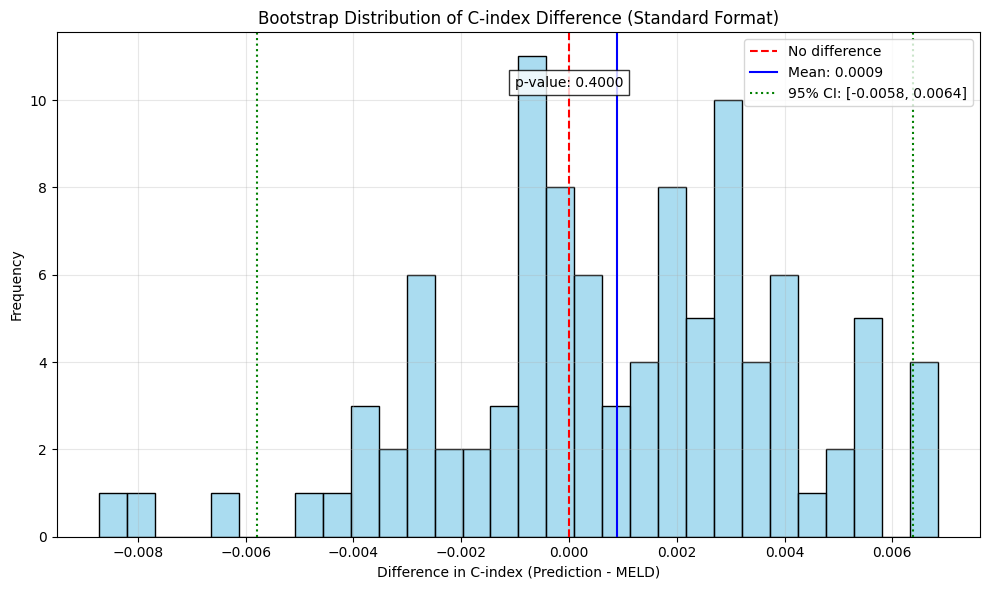

In [57]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index

def simple_bootstrap_c_index(df, pred_col='predicted_death_tte_k100', meld_col='meld3', t=90, n_bootstraps=100):
    """
    Ultra-simplified bootstrap analysis that works with inverted c-indices
    """
    # Prepare data for survival analysis at time t
    df_t = df.copy()
    df_t['event'] = (df_t['outcome'] == 0).astype(int)
    mask = df_t['tte'] > t
    df_t.loc[mask, 'tte'] = t
    df_t.loc[mask, 'event'] = 0

    # Get actual observed c-index values
    c_pred_orig = concordance_index(df_t['tte'], df_t[pred_col], df_t['event'])
    c_meld_orig = concordance_index(df_t['tte'], -df_t[meld_col], df_t['event'])
    diff_orig = c_pred_orig - c_meld_orig

    # Print original values to verify
    print(f"Original C-statistics:")
    print(f"Prediction model: {c_pred_orig:.4f}")
    print(f"MELD score: {c_meld_orig:.4f}")
    print(f"Difference: {diff_orig:.4f}")

    # Convert to "normal" format for easier interpretation
    c_pred_normal = 1 - c_pred_orig
    c_meld_normal = 1 - c_meld_orig
    diff_normal = c_pred_normal - c_meld_normal

    print(f"\nConverted to standard format:")
    print(f"Prediction model: {c_pred_normal:.4f}")
    print(f"MELD score: {c_meld_normal:.4f}")
    print(f"Difference: {diff_normal:.4f}")

    # Bootstrap the difference
    diffs_inverted = []

    print(f"\nRunning {n_bootstraps} bootstrap iterations...")
    for i in range(n_bootstraps):
        if (i+1) % 10 == 0:
            print(f"Progress: {i+1}/{n_bootstraps}")

        # Sample with replacement
        indices = np.random.choice(len(df_t), len(df_t), replace=True)
        boot_df = df_t.iloc[indices]

        # Calculate c-indices exactly as we did for the original
        c_pred = concordance_index(boot_df['tte'], boot_df[pred_col], boot_df['event'])
        c_meld = concordance_index(boot_df['tte'], -boot_df[meld_col], boot_df['event'])
        diff = c_pred - c_meld
        diffs_inverted.append(diff)

    # Convert bootstrap differences to standard format
    diffs_normal = [-d for d in diffs_inverted]  # Flip sign when converting

    # Convert to numpy array!
    diffs_normal = np.array(diffs_normal)

    # Calculate statistics on normal-scale differences
    mean_diff = np.mean(diffs_normal)
    ci = np.percentile(diffs_normal, [2.5, 97.5])
    p_value = np.mean(diffs_normal <= 0) if diff_normal > 0 else np.mean(diffs_normal >= 0)

    print("\nResults (in standard c-index format):")
    print(f"Mean difference: {mean_diff:.4f}")
    print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"p-value: {p_value:.4f}")

    # Determine significance
    if p_value < 0.05:
        print("The difference is statistically significant (p < 0.05)")
    else:
        print("The difference is not statistically significant (p >= 0.05)")

    if ci[0] <= 0 and ci[1] >= 0:
        print("The 95% CI includes zero, suggesting no significant difference")
    else:
        print("The 95% CI does not include zero, suggesting a significant difference")

    return {
        'orig_diff_inverted': diff_orig,
        'orig_diff_normal': diff_normal,
        'mean_diff': mean_diff,
        'ci': ci,
        'p_value': p_value,
        'diffs_normal': diffs_normal
    }

# Run the simplified bootstrap
results = simple_bootstrap_c_index(real_df, n_bootstraps=100)

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(results['diffs_normal'], bins=30, alpha=0.7, color='skyblue')
plt.axvline(x=0, color='r', linestyle='--', label='No difference')
plt.axvline(x=results['mean_diff'], color='blue', linestyle='-',
           label=f'Mean: {results["mean_diff"]:.4f}')
plt.axvline(x=results['ci'][0], color='green', linestyle=':',
           label=f'95% CI: [{results["ci"][0]:.4f}, {results["ci"][1]:.4f}]')
plt.axvline(x=results['ci'][1], color='green', linestyle=':')

plt.xlabel('Difference in C-index (Prediction - MELD)')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of C-index Difference (Standard Format)')
plt.legend()

# Add p-value annotation
plt.text(0, plt.ylim()[1]*0.9,
        f'p-value: {results["p_value"]:.4f}',
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('c_index_bootstrap.png', dpi=300)
plt.show()

In [36]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte_k100']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte_k100', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte_k100', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte_k100', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.897          0.898             0.900
1    14           0.900          0.902             0.904
2    30           0.887          0.892             0.893
3    90           0.851          0.852             0.855
4   180           0.823          0.822             0.826
5   360           0.799          0.797             0.801

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.998     1.164     0.008      0.0
1    14      0.998     1.180     0.000      0.0
2    30      0.999     1.194     0.000      0.0
3    90      1.000     1.181     0.000      0.0
4   180      1.000     1.164     0.000      0.0
5   360      1.000     1.146     0.000      0.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

############################################################################
# 1. We no longer force 'death_event' for embedding. We keep outcome as is.
#    We'll compute a winner-outcome among neighbors: 0=death,1=censored,2=tx
############################################################################

# (No need to redefine outcome columns here, unless you need them for something else)
# Just ensure that syn_df_processed has columns: ['tte', 'outcome', ...others...]

############################################################################
# 2. Set up nearest neighbor search using synthetic embeddings (unchanged).
############################################################################
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

############################################################################
# 3. Define a helper function for Weighted Median of TTE
############################################################################
def weighted_median_tte(ttes, distances, alpha=1e-6):
    """
    Compute a weighted median of 'ttes' using inverse-distance weights = 1/(distance + alpha).
    1) Sort by TTE ascending
    2) Accumulate weights until we reach 50% of total
    3) Return that TTE

    Returns np.nan if ttes is empty.
    """
    n = len(ttes)
    if n == 0:
        return np.nan

    # inverse-distance weights
    w = 1.0 / (distances + alpha)

    # sort by TTE
    order = np.argsort(ttes)
    ttes_sorted = ttes[order]
    w_sorted = w[order]

    total_w = np.sum(w_sorted)
    cum_w = 0.0
    for t, weight in zip(ttes_sorted, w_sorted):
        cum_w += weight
        if cum_w >= 0.5 * total_w:
            return t
    # fallback if something unexpected
    return ttes_sorted[-1]

############################################################################
# 4. Define a function to compute "winner-takes-all" TTE for each real patient
############################################################################
def compute_winner_takes_all_tte(idx):
    """
    For patient i:
      - gather neighbors from syn_df_processed
      - find the most frequent outcome among them (0,1,2)
      - restrict to that outcome group only
      - compute weighted median TTE among that group
    """
    # neighbor indices & distances
    neighbor_idxs = indices_all[idx]
    neighbor_dist = distances_all[idx]

    # retrieve the synthetic rows for these neighbors
    neighbors = syn_df_processed.iloc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dist

    # find the "winner" outcome
    outcome_counts = neighbors['outcome'].value_counts()  # might be 0,1,2
    winner_outcome = outcome_counts.idxmax()              # largest count

    # restrict to that outcome group
    subset = neighbors[neighbors['outcome'] == winner_outcome]
    if len(subset) == 0:
        return np.nan  # no neighbors of that outcome? fallback

    # compute weighted median TTE
    ttes = subset['tte'].values
    dists = subset['dist'].values
    wmed = weighted_median_tte(ttes, dists, alpha=1e-6)
    return wmed

############################################################################
# 5. Compute the predicted TTE for each real patient in parallel
############################################################################
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing winner-takes-all TTE", total=n_real)) as progress_bar:
    predicted_wta_ttes = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_winner_takes_all_tte)(i) for i in range(n_real)
    )
predicted_wta_ttes = np.array(predicted_wta_ttes)

############################################################################
# 6. Store in real_df
############################################################################
real_df['predicted_wta_tte'] = predicted_wta_ttes

# Optional: Check results
print(real_df[['predicted_wta_tte']].head())




Computing winner-takes-all TTE:   0%|          | 0/18328 [00:00<?, ?it/s]

  0%|          | 0/18328 [00:00<?, ?it/s]

   predicted_wta_tte
0          11.000000
1          46.021905
2          37.000000
3          48.441460
4          91.593468


Time-Dependent AUC (Composite Outcome - Death or Transplant):

Time	N at risk	Events	Event rate	AUC WTA		AUC MELD-3
--------------------------------------------------------------------------------
7	18324		3233	17.6%	0.876		0.885
14	18314		4580	25.0%	0.880		0.886
30	18293		6182	33.8%	0.874		0.877
90	18206		8674	47.6%	0.839		0.840
180	18091		10422	57.6%	0.807		0.812
360	17912		11977	66.9%	0.781		0.788


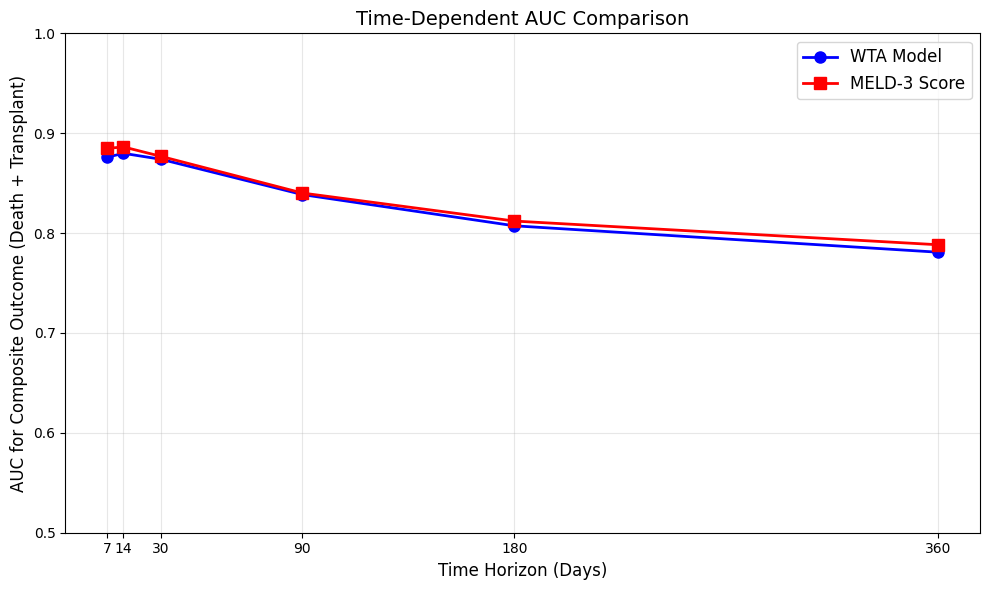

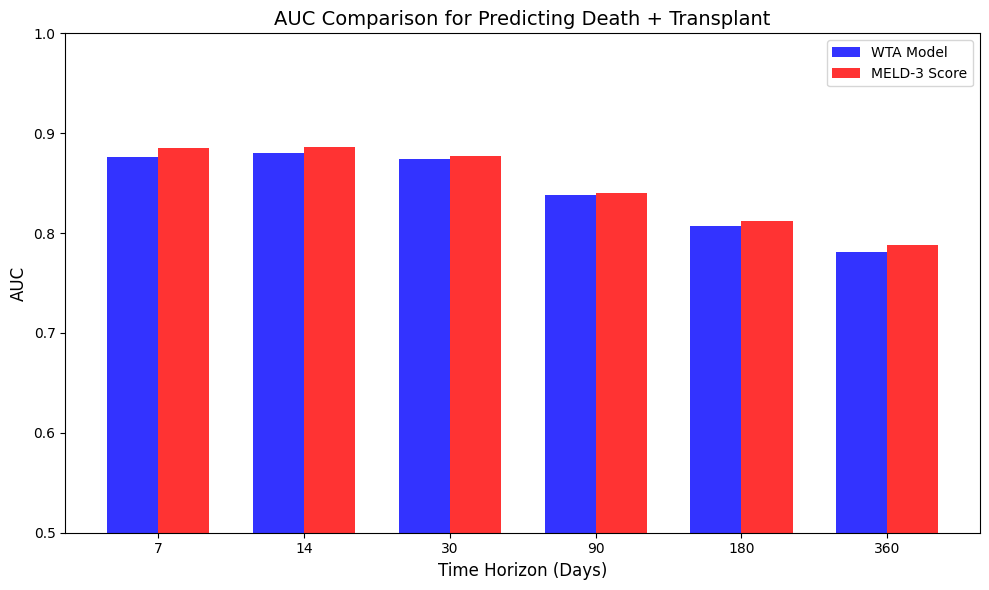

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

# For each time point, calculate the time-dependent AUC
for t in time_points:
    # 1. Define the "at-risk" set:
    # Include all patients who haven't had any event before time t or had event by time t
    at_risk_mask = (
        (real_df['tte'] >= t) |  # Still being followed
        ((real_df['outcome'].isin([0, 2])) & (real_df['tte'] <= t))  # Or had event before t
    )

    # Filter the dataframe
    df_at_risk = real_df[at_risk_mask].copy()

    # 2. Define the event indicator:
    # 1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 3. Get risk scores (higher score = higher risk)
    # For predicted_wta_tte, lower predicted time = higher risk
    risk_wta = -df_at_risk['predicted_wta_tte']
    # For meld3, higher score = higher risk
    risk_meld3 = df_at_risk['meld3']

    # 4. Calculate AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_wta = roc_auc_score(event_indicator, risk_wta)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_wta = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'Event_rate': event_indicator.mean() * 100,
        'AUC_wta': auc_wta,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and format columns
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_events_by_t'] = results_df['N_events_by_t'].astype(int)

# Display results in a nicely formatted table
print("Time-Dependent AUC (Composite Outcome - Death or Transplant):")
print("\nTime\tN at risk\tEvents\tEvent rate\tAUC WTA\t\tAUC MELD-3")
print("-" * 80)

for _, row in results_df.iterrows():
    t = int(row['Time'])
    n_risk = int(row['N_at_risk'])
    n_events = int(row['N_events_by_t'])
    event_rate = f"{row['Event_rate']:.1f}%"

    if pd.notnull(row['AUC_wta']):
        auc_wta = f"{row['AUC_wta']:.3f}"
        auc_meld3 = f"{row['AUC_meld3']:.3f}"
    else:
        auc_wta = "N/A"
        auc_meld3 = "N/A"

    print(f"{t}\t{n_risk}\t\t{n_events}\t{event_rate}\t{auc_wta}\t\t{auc_meld3}")

# Create a visualization comparing AUCs at each time point
plt.figure(figsize=(10, 6))

# Line plot
plt.plot(results_df['Time'], results_df['AUC_wta'], 'b-o', linewidth=2, markersize=8, label='WTA Model')
plt.plot(results_df['Time'], results_df['AUC_meld3'], 'r-s', linewidth=2, markersize=8, label='MELD-3 Score')

# Customize plot
plt.xlabel('Time Horizon (Days)', fontsize=12)
plt.ylabel('AUC for Composite Outcome (Death + Transplant)', fontsize=12)
plt.title('Time-Dependent AUC Comparison', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(time_points)
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

# Create a bar chart comparing AUCs at each time point
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(time_points))

plt.bar(index, results_df['AUC_wta'], bar_width, alpha=0.8, color='blue', label='WTA Model')
plt.bar(index + bar_width, results_df['AUC_meld3'], bar_width, alpha=0.8, color='red', label='MELD-3 Score')

plt.xlabel('Time Horizon (Days)', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC Comparison for Predicting Death + Transplant', fontsize=14)
plt.xticks(index + bar_width/2, time_points)
plt.ylim(0.5, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_wta_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_wta_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_wta_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_wta_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-pr


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.882          0.910             0.910
1    14           0.882          0.907             0.907
2    30           0.872          0.894             0.894
3    90           0.830          0.851             0.851
4   180           0.796          0.815             0.816
5   360           0.765          0.783             0.784

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.979     1.153     0.001      0.0
1    14      0.990     1.173     0.002      0.0
2    30      0.996     1.172     0.007      0.0
3    90      1.000     1.153     0.012      0.0
4   180      1.000     1.128     0.002      0.0
5   360      1.000     1.103     0.000      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def compute_composite_proportional_tte(
    idx,
    syn_df,
    indices_all,
    real_df
):
    """
    For a single real patient i:
      1. Gather the K neighbors from syn_df (via indices_all[i]).
      2. Split them by outcome:
         - 0 = death
         - 1 = censored
         - 2 = transplant
      3. Compute the median TTE within each group.
      4. Multiply each median by that group's proportion,
         then sum to get final 'composite' TTE.
    """
    neighbor_idxs = indices_all[idx]
    neighbors = syn_df.iloc[neighbor_idxs]

    # Count how many neighbors belong to each outcome
    is_death = (neighbors['outcome'] == 0)
    is_cens = (neighbors['outcome'] == 1)
    is_tx   = (neighbors['outcome'] == 2)

    n_death = is_death.sum()
    n_cens  = is_cens.sum()
    n_tx    = is_tx.sum()
    total   = len(neighbors)

    if total == 0:
        # Edge case: no neighbors at all (unlikely)
        return np.nan

    # Proportions
    p_death = n_death / total
    p_cens  = n_cens  / total
    p_tx    = n_tx    / total

    # Median TTE for each group
    # If a group is empty, median => np.nan
    def median_tte_in_group(mask):
        if mask.sum() == 0:
            return np.nan
        else:
            return np.median(neighbors.loc[mask, 'tte'].values)

    med_death = median_tte_in_group(is_death)
    med_cens  = median_tte_in_group(is_cens)
    med_tx    = median_tte_in_group(is_tx)

    # Weighted sum of medians:
    # If any group is empty => p=0 => no contribution
    # If median is np.nan => interpret as 0 or skip
    # Here we do a simple approach: if group is non-empty, we
    # multiply proportion by median; if median is NaN, skip or set 0.
    def safe_contrib(p, med):
        # If median is nan => treat as 0 contribution
        if np.isnan(med):
            return 0.0
        else:
            return p * med

    tte_final = (
        safe_contrib(p_death, med_death)
      + safe_contrib(p_cens,  med_cens)
      + safe_contrib(p_tx,    med_tx)
    )
    return tte_final


def compute_proportional_composite_predictions(
    syn_df_processed,
    indices_all,
    real_df
):
    """
    Loop over all real patients in parallel and compute 'composite proportional TTE'.
    """
    n_real = len(real_df)
    with tqdm_joblib(tqdm(desc="Computing composite proportional TTE", total=n_real)) as progress_bar:
        predicted_ttes = Parallel(n_jobs=-1, backend="threading")(
            delayed(compute_composite_proportional_tte)(i, syn_df_processed, indices_all, real_df)
            for i in range(n_real)
        )
    return np.array(predicted_ttes)


###############################################################################
# EXAMPLE USAGE:
###############################################################################
# 1) We assume we already have:
#   - syn_df_processed: synthetic DataFrame with columns ['tte','outcome', ...].
#   - indices_all: shape (n_real, K), neighbors for each real patient.
#   - real_df: real DataFrame to store results.

# 2) Run the function
predicted_composite = compute_proportional_composite_predictions(
     syn_df_processed,
     indices_all,
     real_df
 )
real_df['predicted_composite_tte'] = predicted_composite

# 3) Inspect a sample
print(real_df[['predicted_composite_tte','tte','outcome']].head())





Computing composite proportional TTE:   0%|          | 0/18328 [00:00<?, ?it/s]

  0%|          | 0/18328 [00:00<?, ?it/s]

Computing local medians:   0%|          | 0/18328 [05:32<?, ?it/s]


   predicted_composite_tte    tte  outcome
0               159.958517   15.0        2
1               378.222958  668.0        0
2               238.642368   39.0        2
3               188.321507  437.0        2
4               682.892610  703.0        0


Time-Dependent AUC (Composite Outcome - Death or Transplant):

Time	N at risk	Events	Event rate	AUC WTA		AUC MELD-3
--------------------------------------------------------------------------------
7	18324		3233	17.6%	0.866		0.885
14	18314		4580	25.0%	0.871		0.886
30	18293		6182	33.8%	0.867		0.877
90	18206		8674	47.6%	0.835		0.840
180	18091		10422	57.6%	0.808		0.812
360	17912		11977	66.9%	0.784		0.788


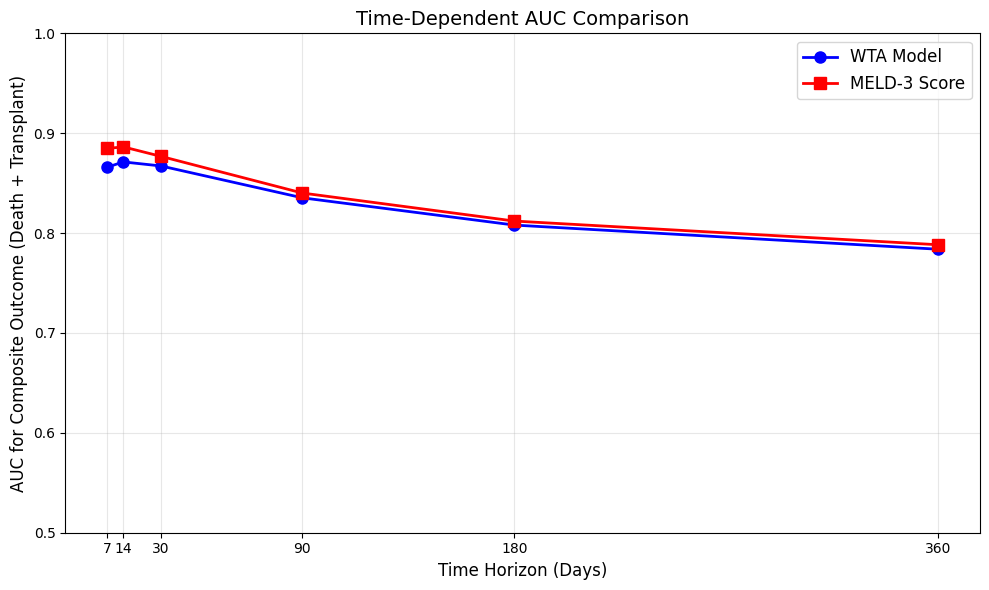

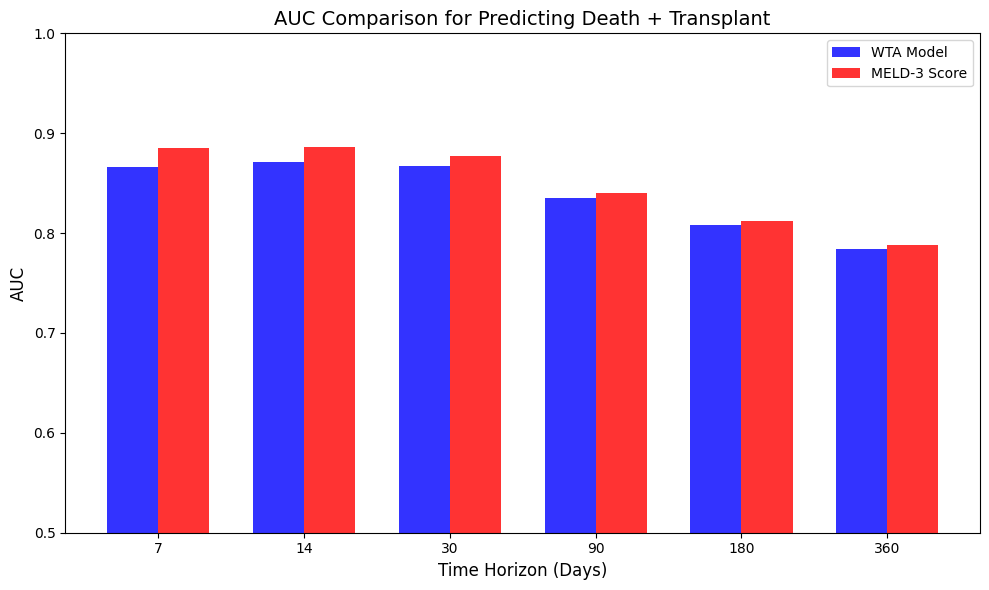

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

# For each time point, calculate the time-dependent AUC
for t in time_points:
    # 1. Define the "at-risk" set:
    # Include all patients who haven't had any event before time t or had event by time t
    at_risk_mask = (
        (real_df['tte'] >= t) |  # Still being followed
        ((real_df['outcome'].isin([0, 2])) & (real_df['tte'] <= t))  # Or had event before t
    )

    # Filter the dataframe
    df_at_risk = real_df[at_risk_mask].copy()

    # 2. Define the event indicator:
    # 1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 3. Get risk scores (higher score = higher risk)
    # For predicted_wta_tte, lower predicted time = higher risk
    risk_wta = -df_at_risk['predicted_composite_tte']
    # For meld3, higher score = higher risk
    risk_meld3 = df_at_risk['meld3']

    # 4. Calculate AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_wta = roc_auc_score(event_indicator, risk_wta)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_wta = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'Event_rate': event_indicator.mean() * 100,
        'AUC_wta': auc_wta,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and format columns
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_events_by_t'] = results_df['N_events_by_t'].astype(int)

# Display results in a nicely formatted table
print("Time-Dependent AUC (Composite Outcome - Death or Transplant):")
print("\nTime\tN at risk\tEvents\tEvent rate\tAUC WTA\t\tAUC MELD-3")
print("-" * 80)

for _, row in results_df.iterrows():
    t = int(row['Time'])
    n_risk = int(row['N_at_risk'])
    n_events = int(row['N_events_by_t'])
    event_rate = f"{row['Event_rate']:.1f}%"

    if pd.notnull(row['AUC_wta']):
        auc_wta = f"{row['AUC_wta']:.3f}"
        auc_meld3 = f"{row['AUC_meld3']:.3f}"
    else:
        auc_wta = "N/A"
        auc_meld3 = "N/A"

    print(f"{t}\t{n_risk}\t\t{n_events}\t{event_rate}\t{auc_wta}\t\t{auc_meld3}")

# Create a visualization comparing AUCs at each time point
plt.figure(figsize=(10, 6))

# Line plot
plt.plot(results_df['Time'], results_df['AUC_wta'], 'b-o', linewidth=2, markersize=8, label='WTA Model')
plt.plot(results_df['Time'], results_df['AUC_meld3'], 'r-s', linewidth=2, markersize=8, label='MELD-3 Score')

# Customize plot
plt.xlabel('Time Horizon (Days)', fontsize=12)
plt.ylabel('AUC for Composite Outcome (Death + Transplant)', fontsize=12)
plt.title('Time-Dependent AUC Comparison', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(time_points)
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

# Create a bar chart comparing AUCs at each time point
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(time_points))

plt.bar(index, results_df['AUC_wta'], bar_width, alpha=0.8, color='blue', label='WTA Model')
plt.bar(index + bar_width, results_df['AUC_meld3'], bar_width, alpha=0.8, color='red', label='MELD-3 Score')

plt.xlabel('Time Horizon (Days)', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC Comparison for Predicting Death + Transplant', fontsize=14)
plt.xticks(index + bar_width/2, time_points)
plt.ylim(0.5, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.875          0.910             0.909
1    14           0.878          0.907             0.908
2    30           0.871          0.894             0.895
3    90           0.831          0.851             0.852
4   180           0.800          0.815             0.818
5   360           0.770          0.783             0.786

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.997     1.153       0.0      0.0
1    14      0.997     1.160       0.0      0.0
2    30      0.997     1.140       0.0      0.0
3    90      0.998     1.121       0.0      0.0
4   180      0.999     1.101       0.0      0.0
5   360      0.999     1.081       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

############################################################################
# 1. We no longer force 'death_event' for embedding. We keep outcome as is.
#    We'll do "winner-outcome" among neighbors: 0=death,1=censored,2=tx
############################################################################

# syn_df_processed should have columns: ['tte','outcome',...]
# syn_embeddings: shape [n_syn, embed_dim]
# real_embeddings: shape [n_real, embed_dim]

############################################################################
# 2. KNN setup
############################################################################
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

############################################################################
# 3. Define the function for "winner-takes-all" but with a simple median
############################################################################
def compute_winner_takes_all_median(idx):
    """
    For each real patient i:
      - gather neighbors from syn_df_processed
      - find the most frequent outcome among {0,1,2}
      - restrict to that outcome group only
      - compute the *unweighted* median tte among that group
      - return that median
    """
    neighbor_idxs = indices_all[idx]
    neighbors = syn_df_processed.iloc[neighbor_idxs].copy()

    # find the "winning" outcome
    outcome_counts = neighbors['outcome'].value_counts()  # could be 0,1,2
    winner_outcome = outcome_counts.idxmax()  # the most frequent

    # restrict neighbors to the winner outcome
    subset = neighbors[neighbors['outcome'] == winner_outcome]
    if len(subset) == 0:
        return np.nan

    ttes = subset['tte'].values
    return np.median(ttes)  # simple, unweighted median

############################################################################
# 4. Compute the predicted TTE for each real patient in parallel
############################################################################
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing winner-takes-all Median TTE", total=n_real)) as progress_bar:
    predicted_wta_ttes = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_winner_takes_all_median)(i) for i in range(n_real)
    )
predicted_wta_ttes = np.array(predicted_wta_ttes)

############################################################################
# 5. Store in real_df
############################################################################
real_df['predicted_wta_tte'] = predicted_wta_ttes

# Check results
print(real_df[['predicted_wta_tte']].head())


Computing winner-takes-all Median TTE:   0%|          | 0/18328 [00:00<?, ?it/s]

  0%|          | 0/18328 [00:00<?, ?it/s]

   predicted_wta_tte
0          11.000000
1          49.995401
2          37.000000
3          48.441460
4          84.530081


Time-Dependent AUC (Composite Outcome - Death or Transplant):

Time	N at risk	Events	Event rate	AUC WTA		AUC MELD-3
--------------------------------------------------------------------------------
7	18324		3233	17.6%	0.879		0.885
14	18314		4580	25.0%	0.883		0.886
30	18293		6182	33.8%	0.878		0.877
90	18206		8674	47.6%	0.844		0.840
180	18091		10422	57.6%	0.814		0.812
360	17912		11977	66.9%	0.787		0.788


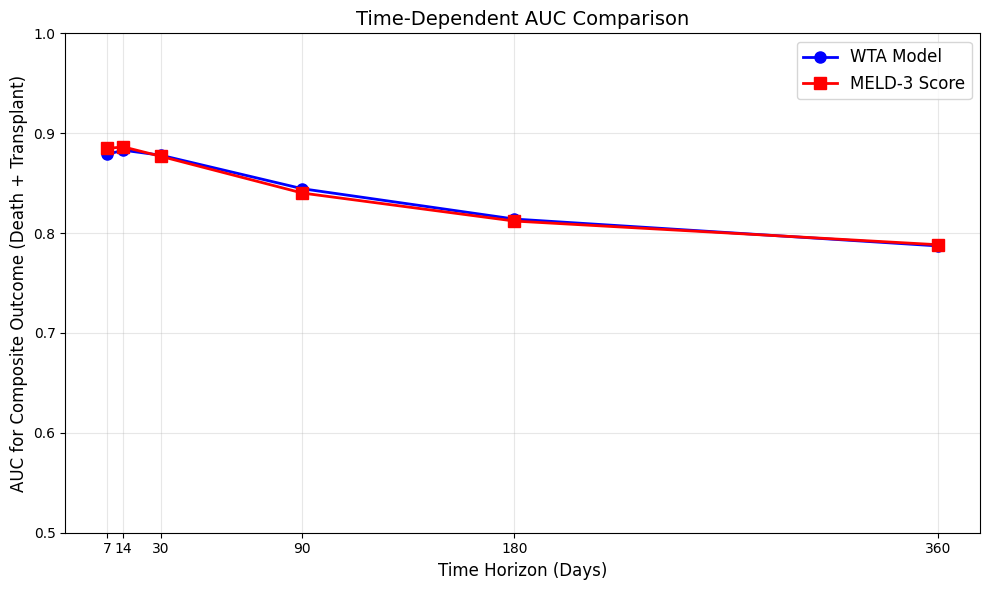

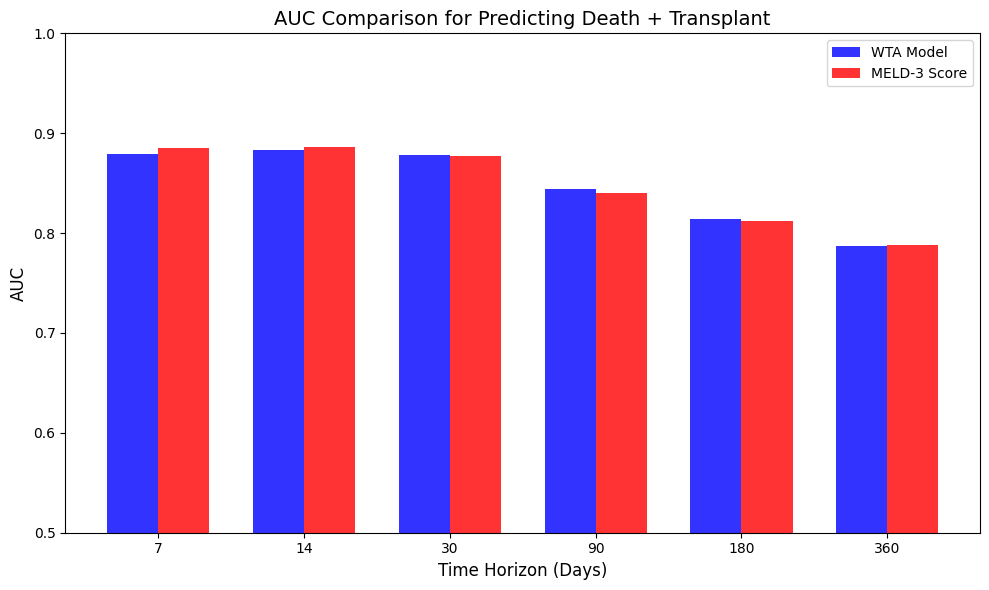

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

# For each time point, calculate the time-dependent AUC
for t in time_points:
    # 1. Define the "at-risk" set:
    # Include all patients who haven't had any event before time t or had event by time t
    at_risk_mask = (
        (real_df['tte'] >= t) |  # Still being followed
        ((real_df['outcome'].isin([0, 2])) & (real_df['tte'] <= t))  # Or had event before t
    )

    # Filter the dataframe
    df_at_risk = real_df[at_risk_mask].copy()

    # 2. Define the event indicator:
    # 1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 3. Get risk scores (higher score = higher risk)
    # For predicted_wta_tte, lower predicted time = higher risk
    risk_wta = -df_at_risk['predicted_wta_tte']
    # For meld3, higher score = higher risk
    risk_meld3 = df_at_risk['meld3']

    # 4. Calculate AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_wta = roc_auc_score(event_indicator, risk_wta)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_wta = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'Event_rate': event_indicator.mean() * 100,
        'AUC_wta': auc_wta,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and format columns
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_events_by_t'] = results_df['N_events_by_t'].astype(int)

# Display results in a nicely formatted table
print("Time-Dependent AUC (Composite Outcome - Death or Transplant):")
print("\nTime\tN at risk\tEvents\tEvent rate\tAUC WTA\t\tAUC MELD-3")
print("-" * 80)

for _, row in results_df.iterrows():
    t = int(row['Time'])
    n_risk = int(row['N_at_risk'])
    n_events = int(row['N_events_by_t'])
    event_rate = f"{row['Event_rate']:.1f}%"

    if pd.notnull(row['AUC_wta']):
        auc_wta = f"{row['AUC_wta']:.3f}"
        auc_meld3 = f"{row['AUC_meld3']:.3f}"
    else:
        auc_wta = "N/A"
        auc_meld3 = "N/A"

    print(f"{t}\t{n_risk}\t\t{n_events}\t{event_rate}\t{auc_wta}\t\t{auc_meld3}")

# Create a visualization comparing AUCs at each time point
plt.figure(figsize=(10, 6))

# Line plot
plt.plot(results_df['Time'], results_df['AUC_wta'], 'b-o', linewidth=2, markersize=8, label='WTA Model')
plt.plot(results_df['Time'], results_df['AUC_meld3'], 'r-s', linewidth=2, markersize=8, label='MELD-3 Score')

# Customize plot
plt.xlabel('Time Horizon (Days)', fontsize=12)
plt.ylabel('AUC for Composite Outcome (Death + Transplant)', fontsize=12)
plt.title('Time-Dependent AUC Comparison', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(time_points)
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

# Create a bar chart comparing AUCs at each time point
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(time_points))

plt.bar(index, results_df['AUC_wta'], bar_width, alpha=0.8, color='blue', label='WTA Model')
plt.bar(index + bar_width, results_df['AUC_meld3'], bar_width, alpha=0.8, color='red', label='MELD-3 Score')

plt.xlabel('Time Horizon (Days)', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC Comparison for Predicting Death + Transplant', fontsize=14)
plt.xticks(index + bar_width/2, time_points)
plt.ylim(0.5, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_wta_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_wta_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_wta_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_wta_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-pr


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.882          0.910             0.909
1    14           0.884          0.907             0.907
2    30           0.876          0.894             0.894
3    90           0.834          0.851             0.851
4   180           0.801          0.815             0.816
5   360           0.769          0.783             0.784

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.981     1.155     0.001      0.0
1    14      0.988     1.169     0.000      0.0
2    30      0.995     1.169     0.003      0.0
3    90      1.000     1.152     0.008      0.0
4   180      1.000     1.127     0.001      0.0
5   360      1.000     1.103     0.000      0.0


Winner Take All

/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing winner-takes-all TTE:   0%|          | 0/9757 [00:00<?, ?it/s]

  0%|          | 0/9757 [00:00<?, ?it/s]

   predicted_wta_tte
0           5.000000
1          83.863474
2          32.000000
3          37.000000
4           8.000000







Computing composite proportional TTE:   0%|          | 0/9757 [00:00<?, ?it/s]

  0%|          | 0/9757 [00:00<?, ?it/s]

Processing local TTEs:   0%|          | 0/9757 [07:21<?, ?it/s]


   predicted_composite_tte    tte  outcome
0                 8.900000    3.0        2
1               133.083337   93.0        0
2                98.736987   49.0        2
3                65.820186  365.0        1
4                 9.500000    2.0        2





Computing winner-takes-all Median TTE:   0%|          | 0/9757 [00:00<?, ?it/s]

  0%|          | 0/9757 [00:00<?, ?it/s]

   predicted_wta_tte
0           5.000000
1          80.158615
2          41.029223
3          33.500000
4           8.000000



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.884          0.915             0.914
1    14           0.877          0.899             0.899
2    30           0.868          0.888             0.888
3    90           0.841          0.853             0.856
4   180           0.817          0.830             0.833
5   360           0.795          0.806             0.808

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.993     1.189     0.089      0.0
1    14      0.993     1.170     0.007      0.0
2    30      0.993     1.166     0.000      0.0
3    90      0.995     1.155     0.000      0.0
4   180      0.996     1.149     0.000      0.0
5   360      0.997     1.133     0.000      0.0


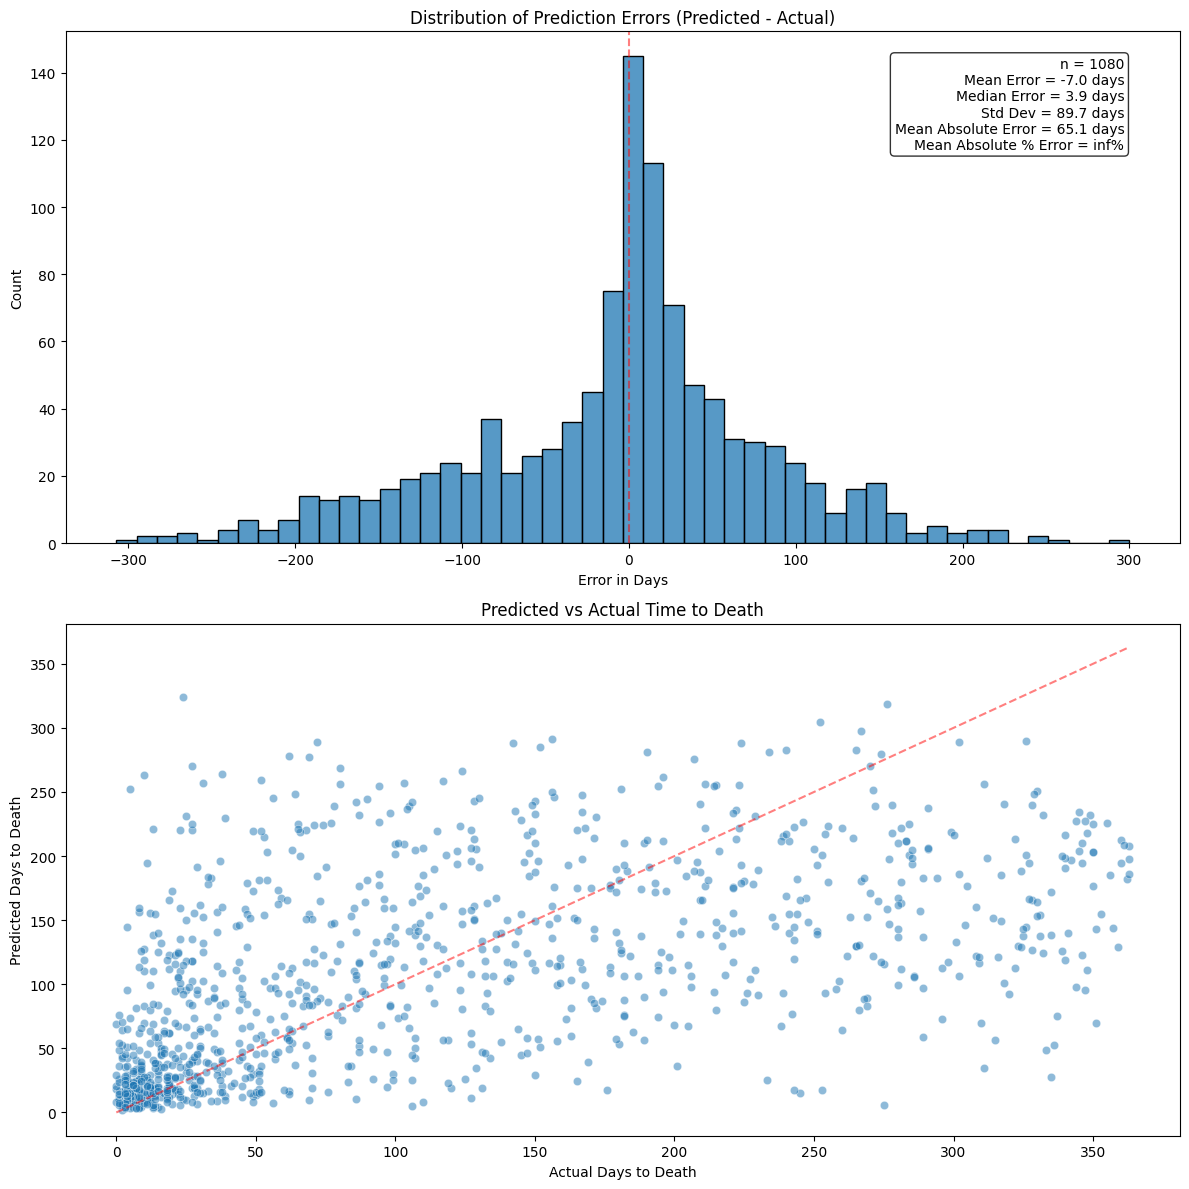


Prediction Error Statistics:
Number of death cases: 1080
Mean error: -7.0 days
Median error: 3.9 days
Standard deviation: 89.7 days
Mean absolute error: 65.1 days
Mean absolute percentage error: inf%

Error Quartiles:
count    1080.000000
mean       -7.041589
std        89.691769
min      -307.250000
25%       -51.122058
50%         3.925000
75%        40.062542
max       299.989483
Name: error, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate prediction errors (predicted - actual)
death_cases['error'] = death_cases['predicted_composite_tte'] - death_cases['tte']

# Calculate summary statistics
error_stats = {
    'n': len(death_cases),
    'mean': death_cases['error'].mean(),
    'median': death_cases['error'].median(),
    'std': death_cases['error'].std(),
    'mae': death_cases['error'].abs().mean(),
    'mape': (death_cases['error'].abs() / death_cases['tte']).mean() * 100
}

# Create figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 1. Error Distribution (Histogram)
sns.histplot(data=death_cases, x='error', bins=50, ax=ax1)
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Distribution of Prediction Errors (Predicted - Actual)')
ax1.set_xlabel('Error in Days')
ax1.set_ylabel('Count')

# Add error statistics to plot
stats_text = f'n = {error_stats["n"]}\n'
stats_text += f'Mean Error = {error_stats["mean"]:.1f} days\n'
stats_text += f'Median Error = {error_stats["median"]:.1f} days\n'
stats_text += f'Std Dev = {error_stats["std"]:.1f} days\n'
stats_text += f'Mean Absolute Error = {error_stats["mae"]:.1f} days\n'
stats_text += f'Mean Absolute % Error = {error_stats["mape"]:.1f}%'

ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Scatter Plot (Predicted vs Actual)
sns.scatterplot(data=death_cases, x='tte', y='predicted_composite_tte', alpha=0.5, ax=ax2)
ax2.plot([0, death_cases['tte'].max()], [0, death_cases['tte'].max()], 'r--', alpha=0.5)
ax2.set_title('Predicted vs Actual Time to Death')
ax2.set_xlabel('Actual Days to Death')
ax2.set_ylabel('Predicted Days to Death')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nPrediction Error Statistics:")
print(f"Number of death cases: {error_stats['n']}")
print(f"Mean error: {error_stats['mean']:.1f} days")
print(f"Median error: {error_stats['median']:.1f} days")
print(f"Standard deviation: {error_stats['std']:.1f} days")
print(f"Mean absolute error: {error_stats['mae']:.1f} days")
print(f"Mean absolute percentage error: {error_stats['mape']:.1f}%")

# Optional: Calculate error quartiles
print("\nError Quartiles:")
print(death_cases['error'].describe())

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def check_actual_tte_in_neighbor_iqr(
    syn_df,         # synthetic DataFrame with 'tte'
    indices_all,    # neighbor indices (shape [n_real, K])
    real_df         # real DataFrame with 'tte' and 'outcome'
):
    """
    For each real patient i:
      1. If outcome in [0,2] (died or transplanted),
         a) gather neighbor tte distribution
         b) compute Q1, Q3
         c) check if real_df['tte'] is in [Q1, Q3]
         => store 1 or 0 in 'within_iqr'
      2. Else (outcome=1), store np.nan or 0, ignoring them
    """

    n_real = len(real_df)
    within_iqr_list = []

    for i in tqdm(range(n_real), desc="Checking actual TTE vs neighbor IQR"):
        actual_outcome = real_df.loc[i, 'outcome']
        actual_tte = real_df.loc[i, 'tte']

        # By default, mark as np.nan if not death or transplant
        if actual_outcome not in [2]:
            within_iqr_list.append(np.nan)
            continue

        # Gather neighbors
        neighbor_idxs = indices_all[i]
        neighbor_ttes = syn_df.iloc[neighbor_idxs]['tte'].values

        if len(neighbor_ttes) == 0:
            within_iqr_list.append(np.nan)
            continue

        # Compute Q1, Q3
        q1 = np.percentile(neighbor_ttes, 25)
        q3 = np.percentile(neighbor_ttes, 75)

        # Check if actual TTE is in [q1, q3]
        if q1 <= actual_tte <= q3:
            within_iqr_list.append(1)
        else:
            within_iqr_list.append(0)

    # Add to real_df
    real_df['within_iqr'] = within_iqr_list
    return real_df

# EXAMPLE USAGE:
real_df = check_actual_tte_in_neighbor_iqr(syn_df_processed, indices_all, real_df)
# Now we can see how many "death" or "transplant" patients are within IQR.
#
# Let's compute the fraction among death+transplant:
mask_event = real_df['outcome'].isin([2])
event_cases = real_df[mask_event].dropna(subset=['within_iqr'])
fraction_in_iqr = event_cases['within_iqr'].mean()
print(f"Fraction of event patients with TTE in neighbor IQR = {fraction_in_iqr:.3f}")




Checking actual TTE vs neighbor IQR:   0%|          | 0/9757 [00:00<?, ?it/s]

Checking actual TTE vs neighbor IQR:   2%|▏         | 214/9757 [00:00<00:04, 2138.65it/s]

Checking actual TTE vs neighbor IQR:   4%|▍         | 438/9757 [00:00<00:04, 2194.82it/s]

Checking actual TTE vs neighbor IQR:   7%|▋         | 690/9757 [00:00<00:03, 2337.45it/s]

Checking actual TTE vs neighbor IQR:   9%|▉         | 925/9757 [00:00<00:03, 2336.44it/s]

Checking actual TTE vs neighbor IQR:  12%|█▏        | 1161/9757 [00:00<00:03, 2339.35it/s]

Checking actual TTE vs neighbor IQR:  14%|█▍        | 1404/9757 [00:00<00:03, 2366.73it/s]

Checking actual TTE vs neighbor IQR:  17%|█▋        | 1641/9757 [00:00<00:03, 2304.84it/s]

Checking actual TTE vs neighbor IQR:  19%|█▉        | 1872/9757 [00:00<00:03, 2301.89it/s]

Checking actual TTE vs neighbor IQR:  22%|██▏       | 2103/9757 [00:00<00:03, 2272.26it/s]

Checking actual TTE vs neighbor IQR:  24%|██▍       | 2343/9757 [00:01<00:03, 2308.49it/s]

Che

Fraction of event patients with TTE in neighbor IQR = 0.649


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def compute_neighbor_iqr(idx, syn_df, indices_all):
    """
    For a single real patient i:
      1) gather neighbor TTEs
      2) define Q1 and Q3
    Returns (q1, q3).
    """
    neighbor_idxs = indices_all[idx]
    neighbor_ttes = syn_df.iloc[neighbor_idxs]['tte'].values

    # If you only want 'death (0) + transplant (2)', uncomment:
    # mask = syn_df.iloc[neighbor_idxs]['outcome'].isin([0,2])
    # neighbor_ttes = neighbor_ttes[mask]

    if len(neighbor_ttes) == 0:
        return (np.nan, np.nan)

    q1 = np.percentile(neighbor_ttes, 25)
    q3 = np.percentile(neighbor_ttes, 75)
    return (q1, q3)

def fill_iqr_columns(real_df, syn_df, indices_all):
    """
    Loop over each real patient in parallel, store Q1/Q3 in real_df.
    """
    n_real = len(real_df)
    q1_list = []
    q3_list = []

    with tqdm_joblib(tqdm(total=n_real, desc="Computing neighbor IQRs")):
        results = Parallel(n_jobs=-1, backend="threading")(
            delayed(compute_neighbor_iqr)(i, syn_df, indices_all)
            for i in range(n_real)
        )

    for q1, q3 in results:
        q1_list.append(q1)
        q3_list.append(q3)

    real_df['pred_q1'] = q1_list
    real_df['pred_q3'] = q3_list
    return real_df

# EXAMPLE USAGE:
real_df = fill_iqr_columns(real_df, syn_df_processed, indices_all)
# Now real_df has columns: pred_q1, pred_q3




Computing neighbor IQRs:   0%|          | 0/9757 [00:00<?, ?it/s]

  0%|          | 0/9757 [00:00<?, ?it/s]

In [ ]:
real_df['risk_iqr'] = -real_df['pred_q3']


In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the at-risk set:
    # Everyone who didn't get transplanted or censored before time t
    # (i.e., either died before t, or was followed for at least t days)
    at_risk_mask = (
        (df_all['outcome'] == 0) |  # died
        ((df_all['outcome'].isin([1, 2])) & (df_all['tte'] >= t))  # survived past t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred within t days, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Deaths within {t} days: {event_indicator.sum()}")
        print(f"Survivors past {t} days: {len(event_indicator) - event_indicator.sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_composite_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_within_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_within_t'] = results_df['N_deaths_within_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Risk of Death within T days, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_within_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

Total patients in dataset: 9757
Outcome distribution:
outcome
2    6137
1    2540
0    1080
Name: count, dtype: int64

At time 7:
Patients at risk: 8096
Deaths within 7 days: 120
Survivors past 7 days: 7976

Time-Dependent AUC (Risk of Death within T days, Censoring Transplant):

Time  N at risk  N deaths  AUC metric  AUC MELD-3
-------------------------------------------------------
   7      8096       120  0.916       0.940     
  14      7246       212  0.917       0.929     
  30      6423       362  0.909       0.920     
  90      5164       582  0.883       0.884     
 180      4342       796  0.854       0.857     
 360      3635      1075  0.825       0.826     


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing local medians:   0%|          | 0/9757 [00:00<?, ?it/s]

  0%|          | 0/9757 [00:00<?, ?it/s]

In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def calculate_harrells_c_90day(df):
    """
    Calculate Harrell's C-index for 90-day mortality

    Args:
        df: DataFrame containing tte, outcome, and prediction scores

    Returns:
        Dictionary with C-indices and bootstrap results
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    # Note: lifelines concordance_index expects higher predictions = higher risk
    c_metric = concordance_index(time, df['predicted_death_tte'], event)
    c_meld3 = concordance_index(time, df['meld3'], event)

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping"):
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_df = df.iloc[bootstrap_indices]

        # Prepare time and event data for bootstrap sample
        boot_time = bootstrap_df['tte'].copy()
        mask = boot_time > 90
        boot_time[mask] = 90

        boot_event = (bootstrap_df['outcome'] == 0).astype(int)
        boot_event[mask] = 0

        # Calculate C-indices for bootstrap sample
        c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
        c_boot_meld3 = concordance_index(boot_time, bootstrap_df['meld3'], boot_event)

        bootstrap_metric.append(c_boot_metric)
        bootstrap_meld3.append(c_boot_meld3)
        bootstrap_diff.append(c_boot_metric - c_boot_meld3)

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Calculate results
results = calculate_harrells_c_90day(real_df)

# Print results
print("\n90-day Mortality Harrell's C-index Results:")
print(f"\nNumber of deaths within 90 days: {results['n_deaths']}")
print(f"Number of censored: {results['n_censored']}")
print("\nPredicted Death Score:")
print(f"C-index: {results['c_metric']:.3f} (95% CI: {results['c_metric_ci'][0]:.3f}-{results['c_metric_ci'][1]:.3f})")
print("\nMELD-3:")
print(f"C-index: {results['c_meld3']:.3f} (95% CI: {results['c_meld3_ci'][0]:.3f}-{results['c_meld3_ci'][1]:.3f})")
print(f"\nP-value for difference: {results['p_value']:.3f}")


Bootstrapping: 100%|██████████| 1000/1000 [01:04<00:00, 15.51it/s]


90-day Mortality Harrell's C-index Results:

Number of deaths within 90 days: 583
Number of censored: 9174

Predicted Death Score:
C-index: 0.805 (95% CI: 0.788-0.820)

MELD-3:
C-index: 0.139 (95% CI: 0.125-0.154)

P-value for difference: 0.000


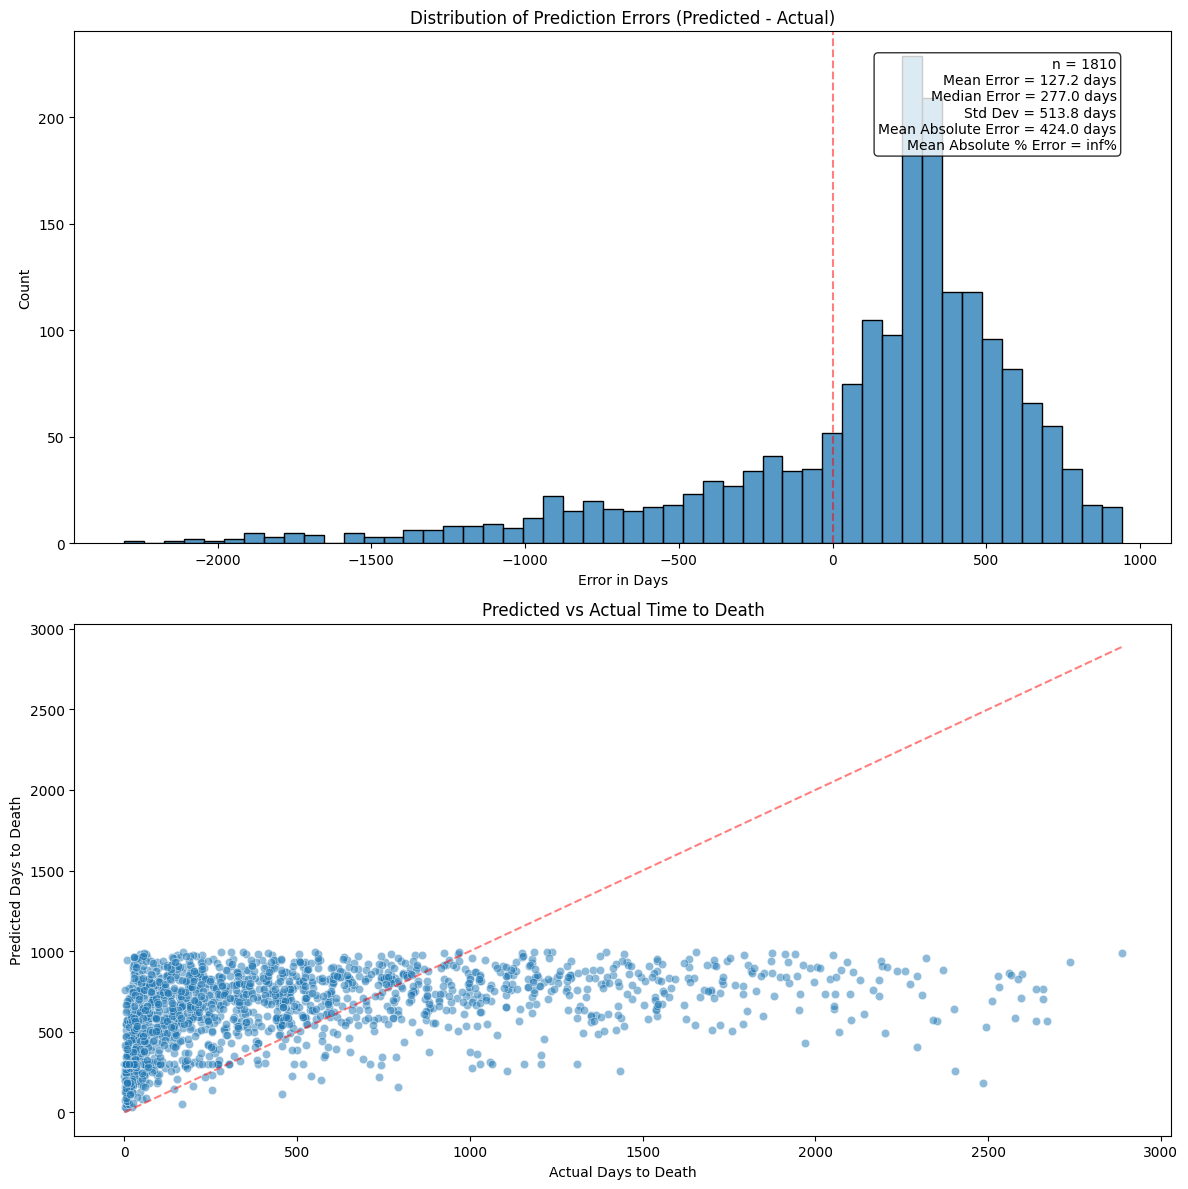


Prediction Error Statistics:
Number of death cases: 1810
Mean error: 127.2 days
Median error: 277.0 days
Standard deviation: 513.8 days
Mean absolute error: 424.0 days
Mean absolute percentage error: inf%

Error Quartiles:
count    1810.000000
mean      127.212654
std       513.799253
min     -2303.308283
25%        -4.663632
50%       277.044966
75%       434.558194
max       938.982995
Name: error, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate prediction errors (predicted - actual)
death_cases['error'] = death_cases['predicted_death_tte'] - death_cases['tte']

# Calculate summary statistics
error_stats = {
    'n': len(death_cases),
    'mean': death_cases['error'].mean(),
    'median': death_cases['error'].median(),
    'std': death_cases['error'].std(),
    'mae': death_cases['error'].abs().mean(),
    'mape': (death_cases['error'].abs() / death_cases['tte']).mean() * 100
}

# Create figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 1. Error Distribution (Histogram)
sns.histplot(data=death_cases, x='error', bins=50, ax=ax1)
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Distribution of Prediction Errors (Predicted - Actual)')
ax1.set_xlabel('Error in Days')
ax1.set_ylabel('Count')

# Add error statistics to plot
stats_text = f'n = {error_stats["n"]}\n'
stats_text += f'Mean Error = {error_stats["mean"]:.1f} days\n'
stats_text += f'Median Error = {error_stats["median"]:.1f} days\n'
stats_text += f'Std Dev = {error_stats["std"]:.1f} days\n'
stats_text += f'Mean Absolute Error = {error_stats["mae"]:.1f} days\n'
stats_text += f'Mean Absolute % Error = {error_stats["mape"]:.1f}%'

ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Scatter Plot (Predicted vs Actual)
sns.scatterplot(data=death_cases, x='tte', y='predicted_death_tte', alpha=0.5, ax=ax2)
ax2.plot([0, death_cases['tte'].max()], [0, death_cases['tte'].max()], 'r--', alpha=0.5)
ax2.set_title('Predicted vs Actual Time to Death')
ax2.set_xlabel('Actual Days to Death')
ax2.set_ylabel('Predicted Days to Death')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nPrediction Error Statistics:")
print(f"Number of death cases: {error_stats['n']}")
print(f"Mean error: {error_stats['mean']:.1f} days")
print(f"Median error: {error_stats['median']:.1f} days")
print(f"Standard deviation: {error_stats['std']:.1f} days")
print(f"Mean absolute error: {error_stats['mae']:.1f} days")
print(f"Mean absolute percentage error: {error_stats['mape']:.1f}%")

# Optional: Calculate error quartiles
print("\nError Quartiles:")
print(death_cases['error'].describe())

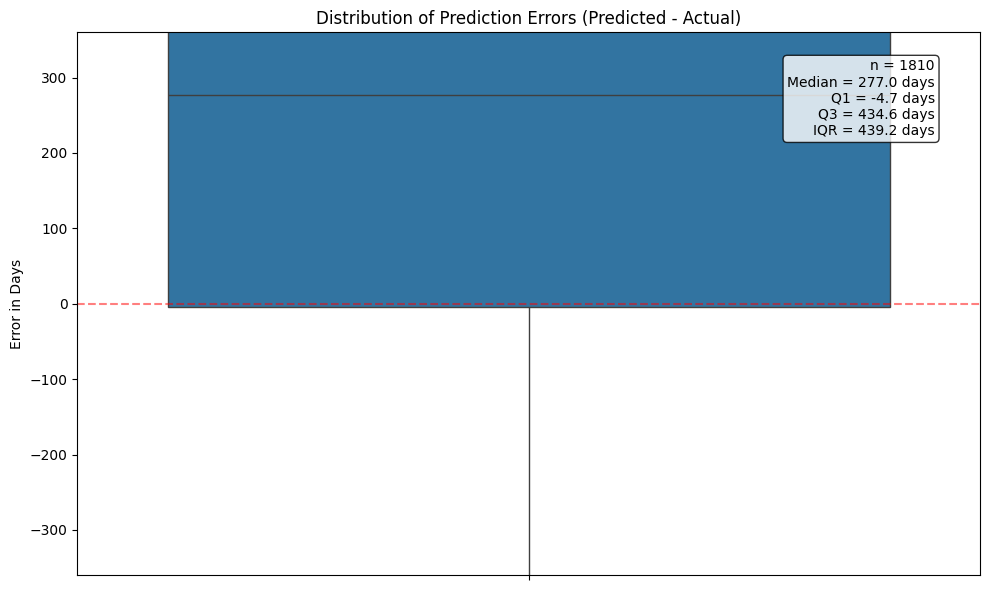


Detailed Error Statistics:
Total death cases: 1810
Median error: 277.0 days
Q1: -4.7 days
Q3: 434.6 days
IQR: 439.2 days

Percentage of errors within ±360 days: 52.7%

Extreme Errors:
Number of cases with |error| > 360 days: 857


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate prediction errors (predicted - actual)
death_cases['error'] = death_cases['predicted_death_tte'] - death_cases['tte']

# Create figure
plt.figure(figsize=(10, 6))

# Create box plot
sns.boxplot(y=death_cases['error'])

# Set y-axis limits to ±360
plt.ylim(-360, 360)

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Customize plot
plt.title('Distribution of Prediction Errors (Predicted - Actual)')
plt.ylabel('Error in Days')

# Calculate and display statistics
stats = {
    'median': death_cases['error'].median(),
    'q1': death_cases['error'].quantile(0.25),
    'q3': death_cases['error'].quantile(0.75),
    'iqr': death_cases['error'].quantile(0.75) - death_cases['error'].quantile(0.25)
}

stats_text = f"n = {len(death_cases)}\n"
stats_text += f"Median = {stats['median']:.1f} days\n"
stats_text += f"Q1 = {stats['q1']:.1f} days\n"
stats_text += f"Q3 = {stats['q3']:.1f} days\n"
stats_text += f"IQR = {stats['iqr']:.1f} days"

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics including percentage of errors within bounds
print("\nDetailed Error Statistics:")
print(f"Total death cases: {len(death_cases)}")
print(f"Median error: {stats['median']:.1f} days")
print(f"Q1: {stats['q1']:.1f} days")
print(f"Q3: {stats['q3']:.1f} days")
print(f"IQR: {stats['iqr']:.1f} days")

# Calculate percentage of cases within bounds
within_bounds = (death_cases['error'].abs() <= 360).mean() * 100
print(f"\nPercentage of errors within ±360 days: {within_bounds:.1f}%")

# Print extreme cases
print("\nExtreme Errors:")
extreme_cases = death_cases[death_cases['error'].abs() > 360]
print(f"Number of cases with |error| > 360 days: {len(extreme_cases)}")

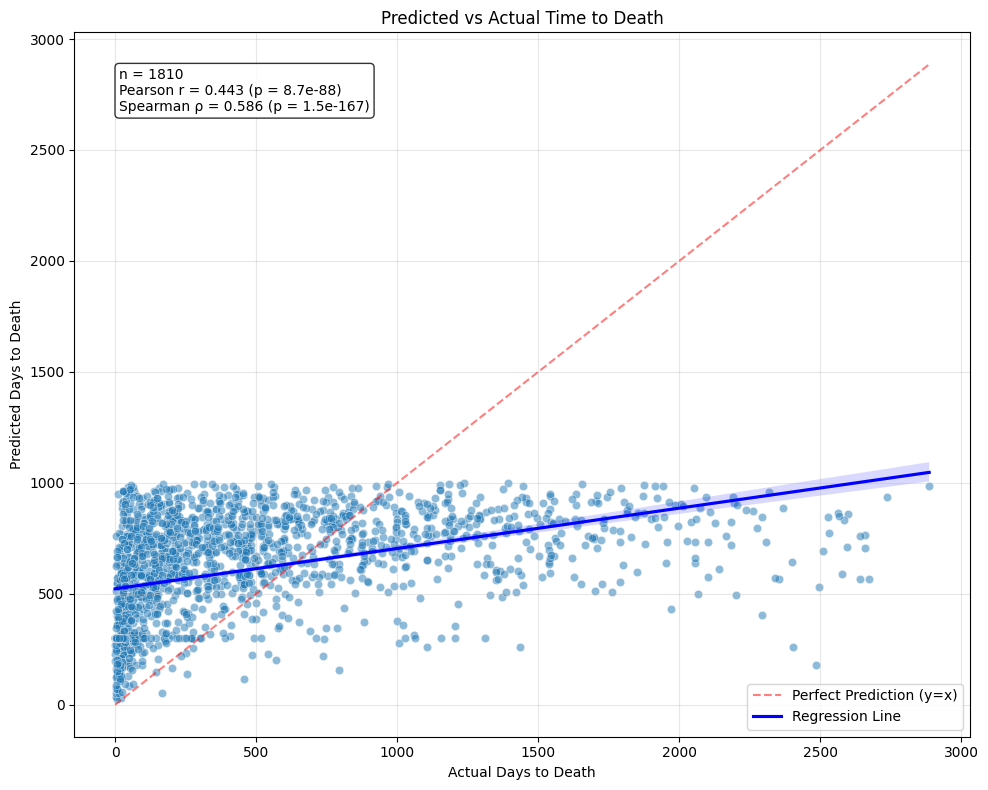


Correlation Analysis (Death Cases Only):
Number of cases: 1810

Pearson correlation:
r = 0.443
p-value = 8.72e-88

Spearman correlation:
ρ = 0.586
p-value = 1.51e-167

R-squared = 0.196


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate correlations
pearson_corr, pearson_p = pearsonr(death_cases['tte'], death_cases['predicted_death_tte'])
spearman_corr, spearman_p = spearmanr(death_cases['tte'], death_cases['predicted_death_tte'])

# Create scatter plot with correlation line
plt.figure(figsize=(10, 8))

# Create scatter plot
sns.scatterplot(data=death_cases, x='tte', y='predicted_death_tte', alpha=0.5)

# Add identity line (y=x)
max_val = max(death_cases['tte'].max(), death_cases['predicted_death_tte'].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Prediction (y=x)')

# Add regression line
sns.regplot(data=death_cases, x='tte', y='predicted_death_tte',
            scatter=False, color='blue', label='Regression Line')

# Customize plot
plt.title('Predicted vs Actual Time to Death')
plt.xlabel('Actual Days to Death')
plt.ylabel('Predicted Days to Death')

# Add correlation statistics
stats_text = f"n = {len(death_cases)}\n"
stats_text += f"Pearson r = {pearson_corr:.3f} (p = {pearson_p:.1e})\n"
stats_text += f"Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.1e})"

plt.text(0.05, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nCorrelation Analysis (Death Cases Only):")
print(f"Number of cases: {len(death_cases)}")
print(f"\nPearson correlation:")
print(f"r = {pearson_corr:.3f}")
print(f"p-value = {pearson_p:.2e}")
print(f"\nSpearman correlation:")
print(f"ρ = {spearman_corr:.3f}")
print(f"p-value = {spearman_p:.2e}")

# Calculate R-squared
r_squared = pearson_corr ** 2
print(f"\nR-squared = {r_squared:.3f}")

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the at-risk set:
    # Everyone who didn't get transplanted or censored before time t
    # (i.e., either died before t, or was followed for at least t days)
    at_risk_mask = (
        (df_all['outcome'] == 0) |  # died
        ((df_all['outcome'].isin([1, 2])) & (df_all['tte'] >= t))  # survived past t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred within t days, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Deaths within {t} days: {event_indicator.sum()}")
        print(f"Survivors past {t} days: {len(event_indicator) - event_indicator.sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_within_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_within_t'] = results_df['N_deaths_within_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Risk of Death within T days, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_within_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

Total patients in dataset: 9757
Outcome distribution:
outcome
2    6863
0    1810
1    1084
Name: count, dtype: int64

At time 7:
Patients at risk: 8052
Deaths within 7 days: 134
Survivors past 7 days: 7918

Time-Dependent AUC (Risk of Death within T days, Censoring Transplant):

Time  N at risk  N deaths  AUC metric  AUC MELD-3
-------------------------------------------------------
   7      8052       134  0.869       0.933     
  14      7233       220  0.891       0.952     
  30      6370       359  0.887       0.931     
  90      5087       583  0.849       0.889     
 180      4269       781  0.812       0.854     
 360      3614      1042  0.774       0.820     


In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the "at-risk" set more simply:
    # - Include all patients who haven't had any event (death or transplant) before time t
    # - Include patients who died by time t (as events)
    at_risk_mask = (
        (df_all['tte'] >= t) |  # Still being followed
        ((df_all['outcome'] == 0) & (df_all['tte'] <= t))  # Or died before t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred by time t, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Events (deaths): {event_indicator.sum()}")
        print(f"Non-events: {len(event_indicator) - event_indicator.sum()}")
        print(f"Mask components:")
        print(f"- Still followed (tte >= t): {(df_all['tte'] >= t).sum()}")
        print(f"- Died before t: {((df_all['outcome'] == 0) & (df_all['tte'] <= t)).sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_by_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_by_t'] = results_df['N_deaths_by_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Death Risk, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_by_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

Total patients in dataset: 9757
Outcome distribution:
outcome
2    6863
0    1810
1    1084
Name: count, dtype: int64

At time 7:
Patients at risk: 8052
Events (deaths): 134
Non-events: 7918
Mask components:
- Still followed (tte >= t): 7940
- Died before t: 134

Time-Dependent AUC (Death Risk, Censoring Transplant):

Time  N at risk  N deaths  AUC metric  AUC MELD-3
-------------------------------------------------------
   7      8052       134  0.869       0.933     
  14      7233       220  0.891       0.952     
  30      6370       359  0.887       0.931     
  90      5087       583  0.849       0.889     
 180      4269       781  0.812       0.854     
 360      3614      1042  0.774       0.820     


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())






Computing local medians:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

   predicted_death_tte
0           353.539846
1           275.158132
2           560.979068
3           197.599757
4          1000.000000


In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.957          0.908             0.962
1    14           0.954          0.908             0.958
2    30           0.945          0.899             0.949
3    90           0.919          0.863             0.922
4   180           0.898          0.836             0.900
5   360           0.877          0.813             0.878

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.978     1.094       0.0      0.0
1    14      0.983     1.102       0.0      0.0
2    30      0.989     1.111       0.0      0.0
3    90      0.995     1.106       0.0      0.0
4   180      0.996     1.099       0.0      0.0
5   360      0.997     1.087       0.0      0.0


In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the "at-risk" set more simply:
    # - Include all patients who haven't had any event (death or transplant) before time t
    # - Include patients who died by time t (as events)
    at_risk_mask = (
        (df_all['tte'] >= t) |  # Still being followed
        ((df_all['outcome'] == 0) & (df_all['tte'] <= t))  # Or died before t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred by time t, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Events (deaths): {event_indicator.sum()}")
        print(f"Non-events: {len(event_indicator) - event_indicator.sum()}")
        print(f"Mask components:")
        print(f"- Still followed (tte >= t): {(df_all['tte'] >= t).sum()}")
        print(f"- Died before t: {((df_all['outcome'] == 0) & (df_all['tte'] <= t)).sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_by_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_by_t'] = results_df['N_deaths_by_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Death Risk, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_by_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

Total patients in dataset: 15914
Outcome distribution:
outcome
2    11162
0     2811
1     1941
Name: count, dtype: int64

At time 7:
Patients at risk: 13240
Events (deaths): 210
Non-events: 13030
Mask components:
- Still followed (tte >= t): 13064
- Died before t: 210

Time-Dependent AUC (Death Risk, Censoring Transplant):

Time  N at risk  N deaths  AUC metric  AUC MELD-3
-------------------------------------------------------
   7     13240       210  0.961       0.933     
  14     11837       354  0.959       0.940     
  30     10364       575  0.951       0.934     
  90      8183       963  0.913       0.892     
 180      6757      1267  0.872       0.858     
 360      5510      1658  0.818       0.823     


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 10
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# 1. First, filter synthetic data to only include death events (outcome 0)
death_only_mask = syn_df_processed['outcome'] == 0
death_only_indices = syn_df_processed[death_only_mask].index
death_only_embeddings = syn_embeddings[death_only_indices]

# 2. Set up nearest neighbor search using only death event embeddings
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(death_only_embeddings)

# 3. Retrieve neighbor indices for all real patients
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# Configuration
ALPHA = 1e-6  # Small constant to avoid division by zero in weights

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average tte based on all neighbors (which are already filtered to death events).
    Weights are 1/(distance + ALPHA).

    Args:
        idx: Index of the real patient

    Returns:
        float: Weighted average time-to-event
    """
    # Get neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Map back to original synthetic data indices
    original_neighbor_idxs = death_only_indices[neighbor_idxs]

    # Get TTE values for these neighbors
    neighbor_ttes = syn_df_processed.loc[original_neighbor_idxs, 'tte']

    # Compute inverse-distance weights
    weights = 1.0 / (neighbor_dists + ALPHA)

    # Calculate weighted average
    weighted_tte = (weights * neighbor_ttes).sum() / weights.sum()

    return weighted_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the weighted death-only tte for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing weighted death-only TTE", total=n_real)) as progress_bar:
    predicted_death_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

predicted_death_tte = np.array(predicted_death_tte)

# Store the predictions in the real_df
real_df['predicted_death_only_tte'] = predicted_death_tte

# Display a sample of the predictions
print("\nSample of death-only TTE predictions:")
print(real_df[['predicted_death_only_tte']].head())

# Optional: print some statistics about the predictions
print("\nPrediction statistics:")
print(real_df['predicted_death_only_tte'].describe())

/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing weighted death-only TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]


Sample of death-only TTE predictions:
   predicted_death_only_tte
0                152.959340
1                 15.060532
2                655.167631
3                362.463109
4                274.730221

Prediction statistics:
count    15914.000000
mean       248.004265
std        241.784366
min          5.799491
25%         24.484048
50%        165.428722
75%        421.639939
max        999.748606
Name: predicted_death_only_tte, dtype: float64


Correlation statistics for death outcomes only:
Pearson correlation: 0.568 (p-value: 1.4e-239)
Spearman correlation: 0.664 (p-value: 0)


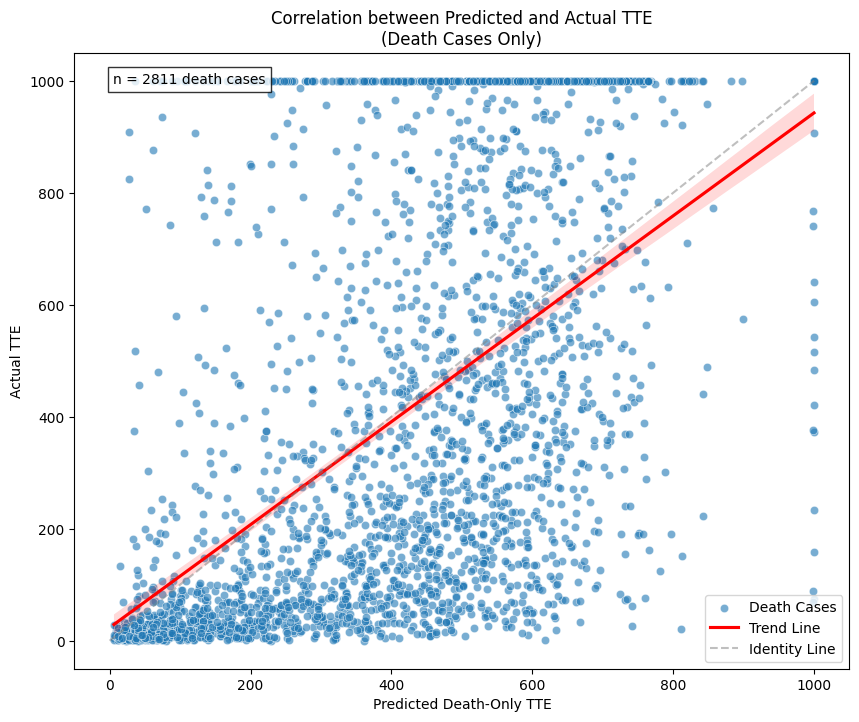


Summary statistics for death cases:

Predicted TTE:
count    2811.000000
mean      385.194193
std       227.985827
min         6.139824
25%       181.579345
50%       414.918661
75%       565.856310
max       999.748606
Name: predicted_death_only_tte, dtype: float64

Actual TTE:
count    2811.000000
mean      377.516542
std       369.223263
min         0.000000
25%        46.000000
50%       225.000000
75%       699.000000
max      1000.000000
Name: tte, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Filter for death outcomes only
death_mask = real_df['outcome'] == 0
death_df = real_df[death_mask]

# Compute correlation coefficients for death cases only
pearson_corr, pearson_p = pearsonr(death_df['predicted_death_only_tte'], death_df['tte'])
spearman_corr, spearman_p = spearmanr(death_df['predicted_death_only_tte'], death_df['tte'])

print("Correlation statistics for death outcomes only:")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3g})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3g})")

# Create a scatter plot with a regression line
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=death_df,
    x='predicted_death_only_tte',
    y='tte',
    alpha=0.6,
    label='Death Cases'
)
sns.regplot(
    data=death_df,
    x='predicted_death_only_tte',
    y='tte',
    scatter=False,
    color='red',
    label='Trend Line'
)

plt.xlabel('Predicted Death-Only TTE')
plt.ylabel('Actual TTE')
plt.title('Correlation between Predicted and Actual TTE\n(Death Cases Only)')
plt.legend()

# Add number of death cases to the plot
n_deaths = len(death_df)
plt.text(
    0.05, 0.95,
    f'n = {n_deaths} death cases',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

# Optional: Add identity line (y=x) for reference
min_val = min(death_df['predicted_death_only_tte'].min(), death_df['tte'].min())
max_val = max(death_df['predicted_death_only_tte'].max(), death_df['tte'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray', alpha=0.5, label='Identity Line')

plt.legend()
plt.show()

# Print additional statistics
print("\nSummary statistics for death cases:")
print("\nPredicted TTE:")
print(death_df['predicted_death_only_tte'].describe())
print("\nActual TTE:")
print(death_df['tte'].describe())

In [ ]:
from sklearn.metrics import auc
from lifelines import CoxPHFitter
from scipy import stats
from sklearn.metrics import roc_auc_score


def calculate_cumulative_incidence(times, events, predict_time):
    """Calculate cumulative incidence at specified time"""
    n_total = len(times)
    n_events = sum((events == 1) & (times <= predict_time))
    return n_events / n_total

def bootstrap_ci(metric_func, data, n_bootstrap=1000, alpha=0.05):
    """Calculate confidence intervals using bootstrapping"""
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(data), len(data))
        bootstrap_sample = data.iloc[indices]
        estimate = metric_func(bootstrap_sample)
        bootstrap_estimates.append(estimate)

    ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    return ci_lower, ci_upper

In [ ]:
from sklearn.metrics import roc_auc_score

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

for t in time_points:
    # Create a mask to exclude transplants (assume outcome 2 is transplant)
    mask = real_df['outcome'].isin([0, 1])
    df_filtered = real_df[mask]

    # Create death indicator (1 if death occurred by time t, 0 if still waiting)
    death_indicator = ((df_filtered['outcome'] == 0) &
                       (df_filtered['tte'] <= t)).astype(int)

    # Define risk scores (the lower the predicted median time, the higher the risk)
    risk_scores = -df_filtered['predicted_death_only_tte']

    # Calculate AUC for death prediction using the filtered dataset
    death_auc = roc_auc_score(death_indicator, risk_scores)

    # Calculate cumulative incidence on the full dataset (if desired) or on df_filtered
    n_death = death_indicator.sum()
    # For cumulative incidence, you might want to consider only those in df_filtered as well:
    n_total = len(df_filtered)
    death_ci = n_death / n_total

    results.append({
        'Time': t,
        'N_death': n_death,
        'N_total': n_total,
        'Death_rate': death_ci,
        'AUC': death_auc
    })

results_df = pd.DataFrame(results)
print("\nResults at different time points (excluding transplants):")
print(results_df)



Results at different time points (excluding transplants):
   Time  N_death  N_total  Death_rate       AUC
0     7      210     4752    0.044192  0.873147
1    14      354     4752    0.074495  0.863711
2    30      575     4752    0.121002  0.834146
3    90      963     4752    0.202652  0.730136
4   180     1267     4752    0.266625  0.649334
5   360     1658     4752    0.348906  0.560722


In [ ]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['tte'] >= t) |
        ((df_filtered['outcome'] == 0) & (df_filtered['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['predicted_death_only_tte']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       4748            210    0.873246   0.952306
1    14       4740            354    0.864116   0.951342
2    30       4714            575    0.835274   0.943483
3    90       4647            963    0.733596   0.902831
4   180       4562           1267    0.657653   0.866671
5   360       4455           1658    0.574244   0.828922


In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['tte'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['predicted_death_only_tte']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7      15910           3194    0.845878   0.882944
1    14      15902           4571    0.852777   0.883922
2    30      15876           6139    0.850455   0.880827
3    90      15809           8609    0.816230   0.855613
4   180      15724          10245    0.777516   0.838098
5   360      15617          11770    0.728982   0.824409


In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_only_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_only_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.711          0.908             0.915
1    14           0.722          0.908             0.914
2    30           0.720          0.899             0.905
3    90           0.679          0.863             0.874
4   180           0.648          0.836             0.851
5   360           0.620          0.813             0.834

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.002     1.223     0.003      0.0
1    14      1.002     1.235     0.000      0.0
2    30      1.002     1.241     0.000      0.0
3    90      1.002     1.233     0.000      0.0
4   180      1.002     1.223     0.000      0.0
5   360      1.002     1.211     0.000      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# 1. Filter synthetic data to include both death and transplant events (outcomes 0 or 2)
composite_mask = syn_df_processed['outcome'].isin([0, 2])
composite_indices = syn_df_processed[composite_mask].index
composite_embeddings = syn_embeddings[composite_indices]

# 2. Set up nearest neighbor search using composite event embeddings
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(composite_embeddings)

# 3. Retrieve neighbor indices for all real patients
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# Configuration
ALPHA = 1e-6  # Small constant to avoid division by zero in weights

def compute_weighted_composite_tte(idx):
    """
    Compute a weighted average tte based on all neighbors (which are already filtered to death or transplant events).
    Weights are 1/(distance + ALPHA).

    Args:
        idx: Index of the real patient

    Returns:
        float: Weighted average time-to-event
        dict: Additional metrics including proportion of death vs transplant among neighbors
    """
    # Get neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Map back to original synthetic data indices
    original_neighbor_idxs = composite_indices[neighbor_idxs]

    # Get neighbor data
    neighbor_data = syn_df_processed.loc[original_neighbor_idxs]
    neighbor_ttes = neighbor_data['tte']

    # Compute inverse-distance weights
    weights = 1.0 / (neighbor_dists + ALPHA)

    # Calculate weighted average TTE
    weighted_tte = (weights * neighbor_ttes).sum() / weights.sum()

    # Calculate additional metrics
    metrics = {
        'n_death': (neighbor_data['outcome'] == 0).sum(),
        'n_transplant': (neighbor_data['outcome'] == 2).sum(),
        'death_proportion': (neighbor_data['outcome'] == 0).mean(),
        'transplant_proportion': (neighbor_data['outcome'] == 2).mean(),
    }

    return weighted_tte, metrics

# Number of real patients
n_real = indices_all.shape[0]

# Compute the weighted composite tte for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing weighted composite TTE", total=n_real)) as progress_bar:
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )

# Unpack results
predicted_ttes, all_metrics = zip(*results)
predicted_composite_tte = np.array(predicted_ttes)

# Store the predictions and metrics in the real_df
real_df['predicted_composite_tte'] = predicted_composite_tte
real_df['n_death_neighbors'] = [m['n_death'] for m in all_metrics]
real_df['n_transplant_neighbors'] = [m['n_transplant'] for m in all_metrics]
real_df['death_neighbor_proportion'] = [m['death_proportion'] for m in all_metrics]
real_df['transplant_neighbor_proportion'] = [m['transplant_proportion'] for m in all_metrics]

# Display a sample of the predictions and metrics
print("\nSample of composite event predictions and metrics:")
print(real_df[[
    'predicted_composite_tte',
    'n_death_neighbors',
    'n_transplant_neighbors',
    'death_neighbor_proportion',
    'transplant_neighbor_proportion'
]].head())

# Print summary statistics
print("\nPrediction statistics:")
print(real_df['predicted_composite_tte'].describe())

print("\nNeighbor composition statistics:")
print("\nAverage proportion of death neighbors:")
print(real_df['death_neighbor_proportion'].mean())
print("\nAverage proportion of transplant neighbors:")
print(real_df['transplant_neighbor_proportion'].mean())


Computing weighted composite TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

Computing weighted death-only TTE:   0%|          | 0/15914 [11:36<?, ?it/s]


Sample of composite event predictions and metrics:
   predicted_composite_tte  n_death_neighbors  n_transplant_neighbors  \
0               152.959340                100                       0   
1                34.975554                  0                     100   
2               655.167631                100                       0   
3               362.463109                100                       0   
4               185.693174                  0                     100   

   death_neighbor_proportion  transplant_neighbor_proportion  
0                        1.0                             0.0  
1                        0.0                             1.0  
2                        1.0                             0.0  
3                        1.0                             0.0  
4                        0.0                             1.0  

Prediction statistics:
count    15914.000000
mean       180.463797
std        177.503099
min          2.193104
25%         37.5080

In [ ]:
from sklearn.metrics import roc_auc_score

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

for t in time_points:
    # Create a mask to exclude transplants (assume outcome 2 is transplant)
    mask = real_df['outcome'].isin([0, 1])
    df_filtered = real_df[mask]

    # Create death indicator (1 if death occurred by time t, 0 if still waiting)
    death_indicator = ((df_filtered['outcome'] == 0) &
                       (df_filtered['tte'] <= t)).astype(int)

    # Define risk scores (the lower the predicted median time, the higher the risk)
    risk_scores = -df_filtered['predicted_composite_tte']

    # Calculate AUC for death prediction using the filtered dataset
    death_auc = roc_auc_score(death_indicator, risk_scores)

    # Calculate cumulative incidence on the full dataset (if desired) or on df_filtered
    n_death = death_indicator.sum()
    # For cumulative incidence, you might want to consider only those in df_filtered as well:
    n_total = len(df_filtered)
    death_ci = n_death / n_total

    results.append({
        'Time': t,
        'N_death': n_death,
        'N_total': n_total,
        'Death_rate': death_ci,
        'AUC': death_auc
    })

results_df = pd.DataFrame(results)
print("\nResults at different time points (excluding transplants):")
print(results_df)



Results at different time points (excluding transplants):
   Time  N_death  N_total  Death_rate       AUC
0     7      210     4752    0.044192  0.873838
1    14      354     4752    0.074495  0.864163
2    30      575     4752    0.121002  0.835040
3    90      963     4752    0.202652  0.730669
4   180     1267     4752    0.266625  0.649711
5   360     1658     4752    0.348906  0.560974


In [ ]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['tte'] >= t) |
        ((df_filtered['outcome'] == 0) & (df_filtered['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['predicted_composite_tte']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       4748            210    0.873936   0.952306
1    14       4740            354    0.864567   0.951342
2    30       4714            575    0.836165   0.943483
3    90       4647            963    0.734125   0.902831
4   180       4562           1267    0.658022   0.866671
5   360       4455           1658    0.574436   0.828922


In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['tte'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['predicted_composite_tte']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7      15910           3194    0.874738   0.882944
1    14      15902           4571    0.877172   0.883922
2    30      15876           6139    0.871261   0.880827
3    90      15809           8609    0.838176   0.855613
4   180      15724          10245    0.810691   0.838098
5   360      15617          11770    0.780336   0.824409


In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.716          0.908             0.926
1    14           0.721          0.908             0.929
2    30           0.703          0.899             0.926
3    90           0.626          0.863             0.911
4   180           0.578          0.836             0.901
5   360           0.459          0.813             0.891

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.004     1.245       0.0      0.0
1    14      1.004     1.260       0.0      0.0
2    30      1.004     1.272       0.0      0.0
3    90      1.005     1.274       0.0      0.0
4   180      1.005     1.269       0.0      0.0
5   360      1.005     1.257       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 50       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

   predicted_composite_tte
0               112.964033
1               114.158698
2               127.515632
3               156.117464
4               126.406779


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.512          0.908             0.908
1    14           0.516          0.908             0.908
2    30           0.521          0.899             0.899
3    90           0.513          0.863             0.863
4   180           0.513          0.836             0.837
5   360           0.514          0.813             0.814

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.999     1.200     0.782      0.0
1    14      1.000     1.211     0.899      0.0
2    30      1.001     1.218     0.710      0.0
3    90      1.000     1.201     0.751      0.0
4   180      1.000     1.184     0.699      0.0
5   360      1.001     1.164     0.101      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 20 closest death neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average tte based on the TOP_K nearest neighbors who died (outcome 0).
    Uses inverse-distance weighting.

    If no neighbors died, returns None to flag this case.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter for death outcomes only
    death_neighbors = neighbors[neighbors['outcome'] == 0]

    if len(death_neighbors) > 0:
        # Use only the TOP_K closest death neighbors
        death_neighbors = death_neighbors.sort_values('dist').head(TOP_K)

        # Compute inverse-distance weights
        weights = 1.0 / (death_neighbors['dist'] + ALPHA)

        # Calculate weighted average TTE
        weighted_tte = (weights * death_neighbors['tte']).sum() / weights.sum()

        # Return prediction and number of death neighbors used
        return {
            'predicted_tte': weighted_tte,
            'n_death_neighbors': len(death_neighbors),
            'mean_neighbor_dist': death_neighbors['dist'].mean(),
            'min_neighbor_dist': death_neighbors['dist'].min(),
            'max_neighbor_dist': death_neighbors['dist'].max()
        }
    else:
        # No death neighbors found
        return {
            'predicted_tte': None,
            'n_death_neighbors': 0,
            'mean_neighbor_dist': None,
            'min_neighbor_dist': None,
            'max_neighbor_dist': None
        }

# Number of real patients
n_real = indices_all.shape[0]

# Compute predictions for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing death-only weighted TTE", total=n_real)) as progress_bar:
    predictions = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

# Convert predictions to DataFrame columns
real_df['predicted_death_tte'] = [p['predicted_tte'] for p in predictions]
real_df['n_death_neighbors'] = [p['n_death_neighbors'] for p in predictions]
real_df['mean_neighbor_dist'] = [p['mean_neighbor_dist'] for p in predictions]
real_df['min_neighbor_dist'] = [p['min_neighbor_dist'] for p in predictions]
real_df['max_neighbor_dist'] = [p['max_neighbor_dist'] for p in predictions]

# Print summary statistics
print("\nPrediction Summary:")
print(f"Total patients: {n_real}")
print(f"Patients with valid predictions: {real_df['predicted_death_tte'].notna().sum()}")
print("\nNeighbor Statistics:")
print(real_df[['n_death_neighbors', 'mean_neighbor_dist']].describe())

# Display sample predictions
print("\nSample predictions:")
print(real_df[[
    'predicted_death_tte',
    'n_death_neighbors',
    'mean_neighbor_dist',
    'min_neighbor_dist',
    'max_neighbor_dist'
]].head())

Computing death-only weighted TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]


Prediction Summary:
Total patients: 15914
Patients with valid predictions: 15914

Neighbor Statistics:
       n_death_neighbors  mean_neighbor_dist
count       15914.000000        15914.000000
mean           18.418185            0.066017
std             2.266203            0.057912
min             6.000000            0.000060
25%            17.000000            0.013325
50%            20.000000            0.060626
75%            20.000000            0.094376
max            20.000000            0.466494

Sample predictions:
   predicted_death_tte  n_death_neighbors  mean_neighbor_dist  \
0           305.753996                 20            0.151025   
1           476.329745                 14            0.006819   
2           486.798378                 16            0.061433   
3           333.291804                 19            0.058376   
4           384.733696                 17            0.086786   

   min_neighbor_dist  max_neighbor_dist  
0           0.132241           0.1653

In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.500          0.908             0.908
1    14           0.506          0.908             0.908
2    30           0.506          0.899             0.899
3    90           0.503          0.863             0.863
4   180           0.500          0.836             0.836
5   360           0.501          0.813             0.813

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7        1.0     1.200     0.854      0.0
1    14        1.0     1.211     0.550      0.0
2    30        1.0     1.218     0.428      0.0
3    90        1.0     1.201     0.542      0.0
4   180        1.0     1.184     0.642      0.0
5   360        1.0     1.164     0.330      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 20 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a weighted average tte based on the TOP_K nearest neighbors who either
    died (outcome 0) or received transplant (outcome 2).
    Uses inverse-distance weighting.

    If no neighbors had either outcome, returns None to flag this case.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter for death or transplant outcomes
    event_neighbors = neighbors[neighbors['outcome'].isin([0, 2])]

    if len(event_neighbors) > 0:
        # Use only the TOP_K closest event neighbors
        event_neighbors = event_neighbors.sort_values('dist').head(TOP_K)

        # Compute inverse-distance weights
        weights = 1.0 / (event_neighbors['dist'] + ALPHA)

        # Calculate weighted average TTE
        weighted_tte = (weights * event_neighbors['tte']).sum() / weights.sum()

        # Count neighbors by outcome
        n_death = (event_neighbors['outcome'] == 0).sum()
        n_transplant = (event_neighbors['outcome'] == 2).sum()

        return {
            'predicted_tte': weighted_tte,
            'n_death_neighbors': n_death,
            'n_transplant_neighbors': n_transplant,
            'total_event_neighbors': len(event_neighbors),
            'mean_neighbor_dist': event_neighbors['dist'].mean(),
            'min_neighbor_dist': event_neighbors['dist'].min(),
            'max_neighbor_dist': event_neighbors['dist'].max(),
            'death_proportion': n_death / len(event_neighbors),
            'transplant_proportion': n_transplant / len(event_neighbors)
        }
    else:
        # No qualifying neighbors found
        return {
            'predicted_tte': None,
            'n_death_neighbors': 0,
            'n_transplant_neighbors': 0,
            'total_event_neighbors': 0,
            'mean_neighbor_dist': None,
            'min_neighbor_dist': None,
            'max_neighbor_dist': None,
            'death_proportion': None,
            'transplant_proportion': None
        }

# Number of real patients
n_real = indices_all.shape[0]

# Compute predictions for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predictions = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )

# Convert predictions to DataFrame columns
real_df['predicted_composite_tte'] = [p['predicted_tte'] for p in predictions]
real_df['n_death_neighbors'] = [p['n_death_neighbors'] for p in predictions]
real_df['n_transplant_neighbors'] = [p['n_transplant_neighbors'] for p in predictions]
real_df['total_event_neighbors'] = [p['total_event_neighbors'] for p in predictions]
real_df['mean_neighbor_dist'] = [p['mean_neighbor_dist'] for p in predictions]
real_df['min_neighbor_dist'] = [p['min_neighbor_dist'] for p in predictions]
real_df['max_neighbor_dist'] = [p['max_neighbor_dist'] for p in predictions]
real_df['death_proportion'] = [p['death_proportion'] for p in predictions]
real_df['transplant_proportion'] = [p['transplant_proportion'] for p in predictions]

# Print summary statistics
print("\nPrediction Summary:")
print(f"Total patients: {n_real}")
print(f"Patients with valid predictions: {real_df['predicted_composite_tte'].notna().sum()}")

print("\nNeighbor Composition:")
print("Average proportions across all predictions:")
print(f"Death: {real_df['death_proportion'].mean():.3f}")
print(f"Transplant: {real_df['transplant_proportion'].mean():.3f}")

print("\nNeighbor Statistics:")
print(real_df[[
    'n_death_neighbors',
    'n_transplant_neighbors',
    'mean_neighbor_dist'
]].describe())

# Display sample predictions
print("\nSample predictions:")
print(real_df[[
    'predicted_composite_tte',
    'n_death_neighbors',
    'n_transplant_neighbors',
    'death_proportion',
    'transplant_proportion',
    'mean_neighbor_dist'
]].head())


Computing composite weighted TTE:   0%|          | 0/15914 [00:00<?, ?it/s]

  0%|          | 0/15914 [00:00<?, ?it/s]

Computing death-only weighted TTE:   0%|          | 0/15914 [05:21<?, ?it/s]



Prediction Summary:
Total patients: 15914
Patients with valid predictions: 15914

Neighbor Composition:
Average proportions across all predictions:
Death: 0.201
Transplant: 0.799

Neighbor Statistics:
       n_death_neighbors  n_transplant_neighbors  mean_neighbor_dist
count       15914.000000            15914.000000        15914.000000
mean            4.022936               15.977064            0.049951
std             1.792382                1.792382            0.050248
min             0.000000                7.000000            0.000031
25%             3.000000               15.000000            0.010127
50%             4.000000               16.000000            0.040889
75%             5.000000               17.000000            0.067520
max            13.000000               20.000000            0.448756

Sample predictions:
   predicted_composite_tte  n_death_neighbors  n_transplant_neighbors  \
0               259.923790                  5                      15   
1         